##  Notebook 02 de 06


(Versão, 14 de Abril de 2025)




# Detecção de Desbalanceamento em Máquinas Rotativas por meio da Análise de Sinais de Vibração utilizando Deep Learning

**Notebook usado como Referência:**

Oliver Mey, Willi Neudeck, André Schneider and Olaf Enge-Rosenblatt. "Machine Learning Based Unbalance Detection of a Rotating Shaft Using Vibration Data". 25th IEEE International Conference on Emerging Technologies and Factory Automation, ETFA 2020.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Abordagem 2: CNN - Convolutional Neural Network

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sc
import zipfile
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import scipy.signal as signal

## Carregando base de dados

A base de dados está disponível via Fraunhofer Fortadis data space (https://fordatis.fraunhofer.de/handle/fordatis/151.2). Como o tamanho do dataset completo é de 2.7 GB, este notebook utilizará um subconjunto reduzido do dataset disponível na URL indicada na opção A. No total, são disponibilizados datasets de Treino (D) e Validação (E) para 4 níveis distintos de desbalanceamento (1D/1E ... 4D/4E) e um dataset sem desbalanceamento algum (0D/0E). Cada dataset é estruturado como um arquivo csv com as cinco colunas seguintes:

1. Tensão Aplicada no Motor (V);
2. Velocidade Medida do Motor (RPM);
3. Vibração Sensor 1;
4. Vibração Sensor 2;
5. Vibração Sensor 3.

In [ ]:
# Option a) local file contains a small subset of the entire dataset
url = '/content/gdrive/MyDrive/Base de Dados/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option b) the entire dataset can be directly downloaded via public Fraunhofer Fortadis dataspace
#url = 'https://fordatis.fraunhofer.de/bitstream/fordatis/151.2/1/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option c) selected pre-trained models can be found in the directory model/reference
use_reference_models = False
model_path = '../models/reference'

# Option d) all models will be trained again
#use_reference_models = False
#model_path = '../models'

In [ ]:
with zipfile.ZipFile(url, 'r') as f:
    with f.open('0D.csv', 'r') as c:
        data0D = pd.read_csv(c)
    with f.open('0E.csv', 'r') as c:
        data0E = pd.read_csv(c)
    with f.open('1D.csv', 'r') as c:
        data1D = pd.read_csv(c)
    with f.open('1E.csv', 'r') as c:
        data1E = pd.read_csv(c)
    with f.open('2D.csv', 'r') as c:
        data2D = pd.read_csv(c)
    with f.open('2E.csv', 'r') as c:
        data2E = pd.read_csv(c)
    with f.open('3D.csv', 'r') as c:
        data3D = pd.read_csv(c)
    with f.open('3E.csv', 'r') as c:
        data3E = pd.read_csv(c)
    with f.open('4D.csv', 'r') as c:
        data4D = pd.read_csv(c)
    with f.open('4E.csv', 'r') as c:
        data4E = pd.read_csv(c)

In [ ]:
skip = 50000
data0D = data0D.iloc[skip:,:]
data1D = data1D.iloc[skip:,:]
data2D = data2D.iloc[skip:,:]
data3D = data3D.iloc[skip:,:]
data4D = data4D.iloc[skip:,:]
data0E = data0E.iloc[skip:,:]
data1E = data1E.iloc[skip:,:]
data2E = data2E.iloc[skip:,:]
data3E = data3E.iloc[skip:,:]
data4E = data4E.iloc[skip:,:]

At the moment only the first vibration sensor **Vibration_1** is used for the analysis. All four data streams may need to be included in the future.

In [ ]:
labels = {'no_unbalance':0, 'unbalance':1}
sensor = 'Vibration_1'
samples_per_second = 4096
seconds_per_analysis = 1.0
window = int(samples_per_second*seconds_per_analysis)

def get_features(data, label):
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X,y

X0,y0 = get_features(data0D[sensor], "no_unbalance")
X1,y1 = get_features(data1D[sensor], "unbalance")
X2,y2 = get_features(data2D[sensor], "unbalance")
X3,y3 = get_features(data3D[sensor], "unbalance")
X4,y4 = get_features(data4D[sensor], "unbalance")
X=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X0_val, y0_val = get_features(data0E[sensor], "no_unbalance")
X1_val, y1_val = get_features(data1E[sensor], "unbalance")
X2_val, y2_val = get_features(data2E[sensor], "unbalance")
X3_val, y3_val = get_features(data3E[sensor], "unbalance")
X4_val, y4_val = get_features(data4E[sensor], "unbalance")
X_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

**Data Augmentation**

In [ ]:
#Data Augmentation
augmentation = False

if(augmentation):
  X0a,y0a = get_features(data0D[sensor].iloc[1024:], "no_unbalance")
  X1a,y1a = get_features(data1D[sensor].iloc[1024:], "unbalance")
  X2a,y2a = get_features(data2D[sensor].iloc[1024:], "unbalance")
  X3a,y3a = get_features(data3D[sensor].iloc[1024:], "unbalance")
  X4a,y4a = get_features(data4D[sensor].iloc[1024:], "unbalance")

  X0b,y0b = get_features(data0D[sensor].iloc[2048:], "no_unbalance")
  X1b,y1b = get_features(data1D[sensor].iloc[2048:], "unbalance")
  X2b,y2b = get_features(data2D[sensor].iloc[2048:], "unbalance")
  X3b,y3b = get_features(data3D[sensor].iloc[2048:], "unbalance")
  X4b,y4b = get_features(data4D[sensor].iloc[2048:], "unbalance")

  X0c,y0c = get_features(data0D[sensor].iloc[3072:], "no_unbalance")
  X1c,y1c = get_features(data1D[sensor].iloc[3072:], "unbalance")
  X2c,y2c = get_features(data2D[sensor].iloc[3072:], "unbalance")
  X3c,y3c = get_features(data3D[sensor].iloc[3072:], "unbalance")
  X4c,y4c = get_features(data4D[sensor].iloc[3072:], "unbalance")

  X=np.concatenate([X, X0a, X1a, X2a, X3a, X4a,
                    X0b, X1b, X2b, X3b, X4b, X0c, X1c, X2c, X3c, X4c])
  y=np.concatenate([y, y0a, y1a, y2a, y3a, y4a,
                    y0b, y1b, y2b, y3b, y4b, y0c, y1c, y2c, y3c, y4c])

In [ ]:
print(X.shape, y.shape, X_val.shape, y_val.shape)

(32166, 4096) (32166,) (8359, 4096) (8359,)


## Feature Extraction: Preprocessamento dos dados

Podem ser avaliados 03 diferentes tratamentos do sinal de entrada:
1. **TimeDomain**: Sinal de vibração no domínio do tempo (4096 pontos);
2. **FrequencyDomain**: Amplitude da FFT do sinal de vibração (2048 pontos);
3. **EnvelopeSpectrum**: Amplitude do espectro do envelope do sinal de vibração (2048 pontos).

In [ ]:
Sinais_de_Entrada = {'TimeDomain', 'FrequencyDomain', 'EnvelopeSpectrum'}
SinaldeEntrada = 'FrequencyDomain'

**Janelamento** (Posicionado aqui para não gerar estouro de RAM)

In [ ]:
janelamento = False
if SinaldeEntrada == 'FrequencyDomain':
  if(janelamento):
    janela_hamming = np.hamming(window)
    X = X*janela_hamming
    X_val = X_val*janela_hamming

In [ ]:
print(X.shape, y.shape, X_val.shape, y_val.shape)

(32166, 4096) (32166,) (8359, 4096) (8359,)


## Separação Treino e Teste

TO dataset para treinamento (X,y) é dividido em dois subconjuntos (X_train,y_train) e (X_test,y_test).

In [ ]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1-train_test_ratio, random_state = 0)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(28949, 4096, 1) (28949,) (3217, 4096, 1) (3217,)


**Amostras no Domínio do Tempo**

In [ ]:
if SinaldeEntrada == 'TimeDomain':
  #Encaixando o domínio do tempo no código
  #X_fft = X
  X_train_fft = X_train
  X_test_fft = X_test
  X_val_fft = X_val
  print("Operando com sinal no domínio do tempo")

**Código Adicional para calcular o ES**

In [ ]:
filtrar_sinal = False

if SinaldeEntrada == 'EnvelopeSpectrum':

  #Importando bibliotecas
  import scipy.signal as signal

  if(filtrar_sinal):
    #Filtrando o sinal (Opcional)
    fs = 4096  # Exemplo: taxa de amostragem em Hz
    lowcut = 1000
    highcut = 10000
    b, a = signal.butter(N=4, Wn=[lowcut, highcut], btype='bandpass', fs=fs)
    x_filtered = signal.filtfilt(b, a, x)  # x é o sinal original

  #Extraindo o envelope do sinal com a Transformada de Hilbert

  analytic_signal_X  = signal.hilbert(X)
  envelope_X = np.abs(analytic_signal_X)

  analytic_signal_X_train = signal.hilbert(X_train)
  envelope_X_train = np.abs(analytic_signal_X_train)

  analytic_signal_X_test = signal.hilbert(X_test)
  envelope_X_test = np.abs(analytic_signal_X_test)

  analytic_signal_X_val = signal.hilbert(X_val)
  envelope_X_val = np.abs(analytic_signal_X_val)

  #Calcular o espectro do envelope por meio da Transformada De Fourier
  envelope_spectrum_X = np.abs(np.fft.rfft(envelope_X, axis=1))[:,:int(window/2)]

  envelope_spectrum_X_train = np.abs(np.fft.rfft(envelope_X_train, axis=1))[:,:int(window/2)]

  envelope_spectrum_X_test = np.abs(np.fft.rfft(envelope_X_test, axis=1))[:,:int(window/2)]

  envelope_spectrum_X_val = np.abs(np.fft.rfft(envelope_X_val, axis=1))[:,:int(window/2)]

  #"Encaixando" o sinal do envelope spectrum no código
  X_fft = envelope_spectrum_X
  X_train_fft = envelope_spectrum_X_train
  X_test_fft = envelope_spectrum_X_test
  X_val_fft = envelope_spectrum_X_val

  #Garbage collection
  del analytic_signal_X, analytic_signal_X_train, analytic_signal_X_test, analytic_signal_X_val
  del envelope_X, envelope_X_train, envelope_X_test, envelope_X_val
  del envelope_spectrum_X, envelope_spectrum_X_train, envelope_spectrum_X_test, envelope_spectrum_X_val
  print("Operando com Envelope Spectrum")

**Código adicional para extrair o Módulo da FFT do sinal (Não executar quando estiver no domínio do tempo)**

In [ ]:
#O janelamento já foi realizado anteriormente
if SinaldeEntrada == 'FrequencyDomain':
  X_fft = np.abs(np.fft.rfft(X, axis=1))[:,:int(window/2)]
  X_train_fft = np.abs(np.fft.rfft(X_train, axis=1))[:,:int(window/2)]
  X_test_fft = np.abs(np.fft.rfft(X_test, axis=1))[:,:int(window/2)]
  X_val_fft = np.abs(np.fft.rfft(X_val, axis=1))[:,:int(window/2)]

  X_fft[:,0]=0
  X_train_fft[:,0]=0
  X_test_fft[:,0]=0
  X_val_fft[:,0]=0

  print("Operando com sinal no domínio da frequência")

Operando com sinal no domínio da frequência


**Scaling**

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(quantile_range=(5,95)).fit(X_train_fft[:,:,0])

#X_fft_sc = scaler.transform(X_fft[:,:,0])
X_train_fft_sc = scaler.transform(X_train_fft[:,:,0])
X_test_fft_sc = scaler.transform(X_test_fft[:,:,0])
X_val_fft_sc = scaler.transform(X_val_fft[:,:,0])

**Encaixando no código**

In [ ]:
X_train = X_train_fft_sc
X_test = X_test_fft_sc
X_val = X_val_fft_sc

(28949, 2048, 1) (20489,) (3217, 2048, 1) (3217,) (8359, 2048, 1) (8359,)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(28949, 2048) (28949,) (3217, 2048) (3217,) (8359, 2048) (8359,)


## Convolutional Neural Net (CNN)

## Test with Different Layer Numbers

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Dense,Dropout
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Flatten,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

weight_for_0 = len(y)/(2*len(y[y==0]))
weight_for_1 = len(y)/(2*len(y[y==1]))
class_weight = {0: weight_for_0, 1: weight_for_1}

def train_models(n_conv_layers):
    #n_conv_layers = 3 # [1,2,3,4]
    n_dense_units = 128
    dropout_rate = 0.0
    use_batch_normalization = True # [True, False]
    filter_size = 9 # [5,7,9]
    learning_rate = 0.0001
    n_epochs = 100 # [50,100,200]

    X_in = Input(shape=(X_train.shape[1],1))
    x = X_in
    for j in range(n_conv_layers):
        print(j)
        x = Conv1D(filters=(j+1)*10,
                   kernel_size=filter_size,
                   strides=1,
                   activation='linear',
                   kernel_initializer='he_uniform')(x)
        if use_batch_normalization:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.05)(x)
        x = MaxPooling1D(pool_size=5, strides=2)(x)
    x = Flatten()(x)
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    X_out = Dense(units = 1, activation = 'sigmoid')(x)
    classifier = Model(X_in, X_out)
    classifier.summary()

    best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers.h5"
    checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss',
                                 verbose=1, save_best_only=True, mode='min')

    classifier.compile(optimizer = Adam(learning_rate=learning_rate), loss = 'binary_crossentropy',
                       metrics = ['accuracy'])

    history = classifier.fit(X_train, y_train, epochs = n_epochs, batch_size = 64,
                   validation_data=(X_test, y_test), callbacks=[checkpoint],
                   class_weight=class_weight)
    classifier = load_model(best_model_filepath)
    score = classifier.evaluate(X_val, y_val)

In [ ]:
nMaxConvLayers = 5

In [ ]:
if not use_reference_models:
    for i in range(1,nMaxConvLayers+1):
        train_models(i)

0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10180)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,303,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,303,437 (4.97 MB)

 Trainable params: 1,303,417 (4.97 MB)

 Non-trainable params: 20 (80.00 B)

Epoch 1/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8806 - loss: 0.2274
Epoch 1: val_loss improved from inf to 0.07343, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8808 - loss: 0.2272 - val_accuracy: 0.9649 - val_loss: 0.0734
Epoch 2/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9859 - loss: 0.0442
Epoch 2: val_loss improved from 0.07343 to 0.05232, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9859 - loss: 0.0441 - val_accuracy: 0.9754 - val_loss: 0.0523
Epoch 3/100
438/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0213
Epoch 3: val_loss improved from 0.05232 to 0.01437, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9957 - loss: 0.0212 - val_accuracy: 0.9969 - val_loss: 0.0144
Epoch 4/100
434/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0106
Epoch 4: val_loss improved from 0.01437 to 0.01018, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9987 - loss: 0.0106 - val_accuracy: 0.9981 - val_loss: 0.0102
Epoch 5/100
432/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0205
Epoch 5: val_loss improved from 0.01018 to 0.00589, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9958 - loss: 0.0212 - val_accuracy: 0.9994 - val_loss: 0.0059
Epoch 6/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0063
Epoch 6: val_loss improved from 0.00589 to 0.00552, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9991 - loss: 0.0063 - val_accuracy: 0.9997 - val_loss: 0.0055
Epoch 7/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0048
Epoch 7: val_loss improved from 0.00552 to 0.00493, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9995 - loss: 0.0048 - val_accuracy: 0.9991 - val_loss: 0.0049
Epoch 8/100
440/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0049
Epoch 8: val_loss improved from 0.00493 to 0.00433, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9991 - loss: 0.0049 - val_accuracy: 0.9991 - val_loss: 0.0043
Epoch 9/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0043
Epoch 9: val_loss did not improve from 0.00433
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9991 - loss: 0.0043 - val_accuracy: 0.9991 - val_loss: 0.0059
Epoch 10/100
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0027
Epoch 10: val_loss improved from 0.00433 to 0.00192, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9997 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 11/100
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0023
Epoch 11: val_loss improved from 0.00192 to 0.00158, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9998 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 12/100
444/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0019
Epoch 12: val_loss improved from 0.00158 to 0.00122, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 13/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0018
Epoch 13: val_loss did not improve from 0.00122
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 14/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0014
Epoch 14: val_loss improved from 0.00122 to 0.00082, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 8.2026e-04
Epoch 15/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0017
Epoch 15: val_loss did not improve from 0.00082
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 16/100
435/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 8.0682e-04
Epoch 16: val_loss did not improve from 0.00082
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 8.1252e-04 - val_accuracy: 0.9981 - val_loss: 0.0064
Epoch 17/100
432/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0397
Epoch 17: val_loss improved from 0.00082 to 0.00070, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9914 - loss: 0.0386 - val_accuracy: 1.0000 - val_loss: 7.0420e-04
Epoch 18/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 7.4568e-04
Epoch 18: val_loss improved from 0.00070 to 0.00055, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 7.4570e-04 - val_accuracy: 1.0000 - val_loss: 5.5130e-04
Epoch 19/100
435/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.2499e-04
Epoch 19: val_loss did not improve from 0.00055
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 6.2421e-04 - val_accuracy: 1.0000 - val_loss: 6.4101e-04
Epoch 20/100
435/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.1971e-04
Epoch 20: val_loss improved from 0.00055 to 0.00039, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.1784e-04 - val_accuracy: 1.0000 - val_loss: 3.8731e-04
Epoch 21/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.3139e-04
Epoch 21: val_loss did not improve from 0.00039
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.3324e-04 - val_accuracy: 1.0000 - val_loss: 6.2147e-04
Epoch 22/100
441/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 4.4589e-04
Epoch 22: val_loss did not improve from 0.00039
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 4.5036e-04 - val_accuracy: 1.0000 - val_loss: 3.9115e-04
Epoch 23/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.6862e-04
Epoch 23: val_loss did not improve from 0.00039
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.6975e-04 - val_accuracy: 1.0000 - val_loss: 9.0443e-04
Epoch 24/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss:

453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.9490e-04 - val_accuracy: 1.0000 - val_loss: 2.5543e-04
Epoch 25/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.9884e-04
Epoch 25: val_loss did not improve from 0.00026
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.0024e-04 - val_accuracy: 1.0000 - val_loss: 2.9955e-04
Epoch 26/100
435/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.4435e-04
Epoch 26: val_loss did not improve from 0.00026
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.4469e-04 - val_accuracy: 1.0000 - val_loss: 2.9061e-04
Epoch 27/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0011
Epoch 27: val_loss improved from 0.00026 to 0.00019, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 1.9130e-04
Epoch 28/100
431/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.4758e-04
Epoch 28: val_loss improved from 0.00019 to 0.00015, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.4560e-04 - val_accuracy: 1.0000 - val_loss: 1.5081e-04
Epoch 29/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.7943e-04
Epoch 29: val_loss did not improve from 0.00015
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.7962e-04 - val_accuracy: 1.0000 - val_loss: 1.7143e-04
Epoch 30/100
433/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.6011e-04
Epoch 30: val_loss improved from 0.00015 to 0.00014, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.5992e-04 - val_accuracy: 1.0000 - val_loss: 1.3737e-04
Epoch 31/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.1305e-04
Epoch 31: val_loss did not improve from 0.00014
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.1357e-04 - val_accuracy: 1.0000 - val_loss: 1.7915e-04
Epoch 32/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3647e-04
Epoch 32: val_loss did not improve from 0.00014
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.3792e-04 - val_accuracy: 1.0000 - val_loss: 1.7133e-04
Epoch 33/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.5042e-04
Epoch 33: val_loss did not improve from 0.00014
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.5146e-04 - val_accuracy: 0.9329 - val_loss: 0.5370
Epoch 34/100
431/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0

453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.3004e-04 - val_accuracy: 1.0000 - val_loss: 1.3653e-04
Epoch 37/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.1235e-04
Epoch 37: val_loss improved from 0.00014 to 0.00013, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.1233e-04 - val_accuracy: 1.0000 - val_loss: 1.2502e-04
Epoch 38/100
432/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.1704e-04
Epoch 38: val_loss improved from 0.00013 to 0.00012, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.1645e-04 - val_accuracy: 1.0000 - val_loss: 1.1697e-04
Epoch 39/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.1063e-04
Epoch 39: val_loss did not improve from 0.00012
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.1067e-04 - val_accuracy: 1.0000 - val_loss: 1.3605e-04
Epoch 40/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.0008e-04
Epoch 40: val_loss improved from 0.00012 to 0.00011, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 9.9588e-05 - val_accuracy: 1.0000 - val_loss: 1.1286e-04
Epoch 41/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.0858e-05
Epoch 41: val_loss improved from 0.00011 to 0.00009, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 7.1256e-05 - val_accuracy: 1.0000 - val_loss: 9.2789e-05
Epoch 42/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.5989e-05
Epoch 42: val_loss improved from 0.00009 to 0.00009, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 6.6043e-05 - val_accuracy: 1.0000 - val_loss: 8.5815e-05
Epoch 43/100
439/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.2561e-05
Epoch 43: val_loss improved from 0.00009 to 0.00008, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 6.2683e-05 - val_accuracy: 1.0000 - val_loss: 7.8810e-05
Epoch 44/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.0294e-04
Epoch 44: val_loss improved from 0.00008 to 0.00007, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.0277e-04 - val_accuracy: 1.0000 - val_loss: 6.5437e-05
Epoch 45/100
439/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.5583e-05
Epoch 45: val_loss did not improve from 0.00007
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.5813e-05 - val_accuracy: 1.0000 - val_loss: 8.8188e-05
Epoch 46/100
434/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.1815e-05
Epoch 46: val_loss did not improve from 0.00007
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 6.1369e-05 - val_accuracy: 1.0000 - val_loss: 7.2683e-05
Epoch 47/100
433/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.2420e-05
Epoch 47: val_loss improved from 0.00007 to 0.00006, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 7.3964e-05 - val_accuracy: 1.0000 - val_loss: 6.2140e-05
Epoch 48/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.3955e-05
Epoch 48: val_loss did not improve from 0.00006
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.4019e-05 - val_accuracy: 1.0000 - val_loss: 1.2360e-04
Epoch 49/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.7274e-05
Epoch 49: val_loss did not improve from 0.00006
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.7316e-05 - val_accuracy: 1.0000 - val_loss: 6.2997e-05
Epoch 50/100
433/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.6386e-05
Epoch 50: val_loss improved from 0.00006 to 0.00004, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.6344e-05 - val_accuracy: 1.0000 - val_loss: 3.8826e-05
Epoch 51/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.2997e-05
Epoch 51: val_loss did not improve from 0.00004
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.3129e-05 - val_accuracy: 1.0000 - val_loss: 1.1996e-04
Epoch 52/100
431/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0069
Epoch 52: val_loss did not improve from 0.00004
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9989 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 5.2574e-05
Epoch 53/100
439/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.6090e-05
Epoch 53: val_loss did not improve from 0.00004
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.6071e-05 - val_accuracy: 1.0000 - val_loss: 4.3395e-05
Epoch 54/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.2509e

453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.7167e-05 - val_accuracy: 1.0000 - val_loss: 3.6907e-05
Epoch 56/100
432/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.3640e-05
Epoch 56: val_loss improved from 0.00004 to 0.00004, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.3773e-05 - val_accuracy: 1.0000 - val_loss: 3.6378e-05
Epoch 57/100
442/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.7420e-05
Epoch 57: val_loss improved from 0.00004 to 0.00004, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.7379e-05 - val_accuracy: 1.0000 - val_loss: 3.5062e-05
Epoch 58/100
435/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.9836e-05
Epoch 58: val_loss improved from 0.00004 to 0.00003, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.9639e-05 - val_accuracy: 1.0000 - val_loss: 3.1526e-05
Epoch 59/100
434/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.0550e-05
Epoch 59: val_loss did not improve from 0.00003
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.0421e-05 - val_accuracy: 1.0000 - val_loss: 3.2763e-05
Epoch 60/100
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.1989e-05
Epoch 60: val_loss improved from 0.00003 to 0.00003, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.1981e-05 - val_accuracy: 1.0000 - val_loss: 3.0313e-05
Epoch 61/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.8288e-05
Epoch 61: val_loss improved from 0.00003 to 0.00003, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.8291e-05 - val_accuracy: 1.0000 - val_loss: 2.9138e-05
Epoch 62/100
434/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.6999e-05
Epoch 62: val_loss improved from 0.00003 to 0.00003, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.7006e-05 - val_accuracy: 1.0000 - val_loss: 2.6172e-05
Epoch 63/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.6069e-05
Epoch 63: val_loss did not improve from 0.00003
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.6187e-05 - val_accuracy: 1.0000 - val_loss: 2.7574e-05
Epoch 64/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.6155e-05
Epoch 64: val_loss improved from 0.00003 to 0.00002, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.6123e-05 - val_accuracy: 1.0000 - val_loss: 2.3846e-05
Epoch 65/100
433/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.5549e-05
Epoch 65: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.5495e-05 - val_accuracy: 1.0000 - val_loss: 2.2525e-05
Epoch 66/100
431/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.5119e-05
Epoch 66: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.5026e-05 - val_accuracy: 1.0000 - val_loss: 2.0364e-05
Epoch 67/100
433/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.5809e-05
Epoch 67: val_loss did not improve from 0.00002
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.5705e-05 - val_accuracy: 1.0000 - val_loss: 2.1806e-05
Epoch 68/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.5681e-05
Epoch 68: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.5669e-05 - val_accuracy: 1.0000 - val_loss: 1.8273e-05
Epoch 69/100
433/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.2749e-05
Epoch 69: val_loss did not improve from 0.00002
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.2666e-05 - val_accuracy: 1.0000 - val_loss: 1.8303e-05
Epoch 70/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.2007e-05
Epoch 70: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.2000e-05 - val_accuracy: 1.0000 - val_loss: 1.6666e-05
Epoch 71/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.0338e-05
Epoch 71: val_loss improved from 0.00002 to 0.00001, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.0326e-05 - val_accuracy: 1.0000 - val_loss: 1.2274e-05
Epoch 72/100
435/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.6967e-06
Epoch 72: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 9.7439e-06 - val_accuracy: 1.0000 - val_loss: 1.1980e-05
Epoch 73/100
434/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.0292e-06
Epoch 73: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 7.0422e-06 - val_accuracy: 1.0000 - val_loss: 1.2719e-05
Epoch 74/100
432/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.7459e-06
Epoch 74: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.8347e-06 - val_accuracy: 1.0000 - val_loss: 3.7047e-05
Epoch 75/100
432/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.6848e-06
Epoch 75: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.6740e-06 - val_accuracy: 1.0000 - val_loss: 8.1216e-06
Epoch 76/100
431/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.8176e-06
Epoch 76: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 7.5173e-06 - val_accuracy: 0.9922 - val_loss: 0.0224
Epoch 77/100
434/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0173
Epoch 77: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9954 - loss: 0.0167 - val_accuracy: 1.0000 - val_loss: 2.0596e-05
Epoch 78/100
435/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.9797e-05
Epoch 78: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.9670e-05 - val_accuracy: 1.0000 - val_loss: 1.7888e-05
Epoch 79/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.3145e-05


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.3533e-06 - val_accuracy: 1.0000 - val_loss: 7.9740e-06
Epoch 89/100
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.1147e-06
Epoch 89: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.1114e-06 - val_accuracy: 1.0000 - val_loss: 8.0722e-06
Epoch 90/100
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.4096e-06
Epoch 90: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.4096e-06 - val_accuracy: 1.0000 - val_loss: 9.5712e-06
Epoch 91/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.3081e-06
Epoch 91: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.3085e-06 - val_accuracy: 1.0000 - val_loss: 7.5874e-06
Epoch 92/100
434/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.3544e-06
Epoch 92: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.3620e-06 - val_accuracy: 1.0000 - val_loss: 6.6387e-06
Epoch 93/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.0119e-06
Epoch 93: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.0112e-06 - val_accuracy: 1.0000 - val_loss: 6.3873e-06
Epoch 94/100
435/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.7585e-06
Epoch 94: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.7692e-06 - val_accuracy: 1.0000 - val_loss: 6.0446e-06
Epoch 95/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.4856e-06
Epoch 95: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.4993e-06 - val_accuracy: 1.0000 - val_loss: 5.5998e-06
Epoch 96/100
435/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.1978e-06
Epoch 96: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.2001e-06 - val_accuracy: 1.0000 - val_loss: 6.0831e-06
Epoch 97/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.4068e-06
Epoch 97: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.4107e-06 - val_accuracy: 1.0000 - val_loss: 5.8652e-06
Epoch 98/100
439/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.7510e-06
Epoch 98: val_loss improved from 0.00001 to 0.00000, saving model to ../models/reference/cnn_1_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.7420e-06 - val_accuracy: 1.0000 - val_loss: 4.8868e-06
Epoch 99/100
434/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.7664e-06
Epoch 99: val_loss did not improve from 0.00000
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.7756e-06 - val_accuracy: 1.0000 - val_loss: 5.7160e-06
Epoch 100/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.4586e-06
Epoch 100: val_loss did not improve from 0.00000
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.4585e-06 - val_accuracy: 1.0000 - val_loss: 6.5482e-06


262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9966 - loss: 0.0140
0
1


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10060)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,287,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,289,977 (4.92 MB)

 Trainable params: 1,289,917 (4.92 MB)

 Non-trainable params: 60 (240.00 B)

Epoch 1/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8443 - loss: 0.2869
Epoch 1: val_loss improved from inf to 0.12749, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8444 - loss: 0.2866 - val_accuracy: 0.9273 - val_loss: 0.1275
Epoch 2/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9803 - loss: 0.0617
Epoch 2: val_loss improved from 0.12749 to 0.02869, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9806 - loss: 0.0613 - val_accuracy: 0.9975 - val_loss: 0.0287
Epoch 3/100
441/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0238
Epoch 3: val_loss improved from 0.02869 to 0.02023, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9962 - loss: 0.0237 - val_accuracy: 0.9950 - val_loss: 0.0202
Epoch 4/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9974 - loss: 0.0139
Epoch 4: val_loss improved from 0.02023 to 0.00770, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9975 - loss: 0.0138 - val_accuracy: 0.9997 - val_loss: 0.0077
Epoch 5/100
435/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0099
Epoch 5: val_loss did not improve from 0.00770
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9977 - loss: 0.0099 - val_accuracy: 0.9929 - val_loss: 0.0237
Epoch 6/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0082
Epoch 6: val_loss improved from 0.00770 to 0.00341, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9978 - loss: 0.0082 - val_accuracy: 0.9997 - val_loss: 0.0034
Epoch 7/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0040
Epoch 7: val_loss improved from 0.00341 to 0.00224, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9994 - loss: 0.0040 - val_accuracy: 0.9997 - val_loss: 0.0022
Epoch 8/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0029
Epoch 8: val_loss improved from 0.00224 to 0.00149, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9997 - loss: 0.0029 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 9/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0029
Epoch 9: val_loss did not improve from 0.00149
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 0.9997 - val_loss: 0.0030
Epoch 10/100
440/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0029
Epoch 10: val_loss did not improve from 0.00149
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 11/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0016
Epoch 11: val_loss did not improve from 0.00149
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9994 - val_loss: 0.0018
Epoch 12/100
442/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0010
Epoch 12: val_loss improved from 0.001

453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.9994 - val_loss: 0.0011
Epoch 13/100
444/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0039
Epoch 13: val_loss did not improve from 0.00112
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9991 - loss: 0.0041 - val_accuracy: 0.9994 - val_loss: 0.0034
Epoch 14/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0022
Epoch 14: val_loss improved from 0.00112 to 0.00101, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9997 - val_loss: 0.0010
Epoch 15/100
441/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 9.5752e-04
Epoch 15: val_loss did not improve from 0.00101
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 9.5549e-04 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 16/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 6.9383e-04
Epoch 16: val_loss did not improve from 0.00101
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 6.9362e-04 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 17/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.8782e-04
Epoch 17: val_loss improved from 0.00101 to 0.00082, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.8999e-04 - val_accuracy: 0.9997 - val_loss: 8.1538e-04
Epoch 18/100
444/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.8706e-04
Epoch 18: val_loss did not improve from 0.00082
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.8858e-04 - val_accuracy: 0.9997 - val_loss: 8.6366e-04
Epoch 19/100
442/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.0116e-04
Epoch 19: val_loss improved from 0.00082 to 0.00035, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.0112e-04 - val_accuracy: 1.0000 - val_loss: 3.5144e-04
Epoch 20/100
438/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2197e-04
Epoch 20: val_loss did not improve from 0.00035
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.2475e-04 - val_accuracy: 0.9997 - val_loss: 0.0010
Epoch 21/100
434/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.1346e-04
Epoch 21: val_loss did not improve from 0.00035
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.0859e-04 - val_accuracy: 0.9997 - val_loss: 5.0388e-04
Epoch 22/100
435/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.1748e-04
Epoch 22: val_loss improved from 0.00035 to 0.00019, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.1379e-04 - val_accuracy: 1.0000 - val_loss: 1.8580e-04
Epoch 23/100
434/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0025
Epoch 23: val_loss did not improve from 0.00019
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0025 - val_accuracy: 0.9997 - val_loss: 6.5006e-04
Epoch 24/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9298e-04
Epoch 24: val_loss did not improve from 0.00019
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.9257e-04 - val_accuracy: 0.9997 - val_loss: 4.4979e-04
Epoch 25/100
439/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4033e-04
Epoch 25: val_loss did not improve from 0.00019
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.4233e-04 - val_accuracy: 0.9997 - val_loss: 9.2939e-04
Epoch 26/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3358e

453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 9.8107e-05 - val_accuracy: 1.0000 - val_loss: 1.8308e-04
Epoch 28/100
442/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.0260e-05
Epoch 28: val_loss did not improve from 0.00018
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 8.0518e-05 - val_accuracy: 0.9997 - val_loss: 3.4534e-04
Epoch 29/100
442/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 2.1543e-04
Epoch 29: val_loss improved from 0.00018 to 0.00018, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 2.1344e-04 - val_accuracy: 1.0000 - val_loss: 1.8243e-04
Epoch 30/100
438/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.5891e-05
Epoch 30: val_loss improved from 0.00018 to 0.00012, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 6.6242e-05 - val_accuracy: 1.0000 - val_loss: 1.2182e-04
Epoch 31/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.5156e-05
Epoch 31: val_loss did not improve from 0.00012
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.5296e-05 - val_accuracy: 1.0000 - val_loss: 1.4581e-04
Epoch 32/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.1590e-05
Epoch 32: val_loss improved from 0.00012 to 0.00005, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.1421e-05 - val_accuracy: 1.0000 - val_loss: 4.7639e-05
Epoch 33/100
439/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.4760e-05
Epoch 33: val_loss did not improve from 0.00005
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.6600e-05 - val_accuracy: 1.0000 - val_loss: 3.6474e-04
Epoch 34/100
438/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.5726e-05
Epoch 34: val_loss did not improve from 0.00005
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 6.5072e-05 - val_accuracy: 1.0000 - val_loss: 1.8063e-04
Epoch 35/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.3143e-05
Epoch 35: val_loss did not improve from 0.00005
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.3143e-05 - val_accuracy: 1.0000 - val_loss: 1.1175e-04
Epoch 36/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss:

453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.4127e-05 - val_accuracy: 1.0000 - val_loss: 3.3505e-05
Epoch 48/100
434/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2971e-05
Epoch 48: val_loss did not improve from 0.00003
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.3061e-05 - val_accuracy: 1.0000 - val_loss: 6.3596e-05
Epoch 49/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3056e-05
Epoch 49: val_loss did not improve from 0.00003
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.3454e-05 - val_accuracy: 1.0000 - val_loss: 5.1115e-05
Epoch 50/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0705e-05
Epoch 50: val_loss improved from 0.00003 to 0.00002, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.0704e-05 - val_accuracy: 1.0000 - val_loss: 2.3883e-05
Epoch 51/100
440/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.8711e-06
Epoch 51: val_loss did not improve from 0.00002
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 8.8882e-06 - val_accuracy: 1.0000 - val_loss: 3.3355e-05
Epoch 52/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0160e-05
Epoch 52: val_loss did not improve from 0.00002
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.0098e-05 - val_accuracy: 1.0000 - val_loss: 1.1509e-04
Epoch 53/100
434/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2828e-05
Epoch 53: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.2640e-05 - val_accuracy: 1.0000 - val_loss: 2.1222e-05
Epoch 54/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0049
Epoch 54: val_loss did not improve from 0.00002
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9991 - loss: 0.0049 - val_accuracy: 0.9997 - val_loss: 3.4668e-04
Epoch 55/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.9993e-05
Epoch 55: val_loss did not improve from 0.00002
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.0097e-05 - val_accuracy: 1.0000 - val_loss: 1.9644e-04
Epoch 56/100
434/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.1733e-05
Epoch 56: val_loss did not improve from 0.00002
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.1580e-05 - val_accuracy: 1.0000 - val_loss: 1.9895e-04
Epoch 57/100
436/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5268e

453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.0113e-06 - val_accuracy: 1.0000 - val_loss: 2.1106e-05
Epoch 89/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2351e-06
Epoch 89: val_loss improved from 0.00002 to 0.00001, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 3.2294e-06 - val_accuracy: 1.0000 - val_loss: 1.2639e-05
Epoch 90/100
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.0102e-06
Epoch 90: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.0060e-06 - val_accuracy: 1.0000 - val_loss: 2.3529e-05
Epoch 91/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7513e-06
Epoch 91: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.7497e-06 - val_accuracy: 1.0000 - val_loss: 1.5665e-05
Epoch 92/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2581e-06
Epoch 92: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.2591e-06 - val_accuracy: 1.0000 - val_loss: 2.1373e-05
Epoch 93/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss:

453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.6791e-06 - val_accuracy: 1.0000 - val_loss: 9.1678e-06
Epoch 94/100
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1571e-06
Epoch 94: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.1610e-06 - val_accuracy: 1.0000 - val_loss: 1.1069e-04
Epoch 95/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0116e-05
Epoch 95: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.0102e-05 - val_accuracy: 1.0000 - val_loss: 7.9089e-06
Epoch 96/100
444/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1203e-06
Epoch 96: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_2_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.1148e-06 - val_accuracy: 1.0000 - val_loss: 5.2419e-06
Epoch 97/100
440/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.5144e-07
Epoch 97: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 6.5066e-07 - val_accuracy: 1.0000 - val_loss: 1.2280e-05
Epoch 98/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.1646e-07
Epoch 98: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 6.1791e-07 - val_accuracy: 1.0000 - val_loss: 5.7357e-06
Epoch 99/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.2396e-07
Epoch 99: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 8.2114e-07 - val_accuracy: 1.0000 - val_loss: 6.8863e-06
Epoch 100/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss

262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9772 - loss: 0.1082
0
1
2


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7380)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       944,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 952,487 (3.63 MB)

 Trainable params: 952,367 (3.63 MB)

 Non-trainable params: 120 (480.00 B)

Epoch 1/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8581 - loss: 0.2688
Epoch 1: val_loss improved from inf to 0.06864, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8582 - loss: 0.2686 - val_accuracy: 0.9832 - val_loss: 0.0686
Epoch 2/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9856 - loss: 0.0570
Epoch 2: val_loss improved from 0.06864 to 0.02381, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9857 - loss: 0.0569 - val_accuracy: 0.9956 - val_loss: 0.0238
Epoch 3/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.0266
Epoch 3: val_loss improved from 0.02381 to 0.02038, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9953 - loss: 0.0266 - val_accuracy: 0.9960 - val_loss: 0.0204
Epoch 4/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0140
Epoch 4: val_loss improved from 0.02038 to 0.00679, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9983 - loss: 0.0140 - val_accuracy: 0.9997 - val_loss: 0.0068
Epoch 5/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0084
Epoch 5: val_loss improved from 0.00679 to 0.00435, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9983 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 6/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0055
Epoch 6: val_loss did not improve from 0.00435
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9994 - loss: 0.0055 - val_accuracy: 0.9991 - val_loss: 0.0048
Epoch 7/100
442/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0040
Epoch 7: val_loss did not improve from 0.00435
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9994 - loss: 0.0042 - val_accuracy: 0.9969 - val_loss: 0.0158
Epoch 8/100
441/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0097
Epoch 8: val_loss improved from 0.00435 to 0.00344, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9978 - loss: 0.0096 - val_accuracy: 0.9991 - val_loss: 0.0034
Epoch 9/100
444/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0024
Epoch 9: val_loss improved from 0.00344 to 0.00156, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 10/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 10: val_loss improved from 0.00156 to 0.00127, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 11/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 11: val_loss did not improve from 0.00127
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 12/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.7306e-04
Epoch 12: val_loss did not improve from 0.00127
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 9.7289e-04 - val_accuracy: 0.9994 - val_loss: 0.0019
Epoch 13/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.9305e-04
Epoch 13: val_loss improved from 0.00127 to 0.00112, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 8.9256e-04 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 14/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 9.7628e-04
Epoch 14: val_loss improved from 0.00112 to 0.00092, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9999 - loss: 9.8183e-04 - val_accuracy: 1.0000 - val_loss: 9.2225e-04
Epoch 15/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 5.8427e-04
Epoch 15: val_loss improved from 0.00092 to 0.00057, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9999 - loss: 5.8385e-04 - val_accuracy: 1.0000 - val_loss: 5.7089e-04
Epoch 16/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.3060e-04
Epoch 16: val_loss improved from 0.00057 to 0.00047, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.3086e-04 - val_accuracy: 1.0000 - val_loss: 4.7248e-04
Epoch 17/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2771e-04
Epoch 17: val_loss improved from 0.00047 to 0.00046, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.2728e-04 - val_accuracy: 1.0000 - val_loss: 4.6035e-04
Epoch 18/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9949 - loss: 0.0177
Epoch 18: val_loss did not improve from 0.00046
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9949 - loss: 0.0176 - val_accuracy: 1.0000 - val_loss: 8.4486e-04
Epoch 19/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.2377e-04
Epoch 19: val_loss did not improve from 0.00046
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 4.2384e-04 - val_accuracy: 1.0000 - val_loss: 6.9604e-04
Epoch 20/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.1474e-04
Epoch 20: val_loss improved from 0.00046 to 0.00040, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 4.1287e-04 - val_accuracy: 1.0000 - val_loss: 3.9853e-04
Epoch 21/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4264e-04
Epoch 21: val_loss did not improve from 0.00040
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 2.4313e-04 - val_accuracy: 1.0000 - val_loss: 5.0414e-04
Epoch 22/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2674e-04
Epoch 22: val_loss did not improve from 0.00040
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 2.2666e-04 - val_accuracy: 1.0000 - val_loss: 4.1997e-04
Epoch 23/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7139e-04
Epoch 23: val_loss improved from 0.00040 to 0.00030, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.7146e-04 - val_accuracy: 1.0000 - val_loss: 2.9601e-04
Epoch 24/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7152e-04
Epoch 24: val_loss did not improve from 0.00030
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.7155e-04 - val_accuracy: 1.0000 - val_loss: 2.9756e-04
Epoch 25/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4739e-04
Epoch 25: val_loss improved from 0.00030 to 0.00018, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.4727e-04 - val_accuracy: 1.0000 - val_loss: 1.8357e-04
Epoch 26/100
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4648e-04
Epoch 26: val_loss improved from 0.00018 to 0.00014, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.4641e-04 - val_accuracy: 1.0000 - val_loss: 1.4319e-04
Epoch 27/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2131e-04
Epoch 27: val_loss did not improve from 0.00014
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.2128e-04 - val_accuracy: 1.0000 - val_loss: 3.4288e-04
Epoch 28/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0188e-04
Epoch 28: val_loss did not improve from 0.00014
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.0177e-04 - val_accuracy: 1.0000 - val_loss: 1.9333e-04
Epoch 29/100
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0040
Epoch 29: val_loss did not improve from 0.00014
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9994 - loss: 0.0040 - val_accuracy: 0.9994 - val_loss: 0.0024
Epoch 30/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.1293e-04


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.9704e-04 - val_accuracy: 1.0000 - val_loss: 1.1290e-04
Epoch 34/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.3005e-05
Epoch 34: val_loss improved from 0.00011 to 0.00010, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 8.2926e-05 - val_accuracy: 1.0000 - val_loss: 1.0070e-04
Epoch 35/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.1947e-05
Epoch 35: val_loss improved from 0.00010 to 0.00008, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 9.1776e-05 - val_accuracy: 1.0000 - val_loss: 8.1050e-05
Epoch 36/100
442/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.2702e-05
Epoch 36: val_loss improved from 0.00008 to 0.00005, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 6.2793e-05 - val_accuracy: 1.0000 - val_loss: 5.4913e-05
Epoch 37/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.7286e-05
Epoch 37: val_loss improved from 0.00005 to 0.00005, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.7286e-05 - val_accuracy: 1.0000 - val_loss: 4.9183e-05
Epoch 38/100
438/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.6003e-05
Epoch 38: val_loss did not improve from 0.00005
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 3.6329e-05 - val_accuracy: 1.0000 - val_loss: 2.9704e-04
Epoch 39/100
438/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.7184e-05
Epoch 39: val_loss improved from 0.00005 to 0.00004, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.6934e-05 - val_accuracy: 1.0000 - val_loss: 3.9846e-05
Epoch 40/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.1256e-05
Epoch 40: val_loss improved from 0.00004 to 0.00003, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 2.1260e-05 - val_accuracy: 1.0000 - val_loss: 3.3727e-05
Epoch 41/100
440/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3779e-05
Epoch 41: val_loss did not improve from 0.00003
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 2.3666e-05 - val_accuracy: 1.0000 - val_loss: 4.6221e-05
Epoch 42/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.0019e-05
Epoch 42: val_loss improved from 0.00003 to 0.00003, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.9979e-05 - val_accuracy: 1.0000 - val_loss: 2.8312e-05
Epoch 43/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3311e-05
Epoch 43: val_loss improved from 0.00003 to 0.00002, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.3316e-05 - val_accuracy: 1.0000 - val_loss: 2.2509e-05
Epoch 44/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.5875e-06
Epoch 44: val_loss did not improve from 0.00002
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 8.6018e-06 - val_accuracy: 1.0000 - val_loss: 3.4715e-05
Epoch 45/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1992e-05
Epoch 45: val_loss did not improve from 0.00002
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.1978e-05 - val_accuracy: 1.0000 - val_loss: 8.2942e-05
Epoch 46/100
442/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0047
Epoch 46: val_loss did not improve from 0.00002
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9991 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 1.4605e-04
Epoch 47/100
438/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3506e

453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.4377e-05 - val_accuracy: 1.0000 - val_loss: 1.6427e-05
Epoch 57/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2401e-05
Epoch 57: val_loss did not improve from 0.00002
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.2413e-05 - val_accuracy: 1.0000 - val_loss: 2.4708e-05
Epoch 58/100
439/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0917e-05
Epoch 58: val_loss did not improve from 0.00002
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.0888e-05 - val_accuracy: 1.0000 - val_loss: 2.2846e-05
Epoch 59/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.9582e-06
Epoch 59: val_loss did not improve from 0.00002
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 8.0169e-06 - val_accuracy: 1.0000 - val_loss: 6.6011e-05
Epoch 60/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss:

453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.0216e-05 - val_accuracy: 1.0000 - val_loss: 1.6019e-05
Epoch 62/100
442/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.9625e-06
Epoch 62: val_loss improved from 0.00002 to 0.00001, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 4.9749e-06 - val_accuracy: 1.0000 - val_loss: 8.1480e-06
Epoch 63/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.8162e-06
Epoch 63: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 4.8176e-06 - val_accuracy: 1.0000 - val_loss: 1.4451e-05
Epoch 64/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0032
Epoch 64: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9994 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 3.1675e-04
Epoch 65/100
440/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 2.4792e-04
Epoch 65: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9999 - loss: 2.4613e-04 - val_accuracy: 1.0000 - val_loss: 9.2093e-05
Epoch 66/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.4210e

453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 4.5456e-06 - val_accuracy: 1.0000 - val_loss: 7.5205e-06
Epoch 81/100
441/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.1364e-06
Epoch 81: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 4.1238e-06 - val_accuracy: 1.0000 - val_loss: 8.6293e-06
Epoch 82/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.8413e-06
Epoch 82: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.8341e-06 - val_accuracy: 1.0000 - val_loss: 1.4292e-05
Epoch 83/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4492e-06
Epoch 83: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.4539e-06 - val_accuracy: 1.0000 - val_loss: 5.1036e-06
Epoch 84/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6235e-06
Epoch 84: val_loss improved from 0.00001 to 0.00000, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 2.6182e-06 - val_accuracy: 1.0000 - val_loss: 4.4410e-06
Epoch 85/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2518e-06
Epoch 85: val_loss did not improve from 0.00000
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 2.2513e-06 - val_accuracy: 1.0000 - val_loss: 6.9051e-06
Epoch 86/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.6347e-06
Epoch 86: val_loss improved from 0.00000 to 0.00000, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.6351e-06 - val_accuracy: 1.0000 - val_loss: 3.6004e-06
Epoch 87/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1508e-06
Epoch 87: val_loss improved from 0.00000 to 0.00000, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.1540e-06 - val_accuracy: 1.0000 - val_loss: 3.0177e-06
Epoch 88/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1251e-06
Epoch 88: val_loss did not improve from 0.00000
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.1259e-06 - val_accuracy: 1.0000 - val_loss: 3.3480e-06
Epoch 89/100
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3121e-06
Epoch 89: val_loss improved from 0.00000 to 0.00000, saving model to ../models/reference/cnn_3_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.3114e-06 - val_accuracy: 1.0000 - val_loss: 2.3508e-06
Epoch 90/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0017
Epoch 90: val_loss did not improve from 0.00000
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 2.8314e-04
Epoch 91/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 2.3998e-04
Epoch 91: val_loss did not improve from 0.00000
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9998 - loss: 2.3963e-04 - val_accuracy: 1.0000 - val_loss: 3.8327e-05
Epoch 92/100
437/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2487e-05
Epoch 92: val_loss did not improve from 0.00000
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 2.2581e-05 - val_accuracy: 1.0000 - val_loss: 3.1937e-05
Epoch 93/100
441/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2447e

262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9741 - loss: 0.1126
0
1
2
3


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 238, 40)        │        10,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 238, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 238, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 117, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       599,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,887 (2.36 MB)

 Trainable params: 617,687 (2.36 MB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8383 - loss: 0.3086
Epoch 1: val_loss improved from inf to 0.10610, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8384 - loss: 0.3084 - val_accuracy: 0.9456 - val_loss: 0.1061
Epoch 2/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9788 - loss: 0.0652
Epoch 2: val_loss improved from 0.10610 to 0.02410, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9788 - loss: 0.0652 - val_accuracy: 0.9956 - val_loss: 0.0241
Epoch 3/100
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0290
Epoch 3: val_loss improved from 0.02410 to 0.01696, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9926 - loss: 0.0290 - val_accuracy: 0.9978 - val_loss: 0.0170
Epoch 4/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0153
Epoch 4: val_loss improved from 0.01696 to 0.01324, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9968 - loss: 0.0153 - val_accuracy: 0.9966 - val_loss: 0.0132
Epoch 5/100
444/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0080
Epoch 5: val_loss improved from 0.01324 to 0.00457, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9986 - loss: 0.0080 - val_accuracy: 0.9994 - val_loss: 0.0046
Epoch 6/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0074
Epoch 6: val_loss improved from 0.00457 to 0.00357, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9986 - loss: 0.0074 - val_accuracy: 0.9994 - val_loss: 0.0036
Epoch 7/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0037
Epoch 7: val_loss improved from 0.00357 to 0.00319, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9995 - loss: 0.0037 - val_accuracy: 0.9991 - val_loss: 0.0032
Epoch 8/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0024
Epoch 8: val_loss improved from 0.00319 to 0.00280, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9988 - val_loss: 0.0028
Epoch 9/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0071
Epoch 9: val_loss improved from 0.00280 to 0.00224, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9978 - loss: 0.0070 - val_accuracy: 0.9991 - val_loss: 0.0022
Epoch 10/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0028
Epoch 10: val_loss improved from 0.00224 to 0.00103, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 11/100
441/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 11: val_loss did not improve from 0.00103
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9997 - val_loss: 0.0013
Epoch 12/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0013
Epoch 12: val_loss improved from 0.00103 to 0.00070, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 6.9574e-04
Epoch 13/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 6.0035e-04
Epoch 13: val_loss did not improve from 0.00070
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9999 - loss: 6.0177e-04 - val_accuracy: 1.0000 - val_loss: 7.2136e-04
Epoch 14/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.5401e-04
Epoch 14: val_loss did not improve from 0.00070
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.5528e-04 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 15/100
442/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 6.9191e-04
Epoch 15: val_loss improved from 0.00070 to 0.00062, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9998 - loss: 6.8942e-04 - val_accuracy: 0.9997 - val_loss: 6.1701e-04
Epoch 16/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0011
Epoch 16: val_loss did not improve from 0.00062
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9997 - val_loss: 0.0010
Epoch 17/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0013
Epoch 17: val_loss did not improve from 0.00062
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9997 - val_loss: 9.4100e-04
Epoch 18/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0016
Epoch 18: val_loss improved from 0.00062 to 0.00059, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 5.8555e-04
Epoch 19/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6759e-04
Epoch 19: val_loss did not improve from 0.00059
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.6727e-04 - val_accuracy: 1.0000 - val_loss: 6.4970e-04
Epoch 20/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.8580e-04
Epoch 20: val_loss improved from 0.00059 to 0.00029, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.8512e-04 - val_accuracy: 1.0000 - val_loss: 2.9410e-04
Epoch 21/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9164e-04
Epoch 21: val_loss did not improve from 0.00029
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.9103e-04 - val_accuracy: 1.0000 - val_loss: 3.8876e-04
Epoch 22/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4932e-04
Epoch 22: val_loss improved from 0.00029 to 0.00015, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.4896e-04 - val_accuracy: 1.0000 - val_loss: 1.4702e-04
Epoch 23/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.2384e-05
Epoch 23: val_loss did not improve from 0.00015
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 9.2383e-05 - val_accuracy: 1.0000 - val_loss: 1.5288e-04
Epoch 24/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0063e-04
Epoch 24: val_loss improved from 0.00015 to 0.00009, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.0061e-04 - val_accuracy: 1.0000 - val_loss: 9.2362e-05
Epoch 25/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 8.3568e-04
Epoch 25: val_loss did not improve from 0.00009
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9998 - loss: 8.3981e-04 - val_accuracy: 0.9997 - val_loss: 6.5963e-04
Epoch 26/100
441/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0077
Epoch 26: val_loss did not improve from 0.00009
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9982 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 4.2936e-04
Epoch 27/100
444/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5320e-04
Epoch 27: val_loss did not improve from 0.00009
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.5322e-04 - val_accuracy: 1.0000 - val_loss: 1.6264e-04
Epoch 28/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2743e

453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 9.5665e-05 - val_accuracy: 1.0000 - val_loss: 8.2841e-05
Epoch 31/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.6729e-05
Epoch 31: val_loss did not improve from 0.00008
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 7.6692e-05 - val_accuracy: 1.0000 - val_loss: 1.0260e-04
Epoch 32/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.6567e-05
Epoch 32: val_loss improved from 0.00008 to 0.00007, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 4.6699e-05 - val_accuracy: 1.0000 - val_loss: 7.0003e-05
Epoch 33/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.0521e-05
Epoch 33: val_loss did not improve from 0.00007
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 7.0342e-05 - val_accuracy: 1.0000 - val_loss: 8.3175e-05
Epoch 34/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.1728e-05
Epoch 34: val_loss did not improve from 0.00007
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 5.1706e-05 - val_accuracy: 1.0000 - val_loss: 7.3732e-05
Epoch 35/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2849e-05
Epoch 35: val_loss improved from 0.00007 to 0.00004, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.2890e-05 - val_accuracy: 1.0000 - val_loss: 3.5760e-05
Epoch 36/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9464e-04
Epoch 36: val_loss did not improve from 0.00004
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.2480e-04 - val_accuracy: 0.9988 - val_loss: 0.0026
Epoch 37/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9955 - loss: 0.0144
Epoch 37: val_loss did not improve from 0.00004
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9956 - loss: 0.0143 - val_accuracy: 1.0000 - val_loss: 2.3691e-04
Epoch 38/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2836e-04
Epoch 38: val_loss did not improve from 0.00004
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.2850e-04 - val_accuracy: 1.0000 - val_loss: 1.5606e-04
Epoch 39/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3971e-04


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.4428e-05 - val_accuracy: 1.0000 - val_loss: 2.6136e-05
Epoch 48/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.9735e-05
Epoch 48: val_loss did not improve from 0.00003
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.9470e-05 - val_accuracy: 1.0000 - val_loss: 3.6567e-05
Epoch 49/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.4255e-05
Epoch 49: val_loss improved from 0.00003 to 0.00002, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.4089e-05 - val_accuracy: 1.0000 - val_loss: 2.4588e-05
Epoch 50/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.7454e-06
Epoch 50: val_loss improved from 0.00002 to 0.00001, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 9.7861e-06 - val_accuracy: 1.0000 - val_loss: 1.4503e-05
Epoch 51/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2765e-05
Epoch 51: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.2887e-05 - val_accuracy: 1.0000 - val_loss: 1.2397e-04
Epoch 52/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9967 - loss: 0.0139
Epoch 52: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9967 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 6.5416e-04
Epoch 53/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.8421e-04
Epoch 53: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.8304e-04 - val_accuracy: 1.0000 - val_loss: 1.0262e-04
Epoch 54/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3034e

453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.1962e-05 - val_accuracy: 1.0000 - val_loss: 8.0439e-06
Epoch 74/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.1727e-06
Epoch 74: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 7.1779e-06 - val_accuracy: 1.0000 - val_loss: 2.3898e-05
Epoch 75/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0085
Epoch 75: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9982 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 1.0271e-04
Epoch 76/100
444/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.0273e-05
Epoch 76: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 9.0210e-05 - val_accuracy: 1.0000 - val_loss: 2.3072e-05
Epoch 77/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.0481e

453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 5.8261e-06 - val_accuracy: 1.0000 - val_loss: 7.3011e-06
Epoch 86/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3343e-05
Epoch 86: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.3313e-05 - val_accuracy: 1.0000 - val_loss: 1.5964e-05
Epoch 87/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.2217e-06
Epoch 87: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 8.2037e-06 - val_accuracy: 1.0000 - val_loss: 8.9775e-06
Epoch 88/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9822e-06
Epoch 88: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.9972e-06 - val_accuracy: 1.0000 - val_loss: 6.7097e-06
Epoch 89/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.4662e-06
Epoch 89: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 4.4722e-06 - val_accuracy: 1.0000 - val_loss: 1.5305e-05
Epoch 90/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.1824e-06
Epoch 90: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_4_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 4.1782e-06 - val_accuracy: 1.0000 - val_loss: 6.0446e-06
Epoch 91/100
444/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5302e-06
Epoch 91: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.5381e-06 - val_accuracy: 1.0000 - val_loss: 6.4366e-06
Epoch 92/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.0046e-05
Epoch 92: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.0662e-04 - val_accuracy: 0.9984 - val_loss: 0.0065
Epoch 93/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0060
Epoch 93: val_loss did not improve from 0.00001
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9988 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 4.3954e-05
Epoch 94/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 1.4630e-04


262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9894 - loss: 0.0410
0
1
2
3
4


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 238, 40)        │        10,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 238, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 238, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 117, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 109, 50)        │        18,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 109, 50)        │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 109, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 53, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2650)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 376,297 (1.44 MB)

 Trainable params: 375,997 (1.43 MB)

 Non-trainable params: 300 (1.17 KB)

Epoch 1/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8048 - loss: 0.3540
Epoch 1: val_loss improved from inf to 0.08324, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8050 - loss: 0.3536 - val_accuracy: 0.9748 - val_loss: 0.0832
Epoch 2/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9662 - loss: 0.0759
Epoch 2: val_loss improved from 0.08324 to 0.06491, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9663 - loss: 0.0757 - val_accuracy: 0.9702 - val_loss: 0.0649
Epoch 3/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9852 - loss: 0.0395
Epoch 3: val_loss improved from 0.06491 to 0.02948, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9852 - loss: 0.0394 - val_accuracy: 0.9897 - val_loss: 0.0295
Epoch 4/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9902 - loss: 0.0258
Epoch 4: val_loss improved from 0.02948 to 0.02024, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9903 - loss: 0.0257 - val_accuracy: 0.9938 - val_loss: 0.0202
Epoch 5/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9948 - loss: 0.0168
Epoch 5: val_loss improved from 0.02024 to 0.01137, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9948 - loss: 0.0168 - val_accuracy: 0.9966 - val_loss: 0.0114
Epoch 6/100
442/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0092
Epoch 6: val_loss improved from 0.01137 to 0.00931, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9975 - loss: 0.0092 - val_accuracy: 0.9981 - val_loss: 0.0093
Epoch 7/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0067
Epoch 7: val_loss improved from 0.00931 to 0.00707, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9984 - loss: 0.0067 - val_accuracy: 0.9978 - val_loss: 0.0071
Epoch 8/100
444/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0039
Epoch 8: val_loss improved from 0.00707 to 0.00602, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9992 - loss: 0.0039 - val_accuracy: 0.9978 - val_loss: 0.0060
Epoch 9/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0037
Epoch 9: val_loss did not improve from 0.00602
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9991 - loss: 0.0037 - val_accuracy: 0.9963 - val_loss: 0.0075
Epoch 10/100
442/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9986 - loss: 0.0041
Epoch 10: val_loss improved from 0.00602 to 0.00548, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9986 - loss: 0.0042 - val_accuracy: 0.9984 - val_loss: 0.0055
Epoch 11/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0019
Epoch 11: val_loss improved from 0.00548 to 0.00278, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.9988 - val_loss: 0.0028
Epoch 12/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9987 - loss: 0.0046
Epoch 12: val_loss did not improve from 0.00278
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9987 - loss: 0.0046 - val_accuracy: 0.9981 - val_loss: 0.0052
Epoch 13/100
439/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0017
Epoch 13: val_loss did not improve from 0.00278
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9978 - val_loss: 0.0079
Epoch 14/100
440/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0014
Epoch 14: val_loss did not improve from 0.00278
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9984 - val_loss: 0.0044
Epoch 15/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 6.7328e-04
Epoch 15: val_loss improved from

453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9999 - loss: 6.7532e-04 - val_accuracy: 0.9991 - val_loss: 0.0023
Epoch 16/100
440/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0020
Epoch 16: val_loss improved from 0.00232 to 0.00224, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9997 - val_loss: 0.0022
Epoch 17/100
444/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0027
Epoch 17: val_loss did not improve from 0.00224
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9991 - loss: 0.0027 - val_accuracy: 0.9994 - val_loss: 0.0024
Epoch 18/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0022
Epoch 18: val_loss did not improve from 0.00224
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9988 - val_loss: 0.0039
Epoch 19/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0017
Epoch 19: val_loss improved from 0.00224 to 0.00202, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.9991 - val_loss: 0.0020
Epoch 20/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.9271e-04
Epoch 20: val_loss improved from 0.00202 to 0.00200, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.9254e-04 - val_accuracy: 0.9994 - val_loss: 0.0020
Epoch 21/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2554e-04
Epoch 21: val_loss did not improve from 0.00200
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.2509e-04 - val_accuracy: 0.9991 - val_loss: 0.0023
Epoch 22/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 3.6705e-04
Epoch 22: val_loss improved from 0.00200 to 0.00191, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9999 - loss: 3.6756e-04 - val_accuracy: 0.9991 - val_loss: 0.0019
Epoch 23/100
441/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2059e-04
Epoch 23: val_loss did not improve from 0.00191
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.1772e-04 - val_accuracy: 0.9991 - val_loss: 0.0028
Epoch 24/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.4695e-04
Epoch 24: val_loss did not improve from 0.00191
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.4721e-04 - val_accuracy: 0.9991 - val_loss: 0.0027
Epoch 25/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9968 - loss: 0.0103
Epoch 25: val_loss did not improve from 0.00191
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9968 - loss: 0.0103 - val_accuracy: 0.9994 - val_loss: 0.0021
Epoch 26/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 5.4834e-04
Epoch 26: va

453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9999 - loss: 5.4650e-04 - val_accuracy: 0.9991 - val_loss: 0.0018
Epoch 27/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 6.3656e-04
Epoch 27: val_loss improved from 0.00176 to 0.00171, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9999 - loss: 6.3313e-04 - val_accuracy: 0.9988 - val_loss: 0.0017
Epoch 28/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3639e-04
Epoch 28: val_loss did not improve from 0.00171
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.3673e-04 - val_accuracy: 0.9984 - val_loss: 0.0024
Epoch 29/100
448/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2859e-04
Epoch 29: val_loss improved from 0.00171 to 0.00157, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.2874e-04 - val_accuracy: 0.9991 - val_loss: 0.0016
Epoch 30/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 6.9259e-04
Epoch 30: val_loss did not improve from 0.00157
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9999 - loss: 6.8753e-04 - val_accuracy: 0.9991 - val_loss: 0.0025
Epoch 31/100
439/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 3.3081e-04
Epoch 31: val_loss did not improve from 0.00157
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9999 - loss: 3.2958e-04 - val_accuracy: 0.9994 - val_loss: 0.0016
Epoch 32/100
442/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.1721e-05
Epoch 32: val_loss improved from 0.00157 to 0.00136, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 7.2025e-05 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 33/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.4652e-05
Epoch 33: val_loss improved from 0.00136 to 0.00133, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 6.4819e-05 - val_accuracy: 0.9994 - val_loss: 0.0013
Epoch 34/100
452/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.3006e-05
Epoch 34: val_loss did not improve from 0.00133
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 4.3034e-05 - val_accuracy: 0.9988 - val_loss: 0.0025
Epoch 35/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.1404e-04
Epoch 35: val_loss did not improve from 0.00133
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9999 - loss: 2.5485e-04 - val_accuracy: 0.9935 - val_loss: 0.0202
Epoch 36/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0029
Epoch 36: val_loss did not improve from 0.00133
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9988 - loss: 0.0029 - val_accuracy: 0.9988 - val_loss: 0.0027
Epoch 37/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 5.7603e-04
Epoch 37: va

453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9998 - loss: 5.9032e-04 - val_accuracy: 0.9997 - val_loss: 6.7387e-04
Epoch 38/100
440/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.1521e-04
Epoch 38: val_loss did not improve from 0.00067
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.1494e-04 - val_accuracy: 0.9994 - val_loss: 0.0013
Epoch 39/100
444/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.5228e-05
Epoch 39: val_loss did not improve from 0.00067
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 9.5464e-05 - val_accuracy: 0.9997 - val_loss: 9.9008e-04
Epoch 40/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.5878e-05
Epoch 40: val_loss did not improve from 0.00067
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 5.5867e-05 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 41/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 2.8269e

453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 6.0720e-05 - val_accuracy: 0.9997 - val_loss: 6.7186e-04
Epoch 48/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.1123e-05
Epoch 48: val_loss did not improve from 0.00067
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 4.1115e-05 - val_accuracy: 0.9997 - val_loss: 7.1919e-04
Epoch 49/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2548e-05
Epoch 49: val_loss did not improve from 0.00067
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.2646e-05 - val_accuracy: 0.9997 - val_loss: 7.4265e-04
Epoch 50/100
445/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.4980e-05
Epoch 50: val_loss improved from 0.00067 to 0.00037, saving model to ../models/reference/cnn_5_layers.h5


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.5014e-05 - val_accuracy: 0.9997 - val_loss: 3.7174e-04
Epoch 51/100
441/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5608e-05
Epoch 51: val_loss did not improve from 0.00037
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.5668e-05 - val_accuracy: 0.9997 - val_loss: 6.9942e-04
Epoch 52/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.7721e-05
Epoch 52: val_loss did not improve from 0.00037
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 2.7561e-05 - val_accuracy: 0.9997 - val_loss: 5.1085e-04
Epoch 53/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 3.2407e-04
Epoch 53: val_loss did not improve from 0.00037
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9999 - loss: 3.2324e-04 - val_accuracy: 0.9997 - val_loss: 6.9079e-04
Epoch 54/100
446/453 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss:

453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 3.6411e-05 - val_accuracy: 1.0000 - val_loss: 2.3860e-04
Epoch 99/100
447/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9987 - loss: 0.0044
Epoch 99: val_loss did not improve from 0.00024
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9987 - loss: 0.0044 - val_accuracy: 0.9997 - val_loss: 9.1435e-04
Epoch 100/100
443/453 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.4986e-05
Epoch 100: val_loss did not improve from 0.00024
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 4.4867e-05 - val_accuracy: 0.9997 - val_loss: 9.5407e-04


262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9929 - loss: 0.0394


#### Avaliação

In [ ]:
X_val_1 = X_val[:len(y0_val)]
X_val_2 = X_val[len(y0_val):len(y0_val)+len(y1_val)]
X_val_3 = X_val[len(y0_val)+len(y1_val):len(y0_val)+len(y1_val)+
                len(y2_val)]
X_val_4 = X_val[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+
                len(y1_val)+len(y2_val)+len(y3_val)]
X_val_5 = X_val[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+
                len(y1_val)+len(y2_val)+len(y3_val)+len(y4_val)]

In [ ]:
accuracies = []
accuracies_all = []
for layer_n in range(1,nMaxConvLayers+1):

    filepath = f"{model_path}/cnn_{layer_n}_layers.h5"
    model_i = load_model(filepath)

    val_acc_1 = model_i.evaluate(X_val_1, y0_val)[1]
    val_acc_2 = model_i.evaluate(X_val_2, y1_val)[1]
    val_acc_3 = model_i.evaluate(X_val_3, y2_val)[1]
    val_acc_4 = model_i.evaluate(X_val_4, y3_val)[1]
    val_acc_5 = model_i.evaluate(X_val_5, y4_val)[1]
    val_acc_all = model_i.evaluate(X_val, y_val)[1]
    accuracies_layer_i = [val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5]
    accuracies.append(accuracies_layer_i)
    accuracies_all.append(val_acc_all)

accuracies = np.array(accuracies)
accuracies_all = np.array(accuracies_all)

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 8.9419e-05
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9858 - loss: 0.0546
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.0134
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9957 - loss: 0.0172
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3436e-19
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9966 - loss: 0.0140


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.3957e-05
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8627 - loss: 0.6918
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9858 - loss: 0.0427
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.4967e-09
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.2203e-28
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9772 - loss: 0.1082


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 4.6661e-05
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8749 - loss: 0.4535
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9426 - loss: 0.3000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 4.1363e-07
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 5.5545e-20
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9741 - loss: 0.1126


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 1.2727e-04
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9234 - loss: 0.2815
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9869 - loss: 0.0454
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 2.7989e-07
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 3.2651e-11
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9894 - loss: 0.0410


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 2.4184e-06
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9364 - loss: 0.4270
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9981 - loss: 0.0038
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9998 - loss: 4.2921e-04
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 1.9657e-07
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9929 - loss: 0.0394


In [ ]:
accuracies_all

array([0.99665034, 0.98169637, 0.97535592, 0.99102765, 0.99473619])

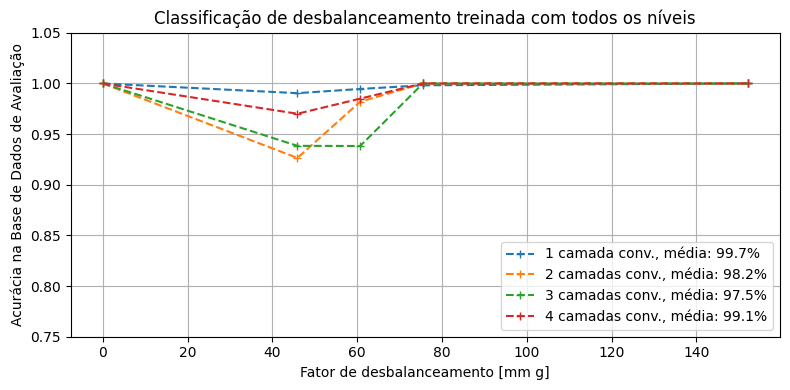

In [ ]:
fig=plt.figure(figsize=(8,4))
ax1=plt.subplot(111, title = "Classificação de desbalanceamento treinada com todos os níveis")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances, accuracies[0,:], label=f"1 camada conv., média: {100.0*accuracies_all[0]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[1,:], label=f"2 camadas conv., média: {100.0*accuracies_all[1]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[2,:], label=f"3 camadas conv., média: {100.0*accuracies_all[2]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[3,:], label=f"4 camadas conv., média: {100.0*accuracies_all[3]:.1f}%", marker="+", ls="--")
plt.ylabel("Acurácia na Base de Dados de Avaliação")
plt.xlabel("Fator de desbalanceamento [mm g]")
plt.legend(loc="lower right")
plt.ylim([0.75, 1.05])
plt.grid(True)
plt.tight_layout()
plt.show()

## Dependência da Velocidade de Rotação

In [ ]:
from tensorflow.keras.models import load_model

model1 = load_model(f"{model_path}/cnn_1_layers.h5")
model2 = load_model(f"{model_path}/cnn_2_layers.h5")
model3 = load_model(f"{model_path}/cnn_3_layers.h5")
model4 = load_model(f"{model_path}/cnn_4_layers.h5")

In [ ]:
def v2rpm(v):
    return 212*v + 209

from scipy.stats import mode
# 3s ramp up
fade_in = np.arange(0.0, 4.0, 4.0/(3*4096))
# complete voltage sweep
measurement_cycle = np.repeat(np.arange(4.0, 8.2, 0.1), 4096*20.0)
# measurement: start-up + 2 voltage sweeps
measurement = np.concatenate([fade_in, np.tile(measurement_cycle,3)])
# select the data as actually used
measurement1 = measurement[50000:]
measurement1 = measurement1[:int(len(measurement1)/4096)*4096].reshape(-1,4096)
voltages_measurement = mode(measurement1, axis=1)[0]
voltages_used = np.concatenate([voltages_measurement[:len(X_val_1)],
                                voltages_measurement[:len(X_val_2)],
                                voltages_measurement[:len(X_val_3)],
                                voltages_measurement[:len(X_val_4)],
                                voltages_measurement[:len(X_val_5)]])
rpms_used = v2rpm(voltages_used)

In [ ]:
rpm_borders = np.arange(1050, 1975, 25)
errors_per_rpm_range1 = []
errors_per_rpm_range2 = []
errors_per_rpm_range3 = []
errors_per_rpm_range4 = []
for i in range(len(rpm_borders)-1):
    eval_inds = np.where((rpms_used>rpm_borders[i])&(rpms_used<rpm_borders[i+1]))[0]
    errors_per_rpm_range1.append(
        1-np.mean(np.abs(np.int32(model1.predict(X_val[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range2.append(
        1-np.mean(np.abs(np.int32(model2.predict(X_val[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range3.append(
        1-np.mean(np.abs(np.int32(model3.predict(X_val[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range4.append(
        1-np.mean(np.abs(np.int32(model4.predict(X_val[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1

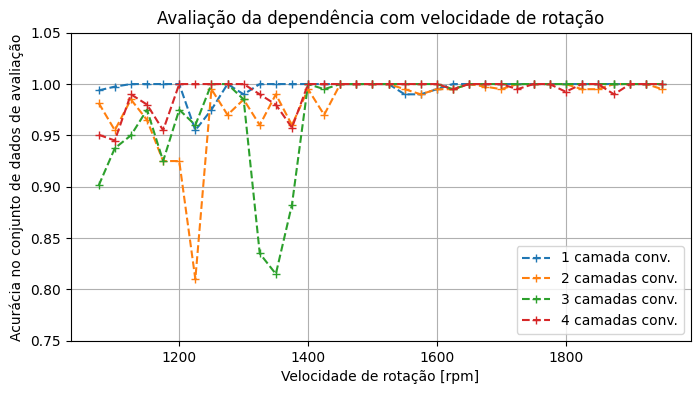

In [ ]:
fig=plt.figure(figsize=(8, 4))
ax1=plt.subplot(111, title = "Avaliação da dependência com velocidade de rotação")
ax1.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range1, marker="+", ls="--", label="1 camada conv.")
ax1.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range2, marker="+", ls="--", label="2 camadas conv.")
ax1.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range3, marker="+", ls="--", label="3 camadas conv.")
ax1.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range4, marker="+", ls="--", label="4 camadas conv.")
plt.ylabel("Acurácia no conjunto de dados de avaliação")
plt.xlabel("Velocidade de rotação [rpm]")
plt.legend(loc="lower right")
plt.ylim([0.75, 1.05])
plt.grid(True)
plt.show()

## Treinamento e Avaliação "Par-a-Par"

**Quando usar Domínio do Tempo**

In [ ]:
if SinaldeEntrada == 'TimeDomain':
  X_dev = [X0, X1, X2, X3, X4]
  y_dev = [y0, y1, y2, y3, y4]

  X_val_separated = [X_val_1, X_val_2, X_val_3, X_val_4, X_val_5]
  y_val_separated = [y0_val, y1_val, y2_val, y3_val, y4_val]

**Quando usar a FFT com 2048 amostras**

In [ ]:
if SinaldeEntrada == 'FrequencyDomain':
  if(janelamento):
    janela_hamming = np.hamming(window)
    X0 = X0*janela_hamming
    X1 = X1*janela_hamming
    X2 = X2*janela_hamming
    X3 = X3*janela_hamming
    X4 = X4*janela_hamming

  X0_fft = np.abs(np.fft.rfft(X0, axis=1))[:,:int(window/2)]
  X1_fft = np.abs(np.fft.rfft(X1, axis=1))[:,:int(window/2)]
  X2_fft = np.abs(np.fft.rfft(X2, axis=1))[:,:int(window/2)]
  X3_fft = np.abs(np.fft.rfft(X3, axis=1))[:,:int(window/2)]
  X4_fft = np.abs(np.fft.rfft(X4, axis=1))[:,:int(window/2)]

  X_dev = [X0_fft, X1_fft, X2_fft, X3_fft, X4_fft]
  y_dev = [y0, y1, y2, y3, y4]

  X_val_separated = [X_val_1, X_val_2, X_val_3, X_val_4, X_val_5]
  y_val_separated = [y0_val, y1_val, y2_val, y3_val, y4_val]

**Quando usar o Mod ES com 2048 amostras**

In [ ]:
if SinaldeEntrada == 'EnvelopeSpectrum':
  X0_modES = np.abs(np.fft.rfft(np.abs(signal.hilbert(X0)), axis=1))[:,:int(window/2)]
  X1_modES = np.abs(np.fft.rfft(np.abs(signal.hilbert(X1)), axis=1))[:,:int(window/2)]
  X2_modES = np.abs(np.fft.rfft(np.abs(signal.hilbert(X2)), axis=1))[:,:int(window/2)]
  X3_modES = np.abs(np.fft.rfft(np.abs(signal.hilbert(X3)), axis=1))[:,:int(window/2)]
  X4_modES = np.abs(np.fft.rfft(np.abs(signal.hilbert(X4)), axis=1))[:,:int(window/2)]

  X_dev = [X0_modES, X1_modES, X2_modES, X3_modES, X4_modES]
  y_dev = [y0, y1, y2, y3, y4]

  X_val_separated = [X_val_1, X_val_2, X_val_3, X_val_4, X_val_5]
  y_val_separated = [y0_val, y1_val, y2_val, y3_val, y4_val]

In [ ]:
X_val_i

array([[ 0.        , 16.69248351,  8.27521047, ..., -0.12097629,
        -0.11914982, -0.12794922],
       [ 0.        , 11.16944378,  5.49135371, ..., -0.13065246,
        -0.12460792, -0.13068532],
       [ 0.        ,  7.5883181 ,  3.74915315, ..., -0.12840724,
        -0.12725048, -0.11685026],
       ...,
       [ 0.        , -0.16668126, -0.1248524 , ..., -0.09248697,
        -0.11463585, -0.1136004 ],
       [ 0.        , -0.15200972, -0.10460144, ..., -0.09545245,
        -0.08871807, -0.09454957],
       [ 0.        , -0.14744068, -0.07604681, ..., -0.07263349,
        -0.11575811, -0.07434481]])

In [ ]:
for n_conv_layers in range(1,nMaxConvLayers+1):
    for dataset_i in range(4):
        X_dev_i = np.concatenate([X_dev[0], X_dev[dataset_i+1]])
        y_dev_i = np.concatenate([y_dev[0], y_dev[dataset_i+1]])
        X_val_i = np.concatenate([X_val_separated[0], X_val_separated[dataset_i+1]])
        y_val_i = np.concatenate([y_val_separated[0], y_val_separated[dataset_i+1]])

        train_test_ratio = 0.9
        X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
            X_dev_i,y_dev_i, test_size = 1-train_test_ratio, random_state = 0)
        X_train_i = np.reshape(X_train_i, (X_train_i.shape[0], X_train_i.shape[1], 1))
        X_test_i = np.reshape(X_test_i, (X_test_i.shape[0], X_test_i.shape[1], 1))
        # Reshape X_val_i to match the expected input shape:
        X_val_i = np.reshape(X_val_i, (X_val_i.shape[0], X_val_i.shape[1], 1)) #This line was added


        if not use_reference_models:
            weight_for_0 = len(y_dev_i)/(2*len(y_dev_i[y_dev_i==0]))
            weight_for_1 = len(y_dev_i)/(2*len(y_dev_i[y_dev_i==1]))
            class_weight = {0: weight_for_0, 1: weight_for_1}

            n_dense_units = 128
            dropout_rate = 0.0
            use_batch_normalization = True # [True, False]
            filter_size = 9 # [5,7,9]
            learning_rate = 0.0001
            n_epochs = 100 # [50,100,200]

            X_in = Input(shape=(X_train_i.shape[1],1))
            x = X_in
            for j in range(n_conv_layers):
                print(j)
                x = Conv1D(filters=(j+1)*10,
                           kernel_size=filter_size,
                           strides=1,
                           activation='linear',
                           kernel_initializer='he_uniform')(x)
                if use_batch_normalization:
                    x = BatchNormalization()(x)
                x = LeakyReLU(alpha=0.05)(x)
                x = MaxPooling1D(pool_size=5, strides=2)(x)
            x = Flatten()(x)
            x = Dense(units = n_dense_units, activation='linear')(x)
            x = ReLU()(x)
            x = Dropout(rate=dropout_rate)(x)
            X_out = Dense(units = 1, activation = 'sigmoid')(x)
            classifier = Model(X_in, X_out)

            best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers_dataset_pair_{dataset_i}.h5"
            checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss',
                                         verbose=1, save_best_only=True, mode='min')
            classifier.compile(optimizer = Adam(learning_rate=learning_rate), loss = 'binary_crossentropy',
                               metrics = ['accuracy'])
            classifier.summary()

            classifier.fit(X_train_i, y_train_i, epochs = n_epochs, batch_size = 128,
                       validation_data=(X_test_i, y_test_i), callbacks=[checkpoint],
                           class_weight=class_weight)

        best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers_dataset_pair_{dataset_i}.h5"
        classifier = load_model(best_model_filepath)
        train_acc = classifier.evaluate(X_train_i, y_train_i)
        val_acc = classifier.evaluate(X_val_i, y_val_i)
        print(f"Layers: {layer_n}, dataset pair {dataset_i}")
        print(train_acc)
        print(val_acc)

0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 10180)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     1,303,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,303,437 (4.97 MB)

 Trainable params: 1,303,417 (4.97 MB)

 Non-trainable params: 20 (80.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7932 - loss: 0.4389
Epoch 1: val_loss improved from inf to 0.19697, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7941 - loss: 0.4372 - val_accuracy: 0.9394 - val_loss: 0.1970
Epoch 2/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9386 - loss: 0.1584
Epoch 2: val_loss improved from 0.19697 to 0.14403, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9395 - loss: 0.1568 - val_accuracy: 0.9573 - val_loss: 0.1440
Epoch 3/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9570 - loss: 0.1260
Epoch 3: val_loss improved from 0.14403 to 0.10498, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9579 - loss: 0.1242 - val_accuracy: 0.9783 - val_loss: 0.1050
Epoch 4/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9727 - loss: 0.0979
Epoch 4: val_loss improved from 0.10498 to 0.08174, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9722 - loss: 0.0978 - val_accuracy: 0.9728 - val_loss: 0.0817
Epoch 5/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9833 - loss: 0.0763
Epoch 5: val_loss improved from 0.08174 to 0.06313, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9842 - loss: 0.0754 - val_accuracy: 0.9876 - val_loss: 0.0631
Epoch 6/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9930 - loss: 0.0603
Epoch 6: val_loss improved from 0.06313 to 0.04993, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9930 - loss: 0.0602 - val_accuracy: 0.9961 - val_loss: 0.0499
Epoch 7/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0488
Epoch 7: val_loss improved from 0.04993 to 0.04192, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9970 - loss: 0.0485 - val_accuracy: 0.9984 - val_loss: 0.0419
Epoch 8/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.0424
Epoch 8: val_loss improved from 0.04192 to 0.03315, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0420 - val_accuracy: 0.9992 - val_loss: 0.0332
Epoch 9/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0341
Epoch 9: val_loss improved from 0.03315 to 0.02883, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9978 - loss: 0.0339 - val_accuracy: 0.9992 - val_loss: 0.0288
Epoch 10/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0288
Epoch 10: val_loss improved from 0.02883 to 0.02809, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0288 - val_accuracy: 0.9961 - val_loss: 0.0281
Epoch 11/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0248
Epoch 11: val_loss improved from 0.02809 to 0.02694, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0247 - val_accuracy: 0.9961 - val_loss: 0.0269
Epoch 12/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0213
Epoch 12: val_loss improved from 0.02694 to 0.01982, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0213 - val_accuracy: 0.9992 - val_loss: 0.0198
Epoch 13/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0208
Epoch 13: val_loss improved from 0.01982 to 0.01859, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0206 - val_accuracy: 0.9992 - val_loss: 0.0186
Epoch 14/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0176
Epoch 14: val_loss did not improve from 0.01859
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0175 - val_accuracy: 0.9977 - val_loss: 0.0189
Epoch 15/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0150
Epoch 15: val_loss improved from 0.01859 to 0.01465, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0149 - val_accuracy: 0.9992 - val_loss: 0.0147
Epoch 16/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0144
Epoch 16: val_loss did not improve from 0.01465
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0142 - val_accuracy: 0.9938 - val_loss: 0.0225
Epoch 17/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0127
Epoch 17: val_loss did not improve from 0.01465
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0126 - val_accuracy: 0.9992 - val_loss: 0.0167
Epoch 18/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0109
Epoch 18: val_loss did not improve from 0.01465
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0109 - val_accuracy: 0.9992 - val_loss: 0.0173
Epoch 19/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0120
Epoch 19: val_loss improved from 0.01465 to 0.01351,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0117 - val_accuracy: 0.9984 - val_loss: 0.0135
Epoch 20/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0079
Epoch 20: val_loss did not improve from 0.01351
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.9992 - val_loss: 0.0151
Epoch 21/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0071
Epoch 21: val_loss improved from 0.01351 to 0.01239, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.9992 - val_loss: 0.0124
Epoch 22/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0063
Epoch 22: val_loss did not improve from 0.01239
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.9992 - val_loss: 0.0164
Epoch 23/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0056
Epoch 23: val_loss did not improve from 0.01239
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9984 - val_loss: 0.0126
Epoch 24/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0058
Epoch 24: val_loss improved from 0.01239 to 0.01057, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9992 - val_loss: 0.0106
Epoch 25/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0049
Epoch 25: val_loss did not improve from 0.01057
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9992 - val_loss: 0.0120
Epoch 26/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0049
Epoch 26: val_loss improved from 0.01057 to 0.00997, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.9992 - val_loss: 0.0100
Epoch 27/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0045
Epoch 27: val_loss did not improve from 0.00997
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.9992 - val_loss: 0.0102
Epoch 28/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0037
Epoch 28: val_loss improved from 0.00997 to 0.00988, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9992 - val_loss: 0.0099
Epoch 29/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0034
Epoch 29: val_loss did not improve from 0.00988
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9992 - val_loss: 0.0112
Epoch 30/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0032
Epoch 30: val_loss did not improve from 0.00988
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9992 - val_loss: 0.0102
Epoch 31/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0031
Epoch 31: val_loss did not improve from 0.00988
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9992 - val_loss: 0.0108
Epoch 32/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 32: val_loss improved from 0.00988 to 0.00939,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9992 - val_loss: 0.0094
Epoch 33/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 33: val_loss improved from 0.00939 to 0.00853, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9992 - val_loss: 0.0085
Epoch 34/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 34: val_loss did not improve from 0.00853
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9992 - val_loss: 0.0106
Epoch 35/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 35: val_loss did not improve from 0.00853
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9992 - val_loss: 0.0090
Epoch 36/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 36: val_loss did not improve from 0.00853
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9992 - val_loss: 0.0088
Epoch 37/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 37: val_loss did not improve from 0.00853
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9992 - val_loss: 0.0080
Epoch 43/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 43: val_loss did not improve from 0.00802
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9992 - val_loss: 0.0099
Epoch 44/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 44: val_loss did not improve from 0.00802
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9992 - val_loss: 0.0083
Epoch 45/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 45: val_loss did not improve from 0.00802
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9992 - val_loss: 0.0101
Epoch 46/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 46: val_loss did not improve from 0.00802
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.0897e-04 - val_accuracy: 0.9992 - val_loss: 0.0078
Epoch 49/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.6316e-04
Epoch 49: val_loss did not improve from 0.00776
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.6612e-04 - val_accuracy: 0.9992 - val_loss: 0.0097
Epoch 50/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.2108e-04
Epoch 50: val_loss did not improve from 0.00776
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.1898e-04 - val_accuracy: 0.9992 - val_loss: 0.0097
Epoch 51/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.2800e-04
Epoch 51: val_loss did not improve from 0.00776
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.1454e-04 - val_accuracy: 0.9992 - val_loss: 0.0082
Epoch 52/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.0855e-04
Epoch 52: val_loss d

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.5358e-04 - val_accuracy: 0.9992 - val_loss: 0.0078
Epoch 54/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.1764e-04
Epoch 54: val_loss did not improve from 0.00776
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.0150e-04 - val_accuracy: 0.9992 - val_loss: 0.0086
Epoch 55/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.9022e-04
Epoch 55: val_loss improved from 0.00776 to 0.00758, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.9145e-04 - val_accuracy: 0.9992 - val_loss: 0.0076
Epoch 56/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.1298e-04
Epoch 56: val_loss did not improve from 0.00758
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.2073e-04 - val_accuracy: 0.9992 - val_loss: 0.0099
Epoch 57/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.7831e-04
Epoch 57: val_loss did not improve from 0.00758
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.7496e-04 - val_accuracy: 0.9992 - val_loss: 0.0089
Epoch 58/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.5636e-04
Epoch 58: val_loss improved from 0.00758 to 0.00671, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.5801e-04 - val_accuracy: 0.9992 - val_loss: 0.0067
Epoch 59/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.8313e-04
Epoch 59: val_loss did not improve from 0.00671
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.8088e-04 - val_accuracy: 0.9992 - val_loss: 0.0089
Epoch 60/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.0321e-04
Epoch 60: val_loss did not improve from 0.00671
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.0820e-04 - val_accuracy: 0.9992 - val_loss: 0.0082
Epoch 61/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.9430e-04
Epoch 61: val_loss did not improve from 0.00671
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0020 - val_accuracy: 0.9977 - val_loss: 0.0106
Epoch 62/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0092
Epoch 62: val_loss did not i

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3189e-04 - val_accuracy: 0.9992 - val_loss: 0.0065
Epoch 95/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9122e-04
Epoch 95: val_loss did not improve from 0.00650
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9366e-04 - val_accuracy: 0.9992 - val_loss: 0.0066
Epoch 96/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9056e-04
Epoch 96: val_loss did not improve from 0.00650
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9119e-04 - val_accuracy: 0.9992 - val_loss: 0.0068
Epoch 97/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.8799e-04
Epoch 97: val_loss improved from 0.00650 to 0.00625, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.8835e-04 - val_accuracy: 0.9992 - val_loss: 0.0062
Epoch 98/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9405e-04
Epoch 98: val_loss did not improve from 0.00625
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9219e-04 - val_accuracy: 0.9992 - val_loss: 0.0068
Epoch 99/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.6511e-04
Epoch 99: val_loss improved from 0.00625 to 0.00593, saving model to ../models/reference/cnn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.6769e-04 - val_accuracy: 0.9992 - val_loss: 0.0059
Epoch 100/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.6507e-04
Epoch 100: val_loss did not improve from 0.00593
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.6471e-04 - val_accuracy: 0.9992 - val_loss: 0.0061


362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.6688e-04
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8239 - loss: 4.2457
Layers: 5, dataset pair 0
[0.00016215629875659943, 1.0]
[12.454032897949219, 0.5426263809204102]
0


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 10180)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     1,303,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,303,437 (4.97 MB)

 Trainable params: 1,303,417 (4.97 MB)

 Non-trainable params: 20 (80.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7611 - loss: 0.4623
Epoch 1: val_loss improved from inf to 0.20501, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7620 - loss: 0.4607 - val_accuracy: 0.9076 - val_loss: 0.2050
Epoch 2/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9128 - loss: 0.1983
Epoch 2: val_loss improved from 0.20501 to 0.16869, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9136 - loss: 0.1973 - val_accuracy: 0.9418 - val_loss: 0.1687
Epoch 3/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9288 - loss: 0.1692
Epoch 3: val_loss improved from 0.16869 to 0.14396, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9290 - loss: 0.1686 - val_accuracy: 0.9371 - val_loss: 0.1440
Epoch 4/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9431 - loss: 0.1414
Epoch 4: val_loss improved from 0.14396 to 0.12435, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9437 - loss: 0.1407 - val_accuracy: 0.9767 - val_loss: 0.1243
Epoch 5/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9628 - loss: 0.1216
Epoch 5: val_loss improved from 0.12435 to 0.11733, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9630 - loss: 0.1210 - val_accuracy: 0.9332 - val_loss: 0.1173
Epoch 6/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9715 - loss: 0.1054
Epoch 6: val_loss improved from 0.11733 to 0.10348, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9717 - loss: 0.1050 - val_accuracy: 0.9425 - val_loss: 0.1035
Epoch 7/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9692 - loss: 0.0962
Epoch 7: val_loss improved from 0.10348 to 0.07766, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9701 - loss: 0.0957 - val_accuracy: 0.9860 - val_loss: 0.0777
Epoch 8/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0785
Epoch 8: val_loss improved from 0.07766 to 0.06687, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9875 - loss: 0.0778 - val_accuracy: 0.9930 - val_loss: 0.0669
Epoch 9/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9909 - loss: 0.0646
Epoch 9: val_loss improved from 0.06687 to 0.06298, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9909 - loss: 0.0644 - val_accuracy: 0.9790 - val_loss: 0.0630
Epoch 10/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9914 - loss: 0.0578
Epoch 10: val_loss improved from 0.06298 to 0.04917, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9916 - loss: 0.0575 - val_accuracy: 0.9977 - val_loss: 0.0492
Epoch 11/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9969 - loss: 0.0475
Epoch 11: val_loss improved from 0.04917 to 0.04704, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9968 - loss: 0.0473 - val_accuracy: 0.9884 - val_loss: 0.0470
Epoch 12/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9941 - loss: 0.0412
Epoch 12: val_loss improved from 0.04704 to 0.03519, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9943 - loss: 0.0409 - val_accuracy: 0.9984 - val_loss: 0.0352
Epoch 13/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9970 - loss: 0.0342
Epoch 13: val_loss did not improve from 0.03519
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - loss: 0.0340 - val_accuracy: 0.9961 - val_loss: 0.0379
Epoch 14/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0298
Epoch 14: val_loss improved from 0.03519 to 0.02568, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0296 - val_accuracy: 0.9992 - val_loss: 0.0257
Epoch 15/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0249
Epoch 15: val_loss improved from 0.02568 to 0.02450, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0249 - val_accuracy: 0.9992 - val_loss: 0.0245
Epoch 16/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0238
Epoch 16: val_loss improved from 0.02450 to 0.01952, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9990 - loss: 0.0236 - val_accuracy: 0.9992 - val_loss: 0.0195
Epoch 17/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0197
Epoch 17: val_loss improved from 0.01952 to 0.01740, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0196 - val_accuracy: 0.9992 - val_loss: 0.0174
Epoch 18/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0166
Epoch 18: val_loss improved from 0.01740 to 0.01601, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0166 - val_accuracy: 0.9992 - val_loss: 0.0160
Epoch 19/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0162
Epoch 19: val_loss improved from 0.01601 to 0.01406, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0161 - val_accuracy: 0.9992 - val_loss: 0.0141
Epoch 20/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0141
Epoch 20: val_loss improved from 0.01406 to 0.01259, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0140 - val_accuracy: 1.0000 - val_loss: 0.0126
Epoch 21/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0121
Epoch 21: val_loss improved from 0.01259 to 0.01135, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0121 - val_accuracy: 0.9992 - val_loss: 0.0114
Epoch 22/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0105
Epoch 22: val_loss improved from 0.01135 to 0.01133, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0105 - val_accuracy: 0.9992 - val_loss: 0.0113
Epoch 23/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0092
Epoch 23: val_loss improved from 0.01133 to 0.00931, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 24/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0091
Epoch 24: val_loss improved from 0.00931 to 0.00873, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0090 - val_accuracy: 0.9992 - val_loss: 0.0087
Epoch 25/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0082
Epoch 25: val_loss improved from 0.00873 to 0.00736, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.0074
Epoch 26/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0067
Epoch 26: val_loss improved from 0.00736 to 0.00698, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 27/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0065
Epoch 27: val_loss improved from 0.00698 to 0.00630, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 28/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0055
Epoch 28: val_loss improved from 0.00630 to 0.00585, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 29/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0061
Epoch 29: val_loss did not improve from 0.00585
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.9992 - val_loss: 0.0108
Epoch 30/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0054
Epoch 30: val_loss improved from 0.00585 to 0.00548, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 31/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0045
Epoch 31: val_loss improved from 0.00548 to 0.00454, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 32/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0045
Epoch 32: val_loss did not improve from 0.00454
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 33/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0039
Epoch 33: val_loss improved from 0.00454 to 0.00441, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 34/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0039
Epoch 34: val_loss improved from 0.00441 to 0.00421, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 35/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0037
Epoch 35: val_loss did not improve from 0.00421
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0037 - val_accuracy: 0.9992 - val_loss: 0.0053
Epoch 36/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0038
Epoch 36: val_loss improved from 0.00421 to 0.00369, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 37/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0039
Epoch 37: val_loss improved from 0.00369 to 0.00327, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 38/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0029
Epoch 38: val_loss improved from 0.00327 to 0.00302, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 39/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0026
Epoch 39: val_loss did not improve from 0.00302
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 40/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 40: val_loss did not improve from 0.00302
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 41/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 41: val_loss did not improve from 0.00302
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9984 - val_loss: 0.0041
Epoch 42/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 42: val_loss improved from 0.00302 to 0.00297,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 43/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 43: val_loss improved from 0.00297 to 0.00269, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 44/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 44: val_loss did not improve from 0.00269
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9992 - val_loss: 0.0031
Epoch 45/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 45: val_loss did not improve from 0.00269
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9984 - val_loss: 0.0052
Epoch 46/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 46: val_loss did not improve from 0.00269
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9984 - val_loss: 0.0032
Epoch 47/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 47: val_loss improved from 0.00269 to 0.00243,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 48/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 48: val_loss did not improve from 0.00243
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9984 - val_loss: 0.0039
Epoch 49/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 49: val_loss improved from 0.00243 to 0.00205, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 50/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 50: val_loss did not improve from 0.00205
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9984 - val_loss: 0.0033
Epoch 51/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 51: val_loss did not improve from 0.00205
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9992 - val_loss: 0.0023
Epoch 52/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 52: val_loss did not improve from 0.00205
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 53/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 53: val_loss did not improve from 0.00205
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.8953e-04 - val_accuracy: 0.9992 - val_loss: 0.0018
Epoch 59/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.0299e-04
Epoch 59: val_loss did not improve from 0.00179
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.0139e-04 - val_accuracy: 0.9984 - val_loss: 0.0034
Epoch 60/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.1696e-04
Epoch 60: val_loss did not improve from 0.00179
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.0974e-04 - val_accuracy: 0.9992 - val_loss: 0.0025
Epoch 61/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.8768e-04
Epoch 61: val_loss did not improve from 0.00179
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.8174e-04 - val_accuracy: 0.9984 - val_loss: 0.0056
Epoch 62/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.2516e-04
Epoch 62: val_loss d

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9980 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 6.3019e-04
Epoch 82/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2905e-04
Epoch 82: val_loss improved from 0.00063 to 0.00052, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3069e-04 - val_accuracy: 1.0000 - val_loss: 5.1585e-04
Epoch 83/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5912e-04
Epoch 83: val_loss did not improve from 0.00052
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5799e-04 - val_accuracy: 1.0000 - val_loss: 6.7150e-04
Epoch 84/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5186e-04
Epoch 84: val_loss did not improve from 0.00052
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4778e-04 - val_accuracy: 1.0000 - val_loss: 5.6521e-04
Epoch 85/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7790e-04
Epoch 85: val_loss did not improve from 0.00052
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7890e-04 - val_accuracy: 1.0000 - val_loss: 5.3921e-04
Epoch 86/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9953e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7589e-04 - val_accuracy: 1.0000 - val_loss: 5.1019e-04
Epoch 91/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.0591e-04
Epoch 91: val_loss improved from 0.00051 to 0.00048, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0418e-04 - val_accuracy: 1.0000 - val_loss: 4.7795e-04
Epoch 92/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.8743e-04
Epoch 92: val_loss improved from 0.00048 to 0.00045, saving model to ../models/reference/cnn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.8559e-04 - val_accuracy: 1.0000 - val_loss: 4.5271e-04
Epoch 93/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.4006e-04
Epoch 93: val_loss did not improve from 0.00045
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.3004e-04 - val_accuracy: 1.0000 - val_loss: 4.5355e-04
Epoch 94/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.8923e-04
Epoch 94: val_loss did not improve from 0.00045
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9003e-04 - val_accuracy: 1.0000 - val_loss: 5.9421e-04
Epoch 95/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2810e-04
Epoch 95: val_loss did not improve from 0.00045
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2334e-04 - val_accuracy: 1.0000 - val_loss: 6.5491e-04
Epoch 96/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4086e-04
Epoc

362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.5330e-04
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9228 - loss: 0.9216
Layers: 5, dataset pair 1
[0.00014904828276485205, 1.0]
[2.4751663208007812, 0.8173105716705322]
0


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 10180)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     1,303,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,303,437 (4.97 MB)

 Trainable params: 1,303,417 (4.97 MB)

 Non-trainable params: 20 (80.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7117 - loss: 0.5332
Epoch 1: val_loss improved from inf to 0.29704, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7127 - loss: 0.5316 - val_accuracy: 0.8765 - val_loss: 0.2970
Epoch 2/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9151 - loss: 0.2304
Epoch 2: val_loss improved from 0.29704 to 0.20245, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9148 - loss: 0.2290 - val_accuracy: 0.9270 - val_loss: 0.2024
Epoch 3/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9378 - loss: 0.1764
Epoch 3: val_loss improved from 0.20245 to 0.15620, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9375 - loss: 0.1760 - val_accuracy: 0.9363 - val_loss: 0.1562
Epoch 4/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9459 - loss: 0.1456
Epoch 4: val_loss improved from 0.15620 to 0.13219, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9460 - loss: 0.1452 - val_accuracy: 0.9441 - val_loss: 0.1322
Epoch 5/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9533 - loss: 0.1260
Epoch 5: val_loss improved from 0.13219 to 0.11755, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9536 - loss: 0.1257 - val_accuracy: 0.9409 - val_loss: 0.1175
Epoch 6/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9619 - loss: 0.1079
Epoch 6: val_loss improved from 0.11755 to 0.10279, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9619 - loss: 0.1078 - val_accuracy: 0.9487 - val_loss: 0.1028
Epoch 7/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9676 - loss: 0.0955
Epoch 7: val_loss improved from 0.10279 to 0.09893, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9676 - loss: 0.0957 - val_accuracy: 0.9417 - val_loss: 0.0989
Epoch 8/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9718 - loss: 0.0922
Epoch 8: val_loss improved from 0.09893 to 0.08114, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9721 - loss: 0.0916 - val_accuracy: 0.9713 - val_loss: 0.0811
Epoch 9/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9823 - loss: 0.0775
Epoch 9: val_loss improved from 0.08114 to 0.07087, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9821 - loss: 0.0773 - val_accuracy: 0.9829 - val_loss: 0.0709
Epoch 10/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9792 - loss: 0.0717
Epoch 10: val_loss improved from 0.07087 to 0.06455, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9794 - loss: 0.0716 - val_accuracy: 0.9992 - val_loss: 0.0646
Epoch 11/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9878 - loss: 0.0616
Epoch 11: val_loss did not improve from 0.06455
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9880 - loss: 0.0616 - val_accuracy: 0.9705 - val_loss: 0.0676
Epoch 12/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9839 - loss: 0.0609
Epoch 12: val_loss improved from 0.06455 to 0.05609, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9841 - loss: 0.0607 - val_accuracy: 0.9814 - val_loss: 0.0561
Epoch 13/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9860 - loss: 0.0559
Epoch 13: val_loss did not improve from 0.05609
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9863 - loss: 0.0555 - val_accuracy: 0.9736 - val_loss: 0.0585
Epoch 14/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9904 - loss: 0.0515
Epoch 14: val_loss improved from 0.05609 to 0.04681, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9905 - loss: 0.0512 - val_accuracy: 0.9852 - val_loss: 0.0468
Epoch 15/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9907 - loss: 0.0443
Epoch 15: val_loss improved from 0.04681 to 0.04106, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9908 - loss: 0.0443 - val_accuracy: 1.0000 - val_loss: 0.0411
Epoch 16/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9961 - loss: 0.0416
Epoch 16: val_loss improved from 0.04106 to 0.03861, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9961 - loss: 0.0412 - val_accuracy: 0.9992 - val_loss: 0.0386
Epoch 17/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9949 - loss: 0.0395
Epoch 17: val_loss improved from 0.03861 to 0.03438, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9946 - loss: 0.0395 - val_accuracy: 0.9984 - val_loss: 0.0344
Epoch 18/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0345
Epoch 18: val_loss did not improve from 0.03438
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - loss: 0.0345 - val_accuracy: 0.9946 - val_loss: 0.0382
Epoch 19/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.0345
Epoch 19: val_loss improved from 0.03438 to 0.03007, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9941 - loss: 0.0342 - val_accuracy: 0.9984 - val_loss: 0.0301
Epoch 20/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0284
Epoch 20: val_loss improved from 0.03007 to 0.02732, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9982 - loss: 0.0284 - val_accuracy: 1.0000 - val_loss: 0.0273
Epoch 21/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0263
Epoch 21: val_loss improved from 0.02732 to 0.02535, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0262 - val_accuracy: 1.0000 - val_loss: 0.0254
Epoch 22/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0241
Epoch 22: val_loss did not improve from 0.02535
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0242 - val_accuracy: 0.9883 - val_loss: 0.0376
Epoch 23/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0238
Epoch 23: val_loss improved from 0.02535 to 0.02433, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0236 - val_accuracy: 0.9984 - val_loss: 0.0243
Epoch 24/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0218
Epoch 24: val_loss improved from 0.02433 to 0.02309, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0218 - val_accuracy: 0.9984 - val_loss: 0.0231
Epoch 25/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0206
Epoch 25: val_loss improved from 0.02309 to 0.01913, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0206 - val_accuracy: 1.0000 - val_loss: 0.0191
Epoch 26/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0184
Epoch 26: val_loss did not improve from 0.01913
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0184 - val_accuracy: 0.9977 - val_loss: 0.0227
Epoch 27/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0179
Epoch 27: val_loss improved from 0.01913 to 0.01647, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0178 - val_accuracy: 1.0000 - val_loss: 0.0165
Epoch 28/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0155
Epoch 28: val_loss improved from 0.01647 to 0.01548, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0156 - val_accuracy: 1.0000 - val_loss: 0.0155
Epoch 29/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0165
Epoch 29: val_loss improved from 0.01548 to 0.01456, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0163 - val_accuracy: 1.0000 - val_loss: 0.0146
Epoch 30/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0136
Epoch 30: val_loss improved from 0.01456 to 0.01422, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 0.0142
Epoch 31/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0145
Epoch 31: val_loss did not improve from 0.01422
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0144 - val_accuracy: 0.9984 - val_loss: 0.0166
Epoch 32/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0127
Epoch 32: val_loss improved from 0.01422 to 0.01209, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.0121
Epoch 33/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0107
Epoch 33: val_loss did not improve from 0.01209
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0108 - val_accuracy: 0.9984 - val_loss: 0.0142
Epoch 34/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0106
Epoch 34: val_loss improved from 0.01209 to 0.01000, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0106 - val_accuracy: 1.0000 - val_loss: 0.0100
Epoch 35/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0097
Epoch 35: val_loss improved from 0.01000 to 0.00941, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 0.0094
Epoch 36/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0088
Epoch 36: val_loss did not improve from 0.00941
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.9969 - val_loss: 0.0171
Epoch 37/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0092
Epoch 37: val_loss improved from 0.00941 to 0.00833, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 38/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0079
Epoch 38: val_loss improved from 0.00833 to 0.00809, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 0.0081
Epoch 39/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0094
Epoch 39: val_loss did not improve from 0.00809
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0094 - val_accuracy: 0.9992 - val_loss: 0.0104
Epoch 40/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0062
Epoch 40: val_loss improved from 0.00809 to 0.00693, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 41/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0065
Epoch 41: val_loss did not improve from 0.00693
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 42/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0055
Epoch 42: val_loss improved from 0.00693 to 0.00604, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 0.0060
Epoch 43/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0068
Epoch 43: val_loss improved from 0.00604 to 0.00580, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 44/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0051
Epoch 44: val_loss improved from 0.00580 to 0.00538, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 45/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0044
Epoch 45: val_loss improved from 0.00538 to 0.00523, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 46/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0046
Epoch 46: val_loss did not improve from 0.00523
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.9992 - val_loss: 0.0087
Epoch 47/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0048
Epoch 47: val_loss did not improve from 0.00523
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 48/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0046
Epoch 48: val_loss improved from 0.00523 to 0.00420, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 49/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0039
Epoch 49: val_loss improved from 0.00420 to 0.00414, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 50/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0037
Epoch 50: val_loss improved from 0.00414 to 0.00395, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 51/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0036
Epoch 51: val_loss did not improve from 0.00395
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 52/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0043
Epoch 52: val_loss improved from 0.00395 to 0.00343, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 53/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0026
Epoch 53: val_loss did not improve from 0.00343
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9992 - val_loss: 0.0066
Epoch 54/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0044
Epoch 54: val_loss did not improve from 0.00343
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 55/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0032
Epoch 55: val_loss improved from 0.00343 to 0.00304, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 56/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 56: val_loss did not improve from 0.00304
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 57/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0031
Epoch 57: val_loss did not improve from 0.00304
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 58/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0029
Epoch 58: val_loss improved from 0.00304 to 0.00236, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 59/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 59: val_loss did not improve from 0.00236
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 60/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 60: val_loss did not improve from 0.00236
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 61/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0025
Epoch 61: val_loss improved from 0.00236 to 0.00210, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 62/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 62: val_loss did not improve from 0.00210
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9992 - val_loss: 0.0031
Epoch 63/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 63: val_loss did not improve from 0.00210
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 64/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 64: val_loss did not improve from 0.00210
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 65/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0116
Epoch 65: val_loss improved from 0.00210 to 0.00196,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9966 - loss: 0.0115 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 66/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 66: val_loss improved from 0.00196 to 0.00161, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 67/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 67: val_loss improved from 0.00161 to 0.00156, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 68/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 68: val_loss improved from 0.00156 to 0.00151, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 69/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 69: val_loss improved from 0.00151 to 0.00142, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 70/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 70: val_loss improved from 0.00142 to 0.00135, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 71/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 71: val_loss improved from 0.00135 to 0.00128, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 72/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0010    
Epoch 72: val_loss improved from 0.00128 to 0.00124, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 73/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 73: val_loss improved from 0.00124 to 0.00118, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 74/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 74: val_loss did not improve from 0.00118
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 75/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 75: val_loss did not improve from 0.00118
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 76/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 76: val_loss improved from 0.00118 to 0.00112, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 77/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.7857e-04
Epoch 77: val_loss improved from 0.00112 to 0.00101, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.8926e-04 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 78/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.8386e-04
Epoch 78: val_loss did not improve from 0.00101
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.0246e-04 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 79/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.7120e-04
Epoch 79: val_loss did not improve from 0.00101
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.6585e-04 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 80/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.6468e-04
Epoch 80: val_loss did not improve from 0.00101
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.4619e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 81/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.3757e-04
Epoch 81: val_loss i

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.3972e-04 - val_accuracy: 1.0000 - val_loss: 9.3453e-04
Epoch 82/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.7156e-04
Epoch 82: val_loss improved from 0.00093 to 0.00079, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.8977e-04 - val_accuracy: 1.0000 - val_loss: 7.8905e-04
Epoch 83/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.9148e-04
Epoch 83: val_loss did not improve from 0.00079
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.9446e-04 - val_accuracy: 1.0000 - val_loss: 8.7926e-04
Epoch 84/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.1494e-04
Epoch 84: val_loss improved from 0.00079 to 0.00076, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.2759e-04 - val_accuracy: 1.0000 - val_loss: 7.6053e-04
Epoch 85/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.7685e-04
Epoch 85: val_loss did not improve from 0.00076
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.7253e-04 - val_accuracy: 1.0000 - val_loss: 8.3450e-04
Epoch 86/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.9545e-04
Epoch 86: val_loss did not improve from 0.00076
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.0586e-04 - val_accuracy: 1.0000 - val_loss: 9.1325e-04
Epoch 87/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.5570e-04
Epoch 87: val_loss did not improve from 0.00076
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.6077e-04 - val_accuracy: 1.0000 - val_loss: 8.6261e-04
Epoch 88/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.6895e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.5441e-04 - val_accuracy: 1.0000 - val_loss: 6.7476e-04
Epoch 89/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.8677e-04
Epoch 89: val_loss improved from 0.00067 to 0.00066, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.8776e-04 - val_accuracy: 1.0000 - val_loss: 6.5586e-04
Epoch 90/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.9321e-04
Epoch 90: val_loss did not improve from 0.00066
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.8993e-04 - val_accuracy: 1.0000 - val_loss: 6.7633e-04
Epoch 91/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.4897e-04
Epoch 91: val_loss improved from 0.00066 to 0.00058, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.4602e-04 - val_accuracy: 1.0000 - val_loss: 5.8054e-04
Epoch 92/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.6846e-04
Epoch 92: val_loss did not improve from 0.00058
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.7517e-04 - val_accuracy: 1.0000 - val_loss: 5.9265e-04
Epoch 93/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.5894e-04
Epoch 93: val_loss did not improve from 0.00058
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.6529e-04 - val_accuracy: 1.0000 - val_loss: 7.0334e-04
Epoch 94/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.1081e-04
Epoch 94: val_loss improved from 0.00058 to 0.00058, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.1140e-04 - val_accuracy: 1.0000 - val_loss: 5.7900e-04
Epoch 95/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.3636e-04
Epoch 95: val_loss improved from 0.00058 to 0.00055, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.2049e-04 - val_accuracy: 1.0000 - val_loss: 5.4867e-04
Epoch 96/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.6587e-04
Epoch 96: val_loss improved from 0.00055 to 0.00045, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.6751e-04 - val_accuracy: 1.0000 - val_loss: 4.5447e-04
Epoch 97/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.6797e-04
Epoch 97: val_loss did not improve from 0.00045
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.7315e-04 - val_accuracy: 1.0000 - val_loss: 8.1520e-04
Epoch 98/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.4867e-04
Epoch 98: val_loss did not improve from 0.00045
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.4424e-04 - val_accuracy: 1.0000 - val_loss: 9.3815e-04
Epoch 99/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.4769e-04
Epoch 99: val_loss improved from 0.00045 to 0.00042, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.4087e-04 - val_accuracy: 1.0000 - val_loss: 4.1979e-04
Epoch 100/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2158e-04
Epoch 100: val_loss improved from 0.00042 to 0.00038, saving model to ../models/reference/cnn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2059e-04 - val_accuracy: 1.0000 - val_loss: 3.7899e-04


362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.0113e-04
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8453 - loss: 6.2723
Layers: 5, dataset pair 2
[0.00027636837330646813, 1.0]
[21.224924087524414, 0.5104727745056152]
0


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 10180)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │     1,303,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,303,437 (4.97 MB)

 Trainable params: 1,303,417 (4.97 MB)

 Non-trainable params: 20 (80.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8364 - loss: 0.3555
Epoch 1: val_loss improved from inf to 0.14789, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8372 - loss: 0.3542 - val_accuracy: 0.9736 - val_loss: 0.1479
Epoch 2/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9556 - loss: 0.1218
Epoch 2: val_loss improved from 0.14789 to 0.10445, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9559 - loss: 0.1205 - val_accuracy: 0.9441 - val_loss: 0.1045
Epoch 3/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9681 - loss: 0.0887
Epoch 3: val_loss improved from 0.10445 to 0.07168, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9686 - loss: 0.0878 - val_accuracy: 0.9806 - val_loss: 0.0717
Epoch 4/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9778 - loss: 0.0693
Epoch 4: val_loss improved from 0.07168 to 0.05774, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9781 - loss: 0.0684 - val_accuracy: 0.9767 - val_loss: 0.0577
Epoch 5/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9830 - loss: 0.0546
Epoch 5: val_loss improved from 0.05774 to 0.05210, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9834 - loss: 0.0537 - val_accuracy: 0.9992 - val_loss: 0.0521
Epoch 6/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9898 - loss: 0.0417
Epoch 6: val_loss improved from 0.05210 to 0.03101, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9899 - loss: 0.0411 - val_accuracy: 0.9961 - val_loss: 0.0310
Epoch 7/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9923 - loss: 0.0303
Epoch 7: val_loss improved from 0.03101 to 0.02723, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9925 - loss: 0.0303 - val_accuracy: 0.9899 - val_loss: 0.0272
Epoch 8/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9948 - loss: 0.0267
Epoch 8: val_loss improved from 0.02723 to 0.02035, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9950 - loss: 0.0264 - val_accuracy: 1.0000 - val_loss: 0.0204
Epoch 9/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9963 - loss: 0.0212
Epoch 9: val_loss improved from 0.02035 to 0.01683, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9962 - loss: 0.0212 - val_accuracy: 1.0000 - val_loss: 0.0168
Epoch 10/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0173
Epoch 10: val_loss improved from 0.01683 to 0.01435, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9989 - loss: 0.0173 - val_accuracy: 1.0000 - val_loss: 0.0143
Epoch 11/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0144
Epoch 11: val_loss improved from 0.01435 to 0.01415, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0144 - val_accuracy: 1.0000 - val_loss: 0.0142
Epoch 12/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0140
Epoch 12: val_loss improved from 0.01415 to 0.01139, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.0114
Epoch 13/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.0114
Epoch 13: val_loss improved from 0.01139 to 0.00871, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9979 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 0.0087
Epoch 14/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0097
Epoch 14: val_loss improved from 0.00871 to 0.00798, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.0080
Epoch 15/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0088
Epoch 15: val_loss improved from 0.00798 to 0.00697, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 16/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0070
Epoch 16: val_loss improved from 0.00697 to 0.00570, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 17/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0064
Epoch 17: val_loss improved from 0.00570 to 0.00547, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 18/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0060
Epoch 18: val_loss improved from 0.00547 to 0.00447, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 19/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0043
Epoch 19: val_loss improved from 0.00447 to 0.00405, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 20/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0044
Epoch 20: val_loss improved from 0.00405 to 0.00376, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 21/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0041
Epoch 21: val_loss improved from 0.00376 to 0.00327, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 22/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0032
Epoch 22: val_loss improved from 0.00327 to 0.00317, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 23/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 23: val_loss improved from 0.00317 to 0.00251, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 24/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 24: val_loss improved from 0.00251 to 0.00241, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 25/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 25: val_loss did not improve from 0.00241
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 26/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 26: val_loss improved from 0.00241 to 0.00191, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 27/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 27: val_loss improved from 0.00191 to 0.00168, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 28/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 28: val_loss improved from 0.00168 to 0.00158, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 29/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 29: val_loss did not improve from 0.00158
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 30/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 30: val_loss improved from 0.00158 to 0.00140, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 31/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 31: val_loss improved from 0.00140 to 0.00120, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 32/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 32: val_loss improved from 0.00120 to 0.00110, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 33/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 33: val_loss improved from 0.00110 to 0.00105, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 34/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 34: val_loss improved from 0.00105 to 0.00094, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 9.3773e-04
Epoch 35/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.7169e-04
Epoch 35: val_loss did not improve from 0.00094
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.7805e-04 - val_accuracy: 1.0000 - val_loss: 9.6115e-04
Epoch 36/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.5680e-04
Epoch 36: val_loss did not improve from 0.00094
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.4537e-04 - val_accuracy: 1.0000 - val_loss: 9.9751e-04
Epoch 37/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.5275e-04
Epoch 37: val_loss improved from 0.00094 to 0.00075, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.5447e-04 - val_accuracy: 1.0000 - val_loss: 7.5187e-04
Epoch 38/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.9750e-04
Epoch 38: val_loss improved from 0.00075 to 0.00075, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.9223e-04 - val_accuracy: 1.0000 - val_loss: 7.5006e-04
Epoch 39/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.7190e-04
Epoch 39: val_loss did not improve from 0.00075
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.7114e-04 - val_accuracy: 1.0000 - val_loss: 9.4264e-04
Epoch 40/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.4554e-04
Epoch 40: val_loss improved from 0.00075 to 0.00063, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.3615e-04 - val_accuracy: 1.0000 - val_loss: 6.2656e-04
Epoch 41/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.7976e-04
Epoch 41: val_loss improved from 0.00063 to 0.00062, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.7221e-04 - val_accuracy: 1.0000 - val_loss: 6.2438e-04
Epoch 42/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.1858e-04
Epoch 42: val_loss improved from 0.00062 to 0.00052, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.1794e-04 - val_accuracy: 1.0000 - val_loss: 5.1973e-04
Epoch 43/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.9100e-04
Epoch 43: val_loss did not improve from 0.00052
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.9047e-04 - val_accuracy: 1.0000 - val_loss: 5.6145e-04
Epoch 44/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.1370e-04
Epoch 44: val_loss improved from 0.00052 to 0.00049, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.0787e-04 - val_accuracy: 1.0000 - val_loss: 4.9344e-04
Epoch 45/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.3826e-04
Epoch 45: val_loss improved from 0.00049 to 0.00044, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.3765e-04 - val_accuracy: 1.0000 - val_loss: 4.3653e-04
Epoch 46/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.1122e-04
Epoch 46: val_loss improved from 0.00044 to 0.00040, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.0786e-04 - val_accuracy: 1.0000 - val_loss: 4.0411e-04
Epoch 47/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.7136e-04
Epoch 47: val_loss improved from 0.00040 to 0.00038, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.7454e-04 - val_accuracy: 1.0000 - val_loss: 3.8405e-04
Epoch 48/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.3610e-04
Epoch 48: val_loss did not improve from 0.00038
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.3649e-04 - val_accuracy: 1.0000 - val_loss: 4.4688e-04
Epoch 49/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2458e-04
Epoch 49: val_loss improved from 0.00038 to 0.00033, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2216e-04 - val_accuracy: 1.0000 - val_loss: 3.3061e-04
Epoch 50/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2546e-04
Epoch 50: val_loss did not improve from 0.00033
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2362e-04 - val_accuracy: 1.0000 - val_loss: 3.4341e-04
Epoch 51/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.1751e-04
Epoch 51: val_loss did not improve from 0.00033
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.1193e-04 - val_accuracy: 1.0000 - val_loss: 3.5867e-04
Epoch 52/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9085e-04
Epoch 52: val_loss improved from 0.00033 to 0.00028, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.8652e-04 - val_accuracy: 1.0000 - val_loss: 2.7619e-04
Epoch 53/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5422e-04
Epoch 53: val_loss improved from 0.00028 to 0.00026, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5246e-04 - val_accuracy: 1.0000 - val_loss: 2.5673e-04
Epoch 54/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5017e-04
Epoch 54: val_loss improved from 0.00026 to 0.00026, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.4748e-04 - val_accuracy: 1.0000 - val_loss: 2.5512e-04
Epoch 55/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6711e-04
Epoch 55: val_loss improved from 0.00026 to 0.00025, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6299e-04 - val_accuracy: 1.0000 - val_loss: 2.5331e-04
Epoch 56/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3296e-04
Epoch 56: val_loss did not improve from 0.00025
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2932e-04 - val_accuracy: 1.0000 - val_loss: 2.6102e-04
Epoch 57/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.8214e-04
Epoch 57: val_loss improved from 0.00025 to 0.00023, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.8324e-04 - val_accuracy: 1.0000 - val_loss: 2.2746e-04
Epoch 58/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.0481e-04
Epoch 58: val_loss improved from 0.00023 to 0.00020, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0222e-04 - val_accuracy: 1.0000 - val_loss: 2.0080e-04
Epoch 59/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7320e-04
Epoch 59: val_loss did not improve from 0.00020
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7246e-04 - val_accuracy: 1.0000 - val_loss: 2.1051e-04
Epoch 60/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7373e-04
Epoch 60: val_loss improved from 0.00020 to 0.00018, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7272e-04 - val_accuracy: 1.0000 - val_loss: 1.7668e-04
Epoch 61/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5806e-04
Epoch 61: val_loss improved from 0.00018 to 0.00017, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5673e-04 - val_accuracy: 1.0000 - val_loss: 1.6508e-04
Epoch 62/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3317e-04
Epoch 62: val_loss did not improve from 0.00017
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.3485e-04 - val_accuracy: 1.0000 - val_loss: 1.8673e-04
Epoch 63/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.6196e-04
Epoch 63: val_loss improved from 0.00017 to 0.00014, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5912e-04 - val_accuracy: 1.0000 - val_loss: 1.4357e-04
Epoch 64/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2021e-04
Epoch 64: val_loss did not improve from 0.00014
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2112e-04 - val_accuracy: 1.0000 - val_loss: 1.4744e-04
Epoch 65/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1567e-04
Epoch 65: val_loss improved from 0.00014 to 0.00013, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1572e-04 - val_accuracy: 1.0000 - val_loss: 1.3178e-04
Epoch 66/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0220e-04
Epoch 66: val_loss did not improve from 0.00013
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0250e-04 - val_accuracy: 1.0000 - val_loss: 1.3702e-04
Epoch 67/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0887e-04
Epoch 67: val_loss did not improve from 0.00013
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0971e-04 - val_accuracy: 1.0000 - val_loss: 1.3699e-04
Epoch 68/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0498e-04
Epoch 68: val_loss improved from 0.00013 to 0.00011, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0397e-04 - val_accuracy: 1.0000 - val_loss: 1.1201e-04
Epoch 69/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.5650e-05
Epoch 69: val_loss did not improve from 0.00011
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.6789e-05 - val_accuracy: 1.0000 - val_loss: 1.2185e-04
Epoch 70/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.3821e-05
Epoch 70: val_loss improved from 0.00011 to 0.00011, saving model to ../models/reference/cnn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.4204e-05 - val_accuracy: 1.0000 - val_loss: 1.0519e-04
Epoch 71/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9913 - loss: 0.0370
Epoch 71: val_loss did not improve from 0.00011
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9915 - loss: 0.0360 - val_accuracy: 1.0000 - val_loss: 3.3445e-04
Epoch 72/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6425e-04
Epoch 72: val_loss did not improve from 0.00011
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6385e-04 - val_accuracy: 1.0000 - val_loss: 2.6216e-04
Epoch 73/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2369e-04
Epoch 73: val_loss did not improve from 0.00011
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2371e-04 - val_accuracy: 1.0000 - val_loss: 2.5622e-04
Epoch 74/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.0485e-04
Epoch 74: va

362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 9.8711e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9442 - loss: 0.6588
Layers: 5, dataset pair 3
[9.529772069072351e-05, 1.0]
[1.6105047464370728, 0.8884902596473694]
0
1


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 10060)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │     1,287,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,289,977 (4.92 MB)

 Trainable params: 1,289,917 (4.92 MB)

 Non-trainable params: 60 (240.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7652 - loss: 0.4860
Epoch 1: val_loss improved from inf to 0.23626, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7662 - loss: 0.4842 - val_accuracy: 0.9154 - val_loss: 0.2363
Epoch 2/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9190 - loss: 0.1745
Epoch 2: val_loss improved from 0.23626 to 0.16034, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9208 - loss: 0.1723 - val_accuracy: 0.9783 - val_loss: 0.1603
Epoch 3/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9511 - loss: 0.1321
Epoch 3: val_loss improved from 0.16034 to 0.12699, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9516 - loss: 0.1307 - val_accuracy: 0.9495 - val_loss: 0.1270
Epoch 4/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9802 - loss: 0.0945
Epoch 4: val_loss improved from 0.12699 to 0.09364, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9811 - loss: 0.0931 - val_accuracy: 0.9526 - val_loss: 0.0936
Epoch 5/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9932 - loss: 0.0702
Epoch 5: val_loss improved from 0.09364 to 0.06765, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9933 - loss: 0.0693 - val_accuracy: 0.9876 - val_loss: 0.0677
Epoch 6/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9924 - loss: 0.0561
Epoch 6: val_loss improved from 0.06765 to 0.04684, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9925 - loss: 0.0554 - val_accuracy: 0.9961 - val_loss: 0.0468
Epoch 7/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0409
Epoch 7: val_loss improved from 0.04684 to 0.03420, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9963 - loss: 0.0407 - val_accuracy: 0.9984 - val_loss: 0.0342
Epoch 8/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0322
Epoch 8: val_loss improved from 0.03420 to 0.02807, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9976 - loss: 0.0322 - val_accuracy: 0.9984 - val_loss: 0.0281
Epoch 9/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0265
Epoch 9: val_loss improved from 0.02807 to 0.02335, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0264 - val_accuracy: 0.9984 - val_loss: 0.0233
Epoch 10/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0239
Epoch 10: val_loss did not improve from 0.02335
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9990 - loss: 0.0238 - val_accuracy: 0.9938 - val_loss: 0.0293
Epoch 11/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0189
Epoch 11: val_loss improved from 0.02335 to 0.02279, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0189 - val_accuracy: 0.9953 - val_loss: 0.0228
Epoch 12/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0181
Epoch 12: val_loss improved from 0.02279 to 0.02100, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9983 - loss: 0.0180 - val_accuracy: 0.9969 - val_loss: 0.0210
Epoch 13/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0152
Epoch 13: val_loss improved from 0.02100 to 0.01351, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9990 - loss: 0.0151 - val_accuracy: 0.9984 - val_loss: 0.0135
Epoch 14/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0120
Epoch 14: val_loss did not improve from 0.01351
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0121 - val_accuracy: 0.9992 - val_loss: 0.0147
Epoch 15/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0131
Epoch 15: val_loss did not improve from 0.01351
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9990 - loss: 0.0129 - val_accuracy: 0.9969 - val_loss: 0.0149
Epoch 16/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0085
Epoch 16: val_loss improved from 0.01351 to 0.01038, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0086 - val_accuracy: 0.9984 - val_loss: 0.0104
Epoch 17/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0092
Epoch 17: val_loss improved from 0.01038 to 0.00874, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9998 - loss: 0.0091 - val_accuracy: 0.9984 - val_loss: 0.0087
Epoch 18/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0072
Epoch 18: val_loss improved from 0.00874 to 0.00830, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0073 - val_accuracy: 0.9984 - val_loss: 0.0083
Epoch 19/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0077
Epoch 19: val_loss did not improve from 0.00830
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0076 - val_accuracy: 0.9984 - val_loss: 0.0084
Epoch 20/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0065
Epoch 20: val_loss did not improve from 0.00830
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.9969 - val_loss: 0.0149
Epoch 21/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0058
Epoch 21: val_loss improved from 0.00830 to 0.00694, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0058 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 22/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0053
Epoch 22: val_loss improved from 0.00694 to 0.00568, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9984 - val_loss: 0.0057
Epoch 23/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0049
Epoch 23: val_loss did not improve from 0.00568
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0048 - val_accuracy: 0.9992 - val_loss: 0.0064
Epoch 24/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0040
Epoch 24: val_loss did not improve from 0.00568
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0040 - val_accuracy: 0.9984 - val_loss: 0.0059
Epoch 25/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0040
Epoch 25: val_loss did not improve from 0.00568
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0040 - val_accuracy: 0.9984 - val_loss: 0.0058
Epoch 26/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0034
Epoch 26: val_loss improved from 0.00568 to 0.00361,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 27/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0032
Epoch 27: val_loss did not improve from 0.00361
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9992 - val_loss: 0.0036
Epoch 28/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0033
Epoch 28: val_loss did not improve from 0.00361
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 29/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 29: val_loss did not improve from 0.00361
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9992 - val_loss: 0.0048
Epoch 30/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 30: val_loss did not improve from 0.00361
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9984 - val_loss: 0.0032
Epoch 38/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 38: val_loss did not improve from 0.00319
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9992 - val_loss: 0.0043
Epoch 39/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 39: val_loss did not improve from 0.00319
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.9969 - val_loss: 0.0056
Epoch 40/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 40: val_loss did not improve from 0.00319
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9977 - val_loss: 0.0041
Epoch 41/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.3150e-04
Epoch 41: val_loss did not improve from 0.00319


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.5076e-04 - val_accuracy: 0.9984 - val_loss: 0.0031
Epoch 43/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.3358e-04
Epoch 43: val_loss did not improve from 0.00314
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.6231e-04 - val_accuracy: 0.9969 - val_loss: 0.0070
Epoch 44/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.1841e-04
Epoch 44: val_loss did not improve from 0.00314
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.8773e-04 - val_accuracy: 0.9930 - val_loss: 0.0284
Epoch 45/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9967 - loss: 0.0112
Epoch 45: val_loss improved from 0.00314 to 0.00144, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9969 - loss: 0.0106 - val_accuracy: 0.9992 - val_loss: 0.0014
Epoch 46/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 46: val_loss improved from 0.00144 to 0.00122, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 47/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0019
Epoch 47: val_loss improved from 0.00122 to 0.00120, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 48/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.2199e-04
Epoch 48: val_loss improved from 0.00120 to 0.00112, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.1885e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 49/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.5924e-04
Epoch 49: val_loss did not improve from 0.00112
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.5802e-04 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 50/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.1725e-04
Epoch 50: val_loss did not improve from 0.00112
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.1473e-04 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 51/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.1849e-04
Epoch 51: val_loss did not improve from 0.00112
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.1228e-04 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 52/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.2640e-04
Epoch 52: val_loss i

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.0741e-04 - val_accuracy: 1.0000 - val_loss: 9.6551e-04
Epoch 53/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.9169e-04
Epoch 53: val_loss improved from 0.00097 to 0.00092, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.8631e-04 - val_accuracy: 1.0000 - val_loss: 9.2081e-04
Epoch 54/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.7214e-04
Epoch 54: val_loss did not improve from 0.00092
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.6499e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 55/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.7987e-04
Epoch 55: val_loss did not improve from 0.00092
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.7165e-04 - val_accuracy: 0.9992 - val_loss: 9.8193e-04
Epoch 56/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.1295e-04
Epoch 56: val_loss did not improve from 0.00092
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.1035e-04 - val_accuracy: 1.0000 - val_loss: 9.8971e-04
Epoch 57/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.9999e-04
Epoch 57

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.0000e-04 - val_accuracy: 1.0000 - val_loss: 8.0836e-04
Epoch 58/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.5657e-04
Epoch 58: val_loss did not improve from 0.00081
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.6172e-04 - val_accuracy: 0.9992 - val_loss: 9.5705e-04
Epoch 59/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.7303e-04
Epoch 59: val_loss did not improve from 0.00081
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.6096e-04 - val_accuracy: 1.0000 - val_loss: 9.9538e-04
Epoch 60/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.6808e-04
Epoch 60: val_loss improved from 0.00081 to 0.00075, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.5573e-04 - val_accuracy: 1.0000 - val_loss: 7.4530e-04
Epoch 61/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.9826e-04
Epoch 61: val_loss improved from 0.00075 to 0.00068, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.9679e-04 - val_accuracy: 1.0000 - val_loss: 6.8270e-04
Epoch 62/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.1262e-04
Epoch 62: val_loss improved from 0.00068 to 0.00068, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.0377e-04 - val_accuracy: 1.0000 - val_loss: 6.8081e-04
Epoch 63/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.3868e-04
Epoch 63: val_loss improved from 0.00068 to 0.00067, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.3135e-04 - val_accuracy: 1.0000 - val_loss: 6.6858e-04
Epoch 64/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.1439e-04
Epoch 64: val_loss improved from 0.00067 to 0.00066, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.1437e-04 - val_accuracy: 1.0000 - val_loss: 6.6498e-04
Epoch 65/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.1206e-04
Epoch 65: val_loss improved from 0.00066 to 0.00063, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.1362e-04 - val_accuracy: 1.0000 - val_loss: 6.2645e-04
Epoch 66/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.7511e-04
Epoch 66: val_loss improved from 0.00063 to 0.00060, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.7676e-04 - val_accuracy: 1.0000 - val_loss: 6.0468e-04
Epoch 67/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.0545e-04
Epoch 67: val_loss did not improve from 0.00060
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0498e-04 - val_accuracy: 1.0000 - val_loss: 6.2824e-04
Epoch 68/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.0028e-04
Epoch 68: val_loss improved from 0.00060 to 0.00059, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.9984e-04 - val_accuracy: 1.0000 - val_loss: 5.8631e-04
Epoch 69/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3969e-04
Epoch 69: val_loss did not improve from 0.00059
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.4234e-04 - val_accuracy: 0.9992 - val_loss: 0.0011
Epoch 70/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.6498e-04
Epoch 70: val_loss did not improve from 0.00059
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.5401e-04 - val_accuracy: 1.0000 - val_loss: 5.9214e-04
Epoch 71/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.0921e-04
Epoch 71: val_loss did not improve from 0.00059
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.1046e-04 - val_accuracy: 1.0000 - val_loss: 6.6611e-04
Epoch 72/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.0779e-04
Epoch 72

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.0828e-04 - val_accuracy: 1.0000 - val_loss: 5.7927e-04
Epoch 73/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.5555e-04
Epoch 73: val_loss did not improve from 0.00058
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.4187e-04 - val_accuracy: 1.0000 - val_loss: 7.4353e-04
Epoch 74/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9286e-04
Epoch 74: val_loss did not improve from 0.00058
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.9014e-04 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 75/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.6013e-04
Epoch 75: val_loss improved from 0.00058 to 0.00053, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.4687e-04 - val_accuracy: 1.0000 - val_loss: 5.3334e-04
Epoch 76/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5272e-04
Epoch 76: val_loss did not improve from 0.00053
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5426e-04 - val_accuracy: 1.0000 - val_loss: 6.4272e-04
Epoch 77/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3856e-04
Epoch 77: val_loss did not improve from 0.00053
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.4037e-04 - val_accuracy: 1.0000 - val_loss: 5.4408e-04
Epoch 78/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1638e-04
Epoch 78: val_loss did not improve from 0.00053
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2823e-04 - val_accuracy: 0.9992 - val_loss: 9.7033e-04
Epoch 79/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.5361e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.0268e-04 - val_accuracy: 1.0000 - val_loss: 4.1065e-04
Epoch 81/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2700e-04
Epoch 81: val_loss did not improve from 0.00041
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.2719e-04 - val_accuracy: 1.0000 - val_loss: 5.2368e-04
Epoch 82/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2626e-04
Epoch 82: val_loss did not improve from 0.00041
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2934e-04 - val_accuracy: 1.0000 - val_loss: 4.2901e-04
Epoch 83/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5446e-04
Epoch 83: val_loss improved from 0.00041 to 0.00038, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5244e-04 - val_accuracy: 1.0000 - val_loss: 3.7729e-04
Epoch 84/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4922e-04
Epoch 84: val_loss did not improve from 0.00038
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5187e-04 - val_accuracy: 1.0000 - val_loss: 3.9348e-04
Epoch 85/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2963e-04
Epoch 85: val_loss improved from 0.00038 to 0.00035, saving model to ../models/reference/cnn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.2335e-04 - val_accuracy: 1.0000 - val_loss: 3.4758e-04
Epoch 86/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3025e-04
Epoch 86: val_loss did not improve from 0.00035
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2845e-04 - val_accuracy: 1.0000 - val_loss: 8.3028e-04
Epoch 87/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7658e-04
Epoch 87: val_loss did not improve from 0.00035
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7229e-04 - val_accuracy: 1.0000 - val_loss: 4.1131e-04
Epoch 88/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1601e-04
Epoch 88: val_loss did not improve from 0.00035
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1570e-04 - val_accuracy: 1.0000 - val_loss: 3.7131e-04
Epoch 89/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.0739e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.9550e-05 - val_accuracy: 1.0000 - val_loss: 3.3185e-04
Epoch 92/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.8536e-05
Epoch 92: val_loss did not improve from 0.00033
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.0525e-05 - val_accuracy: 1.0000 - val_loss: 3.3936e-04
Epoch 93/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.1746e-05
Epoch 93: val_loss did not improve from 0.00033
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.7315e-05 - val_accuracy: 1.0000 - val_loss: 4.8395e-04
Epoch 94/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.4966e-05
Epoch 94: val_loss did not improve from 0.00033
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.3983e-05 - val_accuracy: 1.0000 - val_loss: 3.8927e-04
Epoch 95/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.3890e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.7763e-05 - val_accuracy: 1.0000 - val_loss: 3.1567e-04


362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 3.9722e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8911 - loss: 1.6126
Layers: 5, dataset pair 0
[4.236637323629111e-05, 1.0]
[3.854275941848755, 0.7466347813606262]
0
1


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 10060)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     1,287,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,289,977 (4.92 MB)

 Trainable params: 1,289,917 (4.92 MB)

 Non-trainable params: 60 (240.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7610 - loss: 0.4715
Epoch 1: val_loss improved from inf to 0.23575, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7619 - loss: 0.4699 - val_accuracy: 0.9169 - val_loss: 0.2358
Epoch 2/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9218 - loss: 0.1937
Epoch 2: val_loss improved from 0.23575 to 0.18016, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9226 - loss: 0.1924 - val_accuracy: 0.9130 - val_loss: 0.1802
Epoch 3/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9520 - loss: 0.1482
Epoch 3: val_loss improved from 0.18016 to 0.14302, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9527 - loss: 0.1465 - val_accuracy: 0.9247 - val_loss: 0.1430
Epoch 4/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9752 - loss: 0.1051
Epoch 4: val_loss improved from 0.14302 to 0.09606, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9759 - loss: 0.1043 - val_accuracy: 0.9798 - val_loss: 0.0961
Epoch 5/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9847 - loss: 0.0820
Epoch 5: val_loss improved from 0.09606 to 0.07334, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9852 - loss: 0.0811 - val_accuracy: 0.9814 - val_loss: 0.0733
Epoch 6/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0574
Epoch 6: val_loss improved from 0.07334 to 0.05931, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9958 - loss: 0.0571 - val_accuracy: 0.9829 - val_loss: 0.0593
Epoch 7/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0440
Epoch 7: val_loss improved from 0.05931 to 0.05018, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9965 - loss: 0.0438 - val_accuracy: 0.9852 - val_loss: 0.0502
Epoch 8/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0341
Epoch 8: val_loss improved from 0.05018 to 0.03148, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9977 - loss: 0.0340 - val_accuracy: 0.9977 - val_loss: 0.0315
Epoch 9/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0301
Epoch 9: val_loss improved from 0.03148 to 0.02772, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9974 - loss: 0.0296 - val_accuracy: 0.9969 - val_loss: 0.0277
Epoch 10/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0229
Epoch 10: val_loss improved from 0.02772 to 0.02220, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0228 - val_accuracy: 0.9992 - val_loss: 0.0222
Epoch 11/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0203
Epoch 11: val_loss improved from 0.02220 to 0.01905, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9987 - loss: 0.0202 - val_accuracy: 0.9992 - val_loss: 0.0190
Epoch 12/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0198
Epoch 12: val_loss improved from 0.01905 to 0.01743, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9979 - loss: 0.0195 - val_accuracy: 0.9992 - val_loss: 0.0174
Epoch 13/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0138
Epoch 13: val_loss improved from 0.01743 to 0.01428, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0138 - val_accuracy: 0.9992 - val_loss: 0.0143
Epoch 14/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0125
Epoch 14: val_loss did not improve from 0.01428
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0125 - val_accuracy: 0.9992 - val_loss: 0.0170
Epoch 15/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0099
Epoch 15: val_loss improved from 0.01428 to 0.01346, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 0.9984 - val_loss: 0.0135
Epoch 16/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0094
Epoch 16: val_loss improved from 0.01346 to 0.01088, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0093 - val_accuracy: 0.9992 - val_loss: 0.0109
Epoch 17/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0083
Epoch 17: val_loss improved from 0.01088 to 0.00985, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0082 - val_accuracy: 0.9992 - val_loss: 0.0099
Epoch 18/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0068
Epoch 18: val_loss improved from 0.00985 to 0.00967, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0068 - val_accuracy: 0.9992 - val_loss: 0.0097
Epoch 19/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0063
Epoch 19: val_loss improved from 0.00967 to 0.00765, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.9984 - val_loss: 0.0076
Epoch 20/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0055
Epoch 20: val_loss did not improve from 0.00765
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9992 - val_loss: 0.0119
Epoch 21/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0056
Epoch 21: val_loss improved from 0.00765 to 0.00647, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0055 - val_accuracy: 0.9992 - val_loss: 0.0065
Epoch 22/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0046
Epoch 22: val_loss did not improve from 0.00647
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0045 - val_accuracy: 0.9992 - val_loss: 0.0066
Epoch 23/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0039
Epoch 23: val_loss improved from 0.00647 to 0.00591, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0040 - val_accuracy: 0.9984 - val_loss: 0.0059
Epoch 24/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0040
Epoch 24: val_loss did not improve from 0.00591
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9992 - val_loss: 0.0062
Epoch 25/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 25: val_loss improved from 0.00591 to 0.00534, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9992 - val_loss: 0.0053
Epoch 26/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0033
Epoch 26: val_loss improved from 0.00534 to 0.00362, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 27/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0032
Epoch 27: val_loss improved from 0.00362 to 0.00337, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 28/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 28: val_loss improved from 0.00337 to 0.00318, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9992 - val_loss: 0.0032
Epoch 29/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 29: val_loss did not improve from 0.00318
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9992 - val_loss: 0.0039
Epoch 30/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 30: val_loss did not improve from 0.00318
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9992 - val_loss: 0.0035
Epoch 31/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 31: val_loss did not improve from 0.00318
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9992 - val_loss: 0.0032
Epoch 32/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 32: val_loss improved from 0.00318 to 0.00309,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9992 - val_loss: 0.0031
Epoch 33/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 33: val_loss did not improve from 0.00309
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9992 - val_loss: 0.0037
Epoch 34/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 34: val_loss did not improve from 0.00309
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9992 - val_loss: 0.0035
Epoch 35/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 35: val_loss did not improve from 0.00309
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9984 - val_loss: 0.0043
Epoch 36/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 36: val_loss improved from 0.00309 to 0.00263,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9992 - val_loss: 0.0026
Epoch 37/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 37: val_loss did not improve from 0.00263
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9992 - val_loss: 0.0030
Epoch 38/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 38: val_loss improved from 0.00263 to 0.00244, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 39/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 39: val_loss improved from 0.00244 to 0.00233, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9992 - val_loss: 0.0023
Epoch 40/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 40: val_loss improved from 0.00233 to 0.00213, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 41/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.4479e-04
Epoch 41: val_loss did not improve from 0.00213
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.6904e-04 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 42/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0012
Epoch 42: val_loss did not improve from 0.00213
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 43/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.5855e-04
Epoch 43: val_loss did not improve from 0.00213
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.6438e-04 - val_accuracy: 0.9992 - val_loss: 0.0025
Epoch 44/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.7687e-04
Epoch 44: val_loss did not impro

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0010 - val_accuracy: 0.9992 - val_loss: 0.0020
Epoch 46/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 46: val_loss improved from 0.00205 to 0.00088, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 8.8072e-04
Epoch 47/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.7648e-04
Epoch 47: val_loss did not improve from 0.00088
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.6515e-04 - val_accuracy: 1.0000 - val_loss: 8.8771e-04
Epoch 48/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.5392e-04
Epoch 48: val_loss improved from 0.00088 to 0.00074, saving model to ../models/reference/cnn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.6114e-04 - val_accuracy: 1.0000 - val_loss: 7.4343e-04
Epoch 49/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.3655e-04
Epoch 49: val_loss did not improve from 0.00074
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.3150e-04 - val_accuracy: 1.0000 - val_loss: 8.9810e-04
Epoch 50/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.9954e-04
Epoch 50: val_loss did not improve from 0.00074
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.0611e-04 - val_accuracy: 1.0000 - val_loss: 8.7360e-04
Epoch 51/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.3179e-04
Epoch 51: val_loss did not improve from 0.00074
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.3221e-04 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 52/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.0566e-04
Epoch 52

362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 4.2582e-04
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8935 - loss: 1.7457
Layers: 5, dataset pair 1
[0.0004628607421182096, 1.0]
[4.286848068237305, 0.7394429445266724]
0
1


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 10060)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │     1,287,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,289,977 (4.92 MB)

 Trainable params: 1,289,917 (4.92 MB)

 Non-trainable params: 60 (240.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7958 - loss: 0.3891
Epoch 1: val_loss improved from inf to 0.23197, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7966 - loss: 0.3880 - val_accuracy: 0.8601 - val_loss: 0.2320
Epoch 2/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9236 - loss: 0.1822
Epoch 2: val_loss improved from 0.23197 to 0.17523, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9235 - loss: 0.1814 - val_accuracy: 0.9106 - val_loss: 0.1752
Epoch 3/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9290 - loss: 0.1487
Epoch 3: val_loss improved from 0.17523 to 0.14961, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9296 - loss: 0.1481 - val_accuracy: 0.9324 - val_loss: 0.1496
Epoch 4/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9416 - loss: 0.1282
Epoch 4: val_loss improved from 0.14961 to 0.12474, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9421 - loss: 0.1274 - val_accuracy: 0.9394 - val_loss: 0.1247
Epoch 5/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9562 - loss: 0.1066
Epoch 5: val_loss improved from 0.12474 to 0.10331, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9569 - loss: 0.1060 - val_accuracy: 0.9775 - val_loss: 0.1033
Epoch 6/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9792 - loss: 0.0843
Epoch 6: val_loss improved from 0.10331 to 0.08525, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9793 - loss: 0.0833 - val_accuracy: 0.9782 - val_loss: 0.0852
Epoch 7/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.0639
Epoch 7: val_loss improved from 0.08525 to 0.06593, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9853 - loss: 0.0638 - val_accuracy: 0.9907 - val_loss: 0.0659
Epoch 8/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9912 - loss: 0.0533
Epoch 8: val_loss improved from 0.06593 to 0.05392, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9911 - loss: 0.0530 - val_accuracy: 0.9969 - val_loss: 0.0539
Epoch 9/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9942 - loss: 0.0453
Epoch 9: val_loss improved from 0.05392 to 0.04393, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9942 - loss: 0.0448 - val_accuracy: 0.9915 - val_loss: 0.0439
Epoch 10/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9925 - loss: 0.0375
Epoch 10: val_loss improved from 0.04393 to 0.04071, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9929 - loss: 0.0370 - val_accuracy: 0.9860 - val_loss: 0.0407
Epoch 11/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0287
Epoch 11: val_loss improved from 0.04071 to 0.02995, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9979 - loss: 0.0285 - val_accuracy: 0.9946 - val_loss: 0.0300
Epoch 12/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0255
Epoch 12: val_loss improved from 0.02995 to 0.02326, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9969 - loss: 0.0252 - val_accuracy: 1.0000 - val_loss: 0.0233
Epoch 13/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0202
Epoch 13: val_loss improved from 0.02326 to 0.01990, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9981 - loss: 0.0201 - val_accuracy: 0.9992 - val_loss: 0.0199
Epoch 14/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0170
Epoch 14: val_loss improved from 0.01990 to 0.01921, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0170 - val_accuracy: 0.9969 - val_loss: 0.0192
Epoch 15/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0152
Epoch 15: val_loss improved from 0.01921 to 0.01408, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9981 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 16/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0139
Epoch 16: val_loss improved from 0.01408 to 0.01278, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9992 - loss: 0.0139 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 17/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0112
Epoch 17: val_loss improved from 0.01278 to 0.01106, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0112 - val_accuracy: 1.0000 - val_loss: 0.0111
Epoch 18/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0096
Epoch 18: val_loss improved from 0.01106 to 0.00987, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.0099
Epoch 19/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0094
Epoch 19: val_loss did not improve from 0.00987
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9989 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.0099
Epoch 20/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0095
Epoch 20: val_loss improved from 0.00987 to 0.00787, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 21/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0075
Epoch 21: val_loss improved from 0.00787 to 0.00735, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 0.0074
Epoch 22/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0066
Epoch 22: val_loss improved from 0.00735 to 0.00651, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 23/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0063
Epoch 23: val_loss improved from 0.00651 to 0.00590, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0059
Epoch 24/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0062
Epoch 24: val_loss improved from 0.00590 to 0.00509, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 25/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0049
Epoch 25: val_loss improved from 0.00509 to 0.00463, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 26/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0038
Epoch 26: val_loss did not improve from 0.00463
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 27/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0036
Epoch 27: val_loss improved from 0.00463 to 0.00412, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 28/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0041
Epoch 28: val_loss improved from 0.00412 to 0.00349, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 29/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0035
Epoch 29: val_loss improved from 0.00349 to 0.00336, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 30/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0031
Epoch 30: val_loss improved from 0.00336 to 0.00299, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 31/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0032
Epoch 31: val_loss improved from 0.00299 to 0.00282, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 32/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 32: val_loss improved from 0.00282 to 0.00265, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 33/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 33: val_loss improved from 0.00265 to 0.00239, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 34/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 34: val_loss improved from 0.00239 to 0.00222, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 35/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 35: val_loss improved from 0.00222 to 0.00205, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 36/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 36: val_loss improved from 0.00205 to 0.00196, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 37/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 37: val_loss did not improve from 0.00196
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 38/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 38: val_loss improved from 0.00196 to 0.00183, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 39/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 39: val_loss improved from 0.00183 to 0.00165, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 40/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 40: val_loss did not improve from 0.00165
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 41/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 41: val_loss improved from 0.00165 to 0.00141, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 42/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 42: val_loss improved from 0.00141 to 0.00132, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 43/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 43: val_loss did not improve from 0.00132
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 44/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.3235e-04
Epoch 44: val_loss improved from 0.00132 to 0.00122, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.5163e-04 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 45/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 45: val_loss did not improve from 0.00122
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 46/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 46: val_loss improved from 0.00122 to 0.00114, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 47/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.6454e-04
Epoch 47: val_loss improved from 0.00114 to 0.00099, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.6018e-04 - val_accuracy: 1.0000 - val_loss: 9.8577e-04
Epoch 48/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.6171e-04
Epoch 48: val_loss improved from 0.00099 to 0.00092, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.7516e-04 - val_accuracy: 1.0000 - val_loss: 9.2283e-04
Epoch 49/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.8209e-04
Epoch 49: val_loss improved from 0.00092 to 0.00088, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.7321e-04 - val_accuracy: 1.0000 - val_loss: 8.8081e-04
Epoch 50/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.7728e-04
Epoch 50: val_loss did not improve from 0.00088
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.8677e-04 - val_accuracy: 1.0000 - val_loss: 9.4077e-04
Epoch 51/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.1375e-04
Epoch 51: val_loss did not improve from 0.00088
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.1865e-04 - val_accuracy: 1.0000 - val_loss: 9.5903e-04
Epoch 52/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.8830e-04
Epoch 52: val_loss improved from 0.00088 to 0.00077, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.8464e-04 - val_accuracy: 1.0000 - val_loss: 7.6908e-04
Epoch 53/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.3074e-04
Epoch 53: val_loss improved from 0.00077 to 0.00076, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.1901e-04 - val_accuracy: 1.0000 - val_loss: 7.5673e-04
Epoch 54/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.0780e-04
Epoch 54: val_loss improved from 0.00076 to 0.00072, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.0414e-04 - val_accuracy: 1.0000 - val_loss: 7.1899e-04
Epoch 55/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.9789e-04
Epoch 55: val_loss did not improve from 0.00072
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.0237e-04 - val_accuracy: 1.0000 - val_loss: 7.5888e-04
Epoch 56/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.6094e-04
Epoch 56: val_loss improved from 0.00072 to 0.00062, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.6691e-04 - val_accuracy: 1.0000 - val_loss: 6.2128e-04
Epoch 57/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.7165e-04
Epoch 57: val_loss improved from 0.00062 to 0.00059, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.7338e-04 - val_accuracy: 1.0000 - val_loss: 5.8814e-04
Epoch 58/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.7365e-04
Epoch 58: val_loss did not improve from 0.00059
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.7463e-04 - val_accuracy: 1.0000 - val_loss: 5.9917e-04
Epoch 59/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.0609e-04
Epoch 59: val_loss improved from 0.00059 to 0.00057, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.8059e-04 - val_accuracy: 1.0000 - val_loss: 5.6743e-04
Epoch 60/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.1704e-04
Epoch 60: val_loss did not improve from 0.00057
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.1662e-04 - val_accuracy: 1.0000 - val_loss: 6.6690e-04
Epoch 61/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2696e-04
Epoch 61: val_loss improved from 0.00057 to 0.00056, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.2735e-04 - val_accuracy: 1.0000 - val_loss: 5.5882e-04
Epoch 62/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2763e-04
Epoch 62: val_loss improved from 0.00056 to 0.00048, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.2414e-04 - val_accuracy: 1.0000 - val_loss: 4.8112e-04
Epoch 63/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.5368e-04
Epoch 63: val_loss did not improve from 0.00048
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.4704e-04 - val_accuracy: 1.0000 - val_loss: 5.0650e-04
Epoch 64/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.2609e-04
Epoch 64: val_loss improved from 0.00048 to 0.00048, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.2573e-04 - val_accuracy: 1.0000 - val_loss: 4.7789e-04
Epoch 65/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.0833e-04
Epoch 65: val_loss improved from 0.00048 to 0.00046, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.0341e-04 - val_accuracy: 1.0000 - val_loss: 4.5886e-04
Epoch 66/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9539e-04
Epoch 66: val_loss did not improve from 0.00046
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.9829e-04 - val_accuracy: 1.0000 - val_loss: 4.8908e-04
Epoch 67/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.1165e-04
Epoch 67: val_loss improved from 0.00046 to 0.00040, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1544e-04 - val_accuracy: 1.0000 - val_loss: 4.0068e-04
Epoch 68/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5646e-04
Epoch 68: val_loss improved from 0.00040 to 0.00039, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.5365e-04 - val_accuracy: 1.0000 - val_loss: 3.9347e-04
Epoch 69/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9992e-04
Epoch 69: val_loss did not improve from 0.00039
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0401e-04 - val_accuracy: 1.0000 - val_loss: 4.0299e-04
Epoch 70/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9247e-04
Epoch 70: val_loss improved from 0.00039 to 0.00036, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.9631e-04 - val_accuracy: 1.0000 - val_loss: 3.5583e-04
Epoch 71/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9236e-04
Epoch 71: val_loss improved from 0.00036 to 0.00034, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.9362e-04 - val_accuracy: 1.0000 - val_loss: 3.3794e-04
Epoch 72/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9868e-04
Epoch 72: val_loss did not improve from 0.00034
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9954e-04 - val_accuracy: 1.0000 - val_loss: 3.4521e-04
Epoch 73/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.6627e-04
Epoch 73: val_loss did not improve from 0.00034
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7143e-04 - val_accuracy: 1.0000 - val_loss: 4.6712e-04
Epoch 74/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9909e-04
Epoch 74: val_loss improved from 0.00034 to 0.00031, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.9511e-04 - val_accuracy: 1.0000 - val_loss: 3.1166e-04
Epoch 75/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.8078e-04
Epoch 75: val_loss did not improve from 0.00031
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7907e-04 - val_accuracy: 1.0000 - val_loss: 3.1728e-04
Epoch 76/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5482e-04
Epoch 76: val_loss improved from 0.00031 to 0.00031, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5545e-04 - val_accuracy: 1.0000 - val_loss: 3.0886e-04
Epoch 77/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7060e-04
Epoch 77: val_loss improved from 0.00031 to 0.00029, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6786e-04 - val_accuracy: 1.0000 - val_loss: 2.8886e-04
Epoch 78/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3879e-04
Epoch 78: val_loss improved from 0.00029 to 0.00029, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.3778e-04 - val_accuracy: 1.0000 - val_loss: 2.8690e-04
Epoch 79/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5450e-04
Epoch 79: val_loss improved from 0.00029 to 0.00028, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5245e-04 - val_accuracy: 1.0000 - val_loss: 2.8124e-04
Epoch 80/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4688e-04
Epoch 80: val_loss improved from 0.00028 to 0.00025, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.4450e-04 - val_accuracy: 1.0000 - val_loss: 2.5381e-04
Epoch 81/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1951e-04
Epoch 81: val_loss improved from 0.00025 to 0.00024, saving model to ../models/reference/cnn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.2203e-04 - val_accuracy: 1.0000 - val_loss: 2.4199e-04
Epoch 82/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0014    
Epoch 82: val_loss did not improve from 0.00024
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9982 - loss: 0.0133 - val_accuracy: 0.9961 - val_loss: 0.0111
Epoch 83/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9941 - loss: 0.0142
Epoch 83: val_loss did not improve from 0.00024
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9947 - loss: 0.0130 - val_accuracy: 0.9992 - val_loss: 0.0034
Epoch 84/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0019
Epoch 84: val_loss did not improve from 0.00024
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 85/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 85: val_loss did not improve from 

362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 9.5402e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8511 - loss: 3.2456
Layers: 5, dataset pair 2
[8.538817928638309e-05, 1.0]
[8.874577522277832, 0.594853401184082]
0
1


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 10060)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │     1,287,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,289,977 (4.92 MB)

 Trainable params: 1,289,917 (4.92 MB)

 Non-trainable params: 60 (240.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8245 - loss: 0.3892
Epoch 1: val_loss improved from inf to 0.18223, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8252 - loss: 0.3878 - val_accuracy: 0.9332 - val_loss: 0.1822
Epoch 2/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9400 - loss: 0.1523
Epoch 2: val_loss improved from 0.18223 to 0.13001, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9411 - loss: 0.1499 - val_accuracy: 0.9596 - val_loss: 0.1300
Epoch 3/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9602 - loss: 0.1041
Epoch 3: val_loss improved from 0.13001 to 0.09206, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9605 - loss: 0.1031 - val_accuracy: 0.9744 - val_loss: 0.0921
Epoch 4/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9759 - loss: 0.0736
Epoch 4: val_loss improved from 0.09206 to 0.06462, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9761 - loss: 0.0731 - val_accuracy: 0.9767 - val_loss: 0.0646
Epoch 5/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9828 - loss: 0.0539
Epoch 5: val_loss improved from 0.06462 to 0.04391, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9832 - loss: 0.0534 - val_accuracy: 0.9860 - val_loss: 0.0439
Epoch 6/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9912 - loss: 0.0362
Epoch 6: val_loss improved from 0.04391 to 0.03284, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9913 - loss: 0.0362 - val_accuracy: 0.9969 - val_loss: 0.0328
Epoch 7/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0271
Epoch 7: val_loss improved from 0.03284 to 0.02339, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9951 - loss: 0.0270 - val_accuracy: 0.9977 - val_loss: 0.0234
Epoch 8/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0210
Epoch 8: val_loss improved from 0.02339 to 0.01826, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9981 - loss: 0.0208 - val_accuracy: 0.9977 - val_loss: 0.0183
Epoch 9/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0171
Epoch 9: val_loss improved from 0.01826 to 0.01336, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0169 - val_accuracy: 0.9977 - val_loss: 0.0134
Epoch 10/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0135
Epoch 10: val_loss improved from 0.01336 to 0.01094, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9984 - loss: 0.0134 - val_accuracy: 0.9984 - val_loss: 0.0109
Epoch 11/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0094
Epoch 11: val_loss improved from 0.01094 to 0.00896, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.0090
Epoch 12/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0090
Epoch 12: val_loss improved from 0.00896 to 0.00763, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0089 - val_accuracy: 0.9977 - val_loss: 0.0076
Epoch 13/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0061
Epoch 13: val_loss improved from 0.00763 to 0.00703, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.9977 - val_loss: 0.0070
Epoch 14/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0059
Epoch 14: val_loss improved from 0.00703 to 0.00584, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0059 - val_accuracy: 0.9977 - val_loss: 0.0058
Epoch 15/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0052
Epoch 15: val_loss improved from 0.00584 to 0.00461, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 16/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0046
Epoch 16: val_loss did not improve from 0.00461
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9992 - val_loss: 0.0047
Epoch 17/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0032
Epoch 17: val_loss improved from 0.00461 to 0.00340, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 18/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 18: val_loss improved from 0.00340 to 0.00336, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 19/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 19: val_loss improved from 0.00336 to 0.00279, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 20/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 20: val_loss improved from 0.00279 to 0.00251, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 21/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 21: val_loss did not improve from 0.00251
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9992 - val_loss: 0.0029
Epoch 22/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 22: val_loss improved from 0.00251 to 0.00227, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 23/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 23: val_loss improved from 0.00227 to 0.00182, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 24/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 24: val_loss did not improve from 0.00182
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 25/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 25: val_loss improved from 0.00182 to 0.00173, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 26/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 26: val_loss improved from 0.00173 to 0.00139, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 27/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 27: val_loss did not improve from 0.00139
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 28/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.4520e-04
Epoch 28: val_loss improved from 0.00139 to 0.00131, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.5030e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 29/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.3275e-04
Epoch 29: val_loss improved from 0.00131 to 0.00113, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.2632e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 30/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.2047e-04
Epoch 30: val_loss did not improve from 0.00113
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.2281e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 31/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.3971e-04
Epoch 31: val_loss did not improve from 0.00113
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.3835e-04 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 32/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.8256e-04
Epoch 32: val_loss improved from 0.00113 to 0.00097, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.8249e-04 - val_accuracy: 1.0000 - val_loss: 9.7300e-04
Epoch 33/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.3910e-04
Epoch 33: val_loss did not improve from 0.00097
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.4156e-04 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 34/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.4495e-04
Epoch 34: val_loss did not improve from 0.00097
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.3584e-04 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 35/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.2501e-04
Epoch 35: val_loss improved from 0.00097 to 0.00087, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.2828e-04 - val_accuracy: 1.0000 - val_loss: 8.7145e-04
Epoch 36/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.2104e-04
Epoch 36: val_loss did not improve from 0.00087
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.2422e-04 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 37/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 6.1258e-04
Epoch 37: val_loss did not improve from 0.00087
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 6.3210e-04 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 38/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.2437e-04
Epoch 38: val_loss improved from 0.00087 to 0.00077, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.0878e-04 - val_accuracy: 1.0000 - val_loss: 7.7012e-04
Epoch 39/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.6341e-04
Epoch 39: val_loss improved from 0.00077 to 0.00073, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.6249e-04 - val_accuracy: 1.0000 - val_loss: 7.3089e-04
Epoch 40/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.2170e-04
Epoch 40: val_loss improved from 0.00073 to 0.00061, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.1233e-04 - val_accuracy: 1.0000 - val_loss: 6.0718e-04
Epoch 41/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.3266e-04
Epoch 41: val_loss did not improve from 0.00061
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2653e-04 - val_accuracy: 1.0000 - val_loss: 6.8203e-04
Epoch 42/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5129e-04
Epoch 42: val_loss improved from 0.00061 to 0.00050, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.5442e-04 - val_accuracy: 1.0000 - val_loss: 5.0040e-04
Epoch 43/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9168e-04
Epoch 43: val_loss did not improve from 0.00050
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.8950e-04 - val_accuracy: 1.0000 - val_loss: 5.1018e-04
Epoch 44/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.2713e-04
Epoch 44: val_loss did not improve from 0.00050
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2653e-04 - val_accuracy: 1.0000 - val_loss: 6.3109e-04
Epoch 45/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9590e-04
Epoch 45: val_loss improved from 0.00050 to 0.00038, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.0019e-04 - val_accuracy: 1.0000 - val_loss: 3.7857e-04
Epoch 46/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3675e-04
Epoch 46: val_loss did not improve from 0.00038
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3435e-04 - val_accuracy: 1.0000 - val_loss: 5.1320e-04
Epoch 47/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4269e-04
Epoch 47: val_loss did not improve from 0.00038
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3848e-04 - val_accuracy: 1.0000 - val_loss: 4.4640e-04
Epoch 48/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9151e-04
Epoch 48: val_loss did not improve from 0.00038
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.8961e-04 - val_accuracy: 1.0000 - val_loss: 4.6506e-04
Epoch 49/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4064e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.1583e-04 - val_accuracy: 1.0000 - val_loss: 3.6207e-04
Epoch 54/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3578e-04
Epoch 54: val_loss improved from 0.00036 to 0.00028, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.3512e-04 - val_accuracy: 1.0000 - val_loss: 2.8361e-04
Epoch 55/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.7790e-04
Epoch 55: val_loss did not improve from 0.00028
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7417e-04 - val_accuracy: 1.0000 - val_loss: 3.4926e-04
Epoch 56/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0264e-04
Epoch 56: val_loss did not improve from 0.00028
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0371e-04 - val_accuracy: 1.0000 - val_loss: 4.2213e-04
Epoch 57/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0361e-04
Epoch 57: val_loss improved from 0.00028 to 0.00026, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0609e-04 - val_accuracy: 1.0000 - val_loss: 2.5742e-04
Epoch 58/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0734e-04
Epoch 58: val_loss did not improve from 0.00026
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0553e-04 - val_accuracy: 1.0000 - val_loss: 2.6478e-04
Epoch 59/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.1414e-05
Epoch 59: val_loss improved from 0.00026 to 0.00024, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.3561e-05 - val_accuracy: 1.0000 - val_loss: 2.4380e-04
Epoch 60/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.9039e-05
Epoch 60: val_loss did not improve from 0.00024
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.8391e-05 - val_accuracy: 1.0000 - val_loss: 2.6482e-04
Epoch 61/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.8337e-04
Epoch 61: val_loss did not improve from 0.00024
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.8079e-04 - val_accuracy: 1.0000 - val_loss: 4.3374e-04
Epoch 62/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0587e-04
Epoch 62: val_loss improved from 0.00024 to 0.00022, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0362e-04 - val_accuracy: 1.0000 - val_loss: 2.1546e-04
Epoch 63/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.3362e-05
Epoch 63: val_loss improved from 0.00022 to 0.00020, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.3560e-05 - val_accuracy: 1.0000 - val_loss: 1.9869e-04
Epoch 64/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.4533e-05
Epoch 64: val_loss improved from 0.00020 to 0.00016, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.4938e-05 - val_accuracy: 1.0000 - val_loss: 1.6291e-04
Epoch 65/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.6924e-05
Epoch 65: val_loss did not improve from 0.00016
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.7528e-05 - val_accuracy: 1.0000 - val_loss: 2.5483e-04
Epoch 66/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.0669e-05
Epoch 66: val_loss did not improve from 0.00016
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.9807e-05 - val_accuracy: 1.0000 - val_loss: 2.7354e-04
Epoch 67/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.4934e-05
Epoch 67: val_loss improved from 0.00016 to 0.00013, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.5428e-05 - val_accuracy: 1.0000 - val_loss: 1.3044e-04
Epoch 68/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.4578e-05
Epoch 68: val_loss did not improve from 0.00013
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.3174e-05 - val_accuracy: 1.0000 - val_loss: 1.8062e-04
Epoch 69/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.6971e-05
Epoch 69: val_loss did not improve from 0.00013
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.7751e-05 - val_accuracy: 1.0000 - val_loss: 1.6809e-04
Epoch 70/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.3672e-05
Epoch 70: val_loss did not improve from 0.00013
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.4038e-05 - val_accuracy: 1.0000 - val_loss: 1.5372e-04
Epoch 71/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.4111e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.7423e-05 - val_accuracy: 1.0000 - val_loss: 1.1842e-04
Epoch 78/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.0120e-05
Epoch 78: val_loss did not improve from 0.00012
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0479e-05 - val_accuracy: 1.0000 - val_loss: 1.2924e-04
Epoch 79/100
77/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6169e-05
Epoch 79: val_loss improved from 0.00012 to 0.00009, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.7094e-05 - val_accuracy: 1.0000 - val_loss: 8.8757e-05
Epoch 80/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.1280e-05
Epoch 80: val_loss did not improve from 0.00009
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0833e-05 - val_accuracy: 1.0000 - val_loss: 1.2560e-04
Epoch 81/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6357e-05
Epoch 81: val_loss did not improve from 0.00009
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6181e-05 - val_accuracy: 1.0000 - val_loss: 1.7912e-04
Epoch 82/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3920e-05
Epoch 82: val_loss did not improve from 0.00009
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.4315e-05 - val_accuracy: 1.0000 - val_loss: 1.3107e-04
Epoch 83/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4228e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1772e-05 - val_accuracy: 1.0000 - val_loss: 8.8712e-05
Epoch 86/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.1757e-05
Epoch 86: val_loss improved from 0.00009 to 0.00008, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1484e-05 - val_accuracy: 1.0000 - val_loss: 8.0425e-05
Epoch 87/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9447e-05
Epoch 87: val_loss did not improve from 0.00008
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9202e-05 - val_accuracy: 1.0000 - val_loss: 9.8316e-05
Epoch 88/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3890e-05
Epoch 88: val_loss did not improve from 0.00008
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.4536e-05 - val_accuracy: 1.0000 - val_loss: 1.2144e-04
Epoch 89/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9239e-05
Epoch 89: val_loss did not improve from 0.00008
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9217e-05 - val_accuracy: 1.0000 - val_loss: 1.0879e-04
Epoch 90/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5212e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.7637e-05 - val_accuracy: 1.0000 - val_loss: 6.9867e-05
Epoch 96/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2598e-05
Epoch 96: val_loss improved from 0.00007 to 0.00006, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.2525e-05 - val_accuracy: 1.0000 - val_loss: 6.0221e-05
Epoch 97/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0311e-05
Epoch 97: val_loss improved from 0.00006 to 0.00006, saving model to ../models/reference/cnn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0423e-05 - val_accuracy: 1.0000 - val_loss: 5.8143e-05
Epoch 98/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3029e-05
Epoch 98: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.3255e-05 - val_accuracy: 1.0000 - val_loss: 1.1829e-04
Epoch 99/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.5009e-06
Epoch 99: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.7581e-06 - val_accuracy: 1.0000 - val_loss: 6.6147e-05
Epoch 100/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2895e-05
Epoch 100: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2751e-05 - val_accuracy: 1.0000 - val_loss: 6.5305e-05


362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 9.5572e-06
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.0648
Layers: 5, dataset pair 3
[8.89824514160864e-06, 1.0]
[0.0934462621808052, 0.982660710811615]
0
1
2


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 7380)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │       944,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 952,487 (3.63 MB)

 Trainable params: 952,367 (3.63 MB)

 Non-trainable params: 120 (480.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8245 - loss: 0.3354
Epoch 1: val_loss improved from inf to 0.22272, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8251 - loss: 0.3345 - val_accuracy: 0.9161 - val_loss: 0.2227
Epoch 2/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9396 - loss: 0.1546
Epoch 2: val_loss improved from 0.22272 to 0.13990, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9400 - loss: 0.1536 - val_accuracy: 0.9876 - val_loss: 0.1399
Epoch 3/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9718 - loss: 0.1013
Epoch 3: val_loss improved from 0.13990 to 0.08627, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9725 - loss: 0.1004 - val_accuracy: 0.9953 - val_loss: 0.0863
Epoch 4/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9943 - loss: 0.0637
Epoch 4: val_loss improved from 0.08627 to 0.06006, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9944 - loss: 0.0631 - val_accuracy: 0.9961 - val_loss: 0.0601
Epoch 5/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9979 - loss: 0.0431
Epoch 5: val_loss improved from 0.06006 to 0.04167, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9978 - loss: 0.0429 - val_accuracy: 0.9938 - val_loss: 0.0417
Epoch 6/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9973 - loss: 0.0326
Epoch 6: val_loss improved from 0.04167 to 0.02895, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9974 - loss: 0.0324 - val_accuracy: 0.9977 - val_loss: 0.0290
Epoch 7/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0240
Epoch 7: val_loss improved from 0.02895 to 0.02371, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9988 - loss: 0.0239 - val_accuracy: 0.9969 - val_loss: 0.0237
Epoch 8/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0175
Epoch 8: val_loss improved from 0.02371 to 0.02093, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9992 - loss: 0.0174 - val_accuracy: 0.9953 - val_loss: 0.0209
Epoch 9/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0153
Epoch 9: val_loss improved from 0.02093 to 0.01807, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0152 - val_accuracy: 0.9969 - val_loss: 0.0181
Epoch 10/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0123
Epoch 10: val_loss improved from 0.01807 to 0.01358, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0123 - val_accuracy: 0.9969 - val_loss: 0.0136
Epoch 11/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0101
Epoch 11: val_loss improved from 0.01358 to 0.01251, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0101 - val_accuracy: 0.9969 - val_loss: 0.0125
Epoch 12/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0085
Epoch 12: val_loss improved from 0.01251 to 0.01077, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0084 - val_accuracy: 0.9977 - val_loss: 0.0108
Epoch 13/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0064
Epoch 13: val_loss did not improve from 0.01077
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.9969 - val_loss: 0.0135
Epoch 14/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0059
Epoch 14: val_loss improved from 0.01077 to 0.00931, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.9977 - val_loss: 0.0093
Epoch 15/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0051
Epoch 15: val_loss improved from 0.00931 to 0.00796, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.9977 - val_loss: 0.0080
Epoch 16/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0041
Epoch 16: val_loss improved from 0.00796 to 0.00796, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9977 - val_loss: 0.0080
Epoch 17/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0037
Epoch 17: val_loss did not improve from 0.00796
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0038 - val_accuracy: 0.9969 - val_loss: 0.0080
Epoch 18/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 18: val_loss improved from 0.00796 to 0.00647, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9969 - val_loss: 0.0065
Epoch 19/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0032
Epoch 19: val_loss did not improve from 0.00647
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9969 - val_loss: 0.0073
Epoch 20/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0026
Epoch 20: val_loss improved from 0.00647 to 0.00577, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9977 - val_loss: 0.0058
Epoch 21/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0026
Epoch 21: val_loss did not improve from 0.00577
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9977 - val_loss: 0.0063
Epoch 22/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 22: val_loss did not improve from 0.00577
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9977 - val_loss: 0.0069
Epoch 23/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 23: val_loss improved from 0.00577 to 0.00572, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9977 - val_loss: 0.0057
Epoch 24/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 24: val_loss did not improve from 0.00572
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9969 - val_loss: 0.0069
Epoch 25/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 25: val_loss did not improve from 0.00572
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9977 - val_loss: 0.0059
Epoch 26/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 26: val_loss improved from 0.00572 to 0.00547, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9969 - val_loss: 0.0055
Epoch 27/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 27: val_loss did not improve from 0.00547
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9984 - val_loss: 0.0067
Epoch 28/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.3596e-04
Epoch 28: val_loss did not improve from 0.00547
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.4174e-04 - val_accuracy: 0.9984 - val_loss: 0.0064
Epoch 29/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0030
Epoch 29: val_loss improved from 0.00547 to 0.00288, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 30/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0023
Epoch 30: val_loss improved from 0.00288 to 0.00167, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0022 - val_accuracy: 0.9992 - val_loss: 0.0017
Epoch 31/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 31: val_loss did not improve from 0.00167
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 32/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 32: val_loss improved from 0.00167 to 0.00154, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 33/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.7311e-04
Epoch 33: val_loss did not improve from 0.00154
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.8227e-04 - val_accuracy: 0.9992 - val_loss: 0.0020
Epoch 34/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.7450e-04
Epoch 34: val_loss improved from 0.00154 to 0.00148, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.6198e-04 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 35/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.4558e-04
Epoch 35: val_loss improved from 0.00148 to 0.00143, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.5125e-04 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 36/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.5075e-04
Epoch 36: val_loss did not improve from 0.00143
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.4963e-04 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 37/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.2450e-04
Epoch 37: val_loss did not improve from 0.00143
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.2715e-04 - val_accuracy: 0.9992 - val_loss: 0.0015
Epoch 38/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.0998e-04
Epoch 38: val_loss did not improve from 0.00143
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.0394e-04 - val_accuracy: 0.9992 - val_loss: 0.0016
Epoch 39/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.3938e-04
Epoch 39: val_loss d

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.6101e-04 - val_accuracy: 0.9992 - val_loss: 0.0014
Epoch 43/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.1588e-04
Epoch 43: val_loss did not improve from 0.00139
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.2039e-04 - val_accuracy: 0.9992 - val_loss: 0.0019
Epoch 44/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.8811e-04
Epoch 44: val_loss did not improve from 0.00139
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8845e-04 - val_accuracy: 0.9984 - val_loss: 0.0018
Epoch 45/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.5072e-04
Epoch 45: val_loss did not improve from 0.00139
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.4750e-04 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 46/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.1521e-04
Epoch 46: val_loss d

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.3761e-04 - val_accuracy: 0.9992 - val_loss: 0.0013
Epoch 63/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.8009e-05
Epoch 63: val_loss did not improve from 0.00132
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.8941e-05 - val_accuracy: 0.9992 - val_loss: 0.0016
Epoch 64/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1649e-04
Epoch 64: val_loss improved from 0.00132 to 0.00069, saving model to ../models/reference/cnn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.1679e-04 - val_accuracy: 1.0000 - val_loss: 6.9324e-04
Epoch 65/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.8245e-05
Epoch 65: val_loss did not improve from 0.00069
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.0317e-05 - val_accuracy: 0.9992 - val_loss: 0.0014
Epoch 66/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.1122e-05
Epoch 66: val_loss did not improve from 0.00069
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.5367e-05 - val_accuracy: 0.9984 - val_loss: 0.0041
Epoch 67/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7390e-04
Epoch 67: val_loss did not improve from 0.00069
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6848e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 68/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.1350e-05
Epoch 68: val_lo

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.4194e-04 - val_accuracy: 1.0000 - val_loss: 5.8824e-04
Epoch 96/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2609e-04
Epoch 96: val_loss did not improve from 0.00059
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.2611e-04 - val_accuracy: 1.0000 - val_loss: 6.1122e-04
Epoch 97/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0133e-04
Epoch 97: val_loss did not improve from 0.00059
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0364e-04 - val_accuracy: 0.9992 - val_loss: 7.1922e-04
Epoch 98/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0348e-04
Epoch 98: val_loss did not improve from 0.00059
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0357e-04 - val_accuracy: 1.0000 - val_loss: 6.5848e-04
Epoch 99/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1594e-04
Epoc

362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.2745e-04
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8673 - loss: 1.2421
Layers: 5, dataset pair 0
[0.00013881304766982794, 1.0]
[1.7094318866729736, 0.8348788619041443]
0
1
2


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 7380)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │       944,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 952,487 (3.63 MB)

 Trainable params: 952,367 (3.63 MB)

 Non-trainable params: 120 (480.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7914 - loss: 0.4193
Epoch 1: val_loss improved from inf to 0.23164, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7922 - loss: 0.4180 - val_accuracy: 0.9239 - val_loss: 0.2316
Epoch 2/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9302 - loss: 0.1776
Epoch 2: val_loss improved from 0.23164 to 0.17347, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9313 - loss: 0.1761 - val_accuracy: 0.9270 - val_loss: 0.1735
Epoch 3/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9699 - loss: 0.1178
Epoch 3: val_loss improved from 0.17347 to 0.13083, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9701 - loss: 0.1168 - val_accuracy: 0.9457 - val_loss: 0.1308
Epoch 4/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9869 - loss: 0.0724
Epoch 4: val_loss improved from 0.13083 to 0.08744, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9872 - loss: 0.0719 - val_accuracy: 0.9596 - val_loss: 0.0874
Epoch 5/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9946 - loss: 0.0487
Epoch 5: val_loss improved from 0.08744 to 0.05260, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9946 - loss: 0.0483 - val_accuracy: 0.9783 - val_loss: 0.0526
Epoch 6/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9982 - loss: 0.0318
Epoch 6: val_loss improved from 0.05260 to 0.03039, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9981 - loss: 0.0318 - val_accuracy: 0.9984 - val_loss: 0.0304
Epoch 7/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9978 - loss: 0.0254
Epoch 7: val_loss improved from 0.03039 to 0.02290, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9979 - loss: 0.0252 - val_accuracy: 1.0000 - val_loss: 0.0229
Epoch 8/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0187
Epoch 8: val_loss improved from 0.02290 to 0.01668, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9988 - loss: 0.0187 - val_accuracy: 1.0000 - val_loss: 0.0167
Epoch 9/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0148
Epoch 9: val_loss improved from 0.01668 to 0.01491, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0148 - val_accuracy: 0.9992 - val_loss: 0.0149
Epoch 10/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0115
Epoch 10: val_loss improved from 0.01491 to 0.01452, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9991 - loss: 0.0114 - val_accuracy: 0.9969 - val_loss: 0.0145
Epoch 11/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9990 - loss: 0.0095
Epoch 11: val_loss improved from 0.01452 to 0.00986, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9991 - loss: 0.0094 - val_accuracy: 1.0000 - val_loss: 0.0099
Epoch 12/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0079
Epoch 12: val_loss improved from 0.00986 to 0.00825, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 13/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0059
Epoch 13: val_loss improved from 0.00825 to 0.00664, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9996 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.0066
Epoch 14/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0050
Epoch 14: val_loss did not improve from 0.00664
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9992 - val_loss: 0.0078
Epoch 15/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0040
Epoch 15: val_loss improved from 0.00664 to 0.00528, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 16/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0042
Epoch 16: val_loss improved from 0.00528 to 0.00527, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9992 - val_loss: 0.0053
Epoch 17/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0034
Epoch 17: val_loss did not improve from 0.00527
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9992 - val_loss: 0.0053
Epoch 18/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 18: val_loss improved from 0.00527 to 0.00448, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9992 - val_loss: 0.0045
Epoch 19/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 19: val_loss improved from 0.00448 to 0.00414, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9992 - val_loss: 0.0041
Epoch 20/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 20: val_loss did not improve from 0.00414
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9992 - val_loss: 0.0046
Epoch 21/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0026
Epoch 21: val_loss improved from 0.00414 to 0.00302, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0025 - val_accuracy: 0.9992 - val_loss: 0.0030
Epoch 22/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 22: val_loss improved from 0.00302 to 0.00295, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9992 - val_loss: 0.0030
Epoch 23/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 23: val_loss did not improve from 0.00295
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9992 - val_loss: 0.0033
Epoch 24/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 24: val_loss did not improve from 0.00295
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9992 - val_loss: 0.0041
Epoch 25/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 25: val_loss did not improve from 0.00295
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9992 - val_loss: 0.0047
Epoch 26/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 26: val_loss improved from 0.00295 to 0.00221,

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9992 - val_loss: 0.0022
Epoch 27/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.1589e-04
Epoch 27: val_loss improved from 0.00221 to 0.00168, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.1953e-04 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 28/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.2948e-04
Epoch 28: val_loss did not improve from 0.00168
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.3495e-04 - val_accuracy: 0.9992 - val_loss: 0.0018
Epoch 29/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.3951e-04
Epoch 29: val_loss did not improve from 0.00168
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.4602e-04 - val_accuracy: 0.9992 - val_loss: 0.0020
Epoch 30/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.0959e-04
Epoch 30: val_loss did not improve from 0.00168
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.0191e-04 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 31/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.5583e-04
Epoch 31: val_loss i

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.4418e-04 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 32/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.2032e-04
Epoch 32: val_loss did not improve from 0.00148
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.2157e-04 - val_accuracy: 0.9992 - val_loss: 0.0020
Epoch 33/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.9116e-04
Epoch 33: val_loss did not improve from 0.00148
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.9277e-04 - val_accuracy: 0.9992 - val_loss: 0.0025
Epoch 34/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.2032e-04
Epoch 34: val_loss did not improve from 0.00148
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.1408e-04 - val_accuracy: 0.9992 - val_loss: 0.0022
Epoch 35/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.9983e-04
Epoch 35: val_loss d

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.7014e-04 - val_accuracy: 0.9992 - val_loss: 0.0014
Epoch 38/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.1221e-04
Epoch 38: val_loss did not improve from 0.00142
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.0852e-04 - val_accuracy: 0.9992 - val_loss: 0.0015
Epoch 39/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.7637e-04
Epoch 39: val_loss did not improve from 0.00142
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.7284e-04 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 40/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0261e-04
Epoch 40: val_loss did not improve from 0.00142
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.0368e-04 - val_accuracy: 0.9992 - val_loss: 0.0017
Epoch 41/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6777e-04
Epoch 41: val_loss d

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.7646e-04 - val_accuracy: 0.9992 - val_loss: 0.0013
Epoch 45/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.1540e-04
Epoch 45: val_loss did not improve from 0.00133
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1797e-04 - val_accuracy: 0.9992 - val_loss: 0.0015
Epoch 46/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0313e-04
Epoch 46: val_loss did not improve from 0.00133
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.0278e-04 - val_accuracy: 0.9992 - val_loss: 0.0014
Epoch 47/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0754e-04
Epoch 47: val_loss improved from 0.00133 to 0.00089, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.0990e-04 - val_accuracy: 1.0000 - val_loss: 8.9262e-04
Epoch 48/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2505e-04
Epoch 48: val_loss did not improve from 0.00089
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.2535e-04 - val_accuracy: 0.9992 - val_loss: 0.0014
Epoch 49/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3625e-04
Epoch 49: val_loss did not improve from 0.00089
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3048e-04 - val_accuracy: 0.9992 - val_loss: 0.0010
Epoch 50/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5983e-04
Epoch 50: val_loss improved from 0.00089 to 0.00081, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.5801e-04 - val_accuracy: 1.0000 - val_loss: 8.1489e-04
Epoch 51/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3322e-04
Epoch 51: val_loss did not improve from 0.00081
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3123e-04 - val_accuracy: 0.9992 - val_loss: 0.0018
Epoch 52/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2081e-04
Epoch 52: val_loss did not improve from 0.00081
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1430e-04 - val_accuracy: 0.9992 - val_loss: 9.6490e-04
Epoch 53/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2655e-04
Epoch 53: val_loss did not improve from 0.00081
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.2705e-04 - val_accuracy: 0.9992 - val_loss: 0.0010
Epoch 54/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.6712e-04
Epoch 54: va

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.2399e-04 - val_accuracy: 1.0000 - val_loss: 7.8714e-04
Epoch 56/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0240e-04
Epoch 56: val_loss did not improve from 0.00079
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0224e-04 - val_accuracy: 0.9992 - val_loss: 0.0010
Epoch 57/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1308e-04
Epoch 57: val_loss did not improve from 0.00079
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.1396e-04 - val_accuracy: 0.9992 - val_loss: 0.0010
Epoch 58/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1777e-04
Epoch 58: val_loss did not improve from 0.00079
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.1774e-04 - val_accuracy: 0.9992 - val_loss: 0.0010
Epoch 59/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.7192e-05
Epoch 59: val_lo

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.4526e-05 - val_accuracy: 1.0000 - val_loss: 5.8926e-04
Epoch 61/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.7279e-05
Epoch 61: val_loss did not improve from 0.00059
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.6546e-05 - val_accuracy: 0.9992 - val_loss: 8.2916e-04
Epoch 62/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.6804e-05
Epoch 62: val_loss did not improve from 0.00059
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.8716e-05 - val_accuracy: 1.0000 - val_loss: 7.4702e-04
Epoch 63/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0493e-04
Epoch 63: val_loss did not improve from 0.00059
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0234e-04 - val_accuracy: 0.9992 - val_loss: 0.0012
Epoch 64/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.8534e-05
Epoch 64

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.4496e-05 - val_accuracy: 1.0000 - val_loss: 3.7113e-04
Epoch 68/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.1427e-05
Epoch 68: val_loss did not improve from 0.00037
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.1849e-05 - val_accuracy: 1.0000 - val_loss: 6.2750e-04
Epoch 69/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.3679e-05
Epoch 69: val_loss did not improve from 0.00037
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.4384e-05 - val_accuracy: 1.0000 - val_loss: 5.3490e-04
Epoch 70/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.5895e-05
Epoch 70: val_loss did not improve from 0.00037
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.5809e-05 - val_accuracy: 1.0000 - val_loss: 5.0862e-04
Epoch 71/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.5157e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.9144e-05 - val_accuracy: 1.0000 - val_loss: 1.5873e-04
Epoch 76/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.1762e-05
Epoch 76: val_loss did not improve from 0.00016
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.1685e-05 - val_accuracy: 1.0000 - val_loss: 2.1144e-04
Epoch 77/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6082e-05
Epoch 77: val_loss did not improve from 0.00016
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.6238e-05 - val_accuracy: 1.0000 - val_loss: 2.2215e-04
Epoch 78/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.9627e-05
Epoch 78: val_loss did not improve from 0.00016
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.9763e-05 - val_accuracy: 1.0000 - val_loss: 2.7573e-04
Epoch 79/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.7079e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.3097e-05 - val_accuracy: 1.0000 - val_loss: 1.4259e-04
Epoch 89/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3621e-05
Epoch 89: val_loss did not improve from 0.00014
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3274e-05 - val_accuracy: 1.0000 - val_loss: 2.5924e-04
Epoch 90/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5124e-05
Epoch 90: val_loss did not improve from 0.00014
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5133e-05 - val_accuracy: 1.0000 - val_loss: 1.5403e-04
Epoch 91/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7868e-05
Epoch 91: val_loss did not improve from 0.00014
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.7620e-05 - val_accuracy: 1.0000 - val_loss: 2.3786e-04
Epoch 92/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0733e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.6786e-05 - val_accuracy: 1.0000 - val_loss: 1.3007e-04
Epoch 98/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1433e-05
Epoch 98: val_loss improved from 0.00013 to 0.00009, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.1245e-05 - val_accuracy: 1.0000 - val_loss: 9.4552e-05
Epoch 99/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.1147e-06
Epoch 99: val_loss did not improve from 0.00009
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.2606e-06 - val_accuracy: 1.0000 - val_loss: 1.6873e-04
Epoch 100/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.8015e-06
Epoch 100: val_loss improved from 0.00009 to 0.00008, saving model to ../models/reference/cnn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.7263e-06 - val_accuracy: 1.0000 - val_loss: 8.2705e-05


362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 4.9623e-06
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8636 - loss: 3.6352
Layers: 5, dataset pair 1
[5.037244591221679e-06, 1.0]
[10.138318061828613, 0.6001796722412109]
0
1
2


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_38 (MaxPooling1D) │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 7380)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │       944,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 952,487 (3.63 MB)

 Trainable params: 952,367 (3.63 MB)

 Non-trainable params: 120 (480.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7677 - loss: 0.4801
Epoch 1: val_loss improved from inf to 0.28681, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7687 - loss: 0.4785 - val_accuracy: 0.9192 - val_loss: 0.2868
Epoch 2/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9252 - loss: 0.1986
Epoch 2: val_loss improved from 0.28681 to 0.19682, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9249 - loss: 0.1969 - val_accuracy: 0.9223 - val_loss: 0.1968
Epoch 3/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9274 - loss: 0.1603
Epoch 3: val_loss improved from 0.19682 to 0.14553, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9288 - loss: 0.1583 - val_accuracy: 0.9308 - val_loss: 0.1455
Epoch 4/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9503 - loss: 0.1218
Epoch 4: val_loss improved from 0.14553 to 0.12117, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9512 - loss: 0.1206 - val_accuracy: 0.9355 - val_loss: 0.1212
Epoch 5/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9714 - loss: 0.0930
Epoch 5: val_loss improved from 0.12117 to 0.09343, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9719 - loss: 0.0921 - val_accuracy: 0.9503 - val_loss: 0.0934
Epoch 6/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9820 - loss: 0.0705
Epoch 6: val_loss improved from 0.09343 to 0.06391, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9823 - loss: 0.0700 - val_accuracy: 0.9728 - val_loss: 0.0639
Epoch 7/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9873 - loss: 0.0560
Epoch 7: val_loss improved from 0.06391 to 0.04686, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9875 - loss: 0.0555 - val_accuracy: 0.9876 - val_loss: 0.0469
Epoch 8/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9909 - loss: 0.0444
Epoch 8: val_loss improved from 0.04686 to 0.03414, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9908 - loss: 0.0442 - val_accuracy: 0.9969 - val_loss: 0.0341
Epoch 9/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9918 - loss: 0.0377
Epoch 9: val_loss improved from 0.03414 to 0.03007, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9918 - loss: 0.0375 - val_accuracy: 0.9953 - val_loss: 0.0301
Epoch 10/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9962 - loss: 0.0293
Epoch 10: val_loss improved from 0.03007 to 0.02718, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9961 - loss: 0.0292 - val_accuracy: 0.9946 - val_loss: 0.0272
Epoch 11/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9945 - loss: 0.0262
Epoch 11: val_loss improved from 0.02718 to 0.01913, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9946 - loss: 0.0261 - val_accuracy: 0.9977 - val_loss: 0.0191
Epoch 12/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9943 - loss: 0.0251
Epoch 12: val_loss did not improve from 0.01913
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9944 - loss: 0.0248 - val_accuracy: 0.9961 - val_loss: 0.0195
Epoch 13/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9967 - loss: 0.0178
Epoch 13: val_loss improved from 0.01913 to 0.01328, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9967 - loss: 0.0177 - val_accuracy: 0.9992 - val_loss: 0.0133
Epoch 14/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9979 - loss: 0.0155
Epoch 14: val_loss improved from 0.01328 to 0.01154, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9979 - loss: 0.0154 - val_accuracy: 0.9992 - val_loss: 0.0115
Epoch 15/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9985 - loss: 0.0123
Epoch 15: val_loss improved from 0.01154 to 0.00992, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9985 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 0.0099
Epoch 16/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9983 - loss: 0.0122
Epoch 16: val_loss did not improve from 0.00992
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9983 - loss: 0.0121 - val_accuracy: 0.9961 - val_loss: 0.0176
Epoch 17/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9974 - loss: 0.0141
Epoch 17: val_loss improved from 0.00992 to 0.00772, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9974 - loss: 0.0138 - val_accuracy: 0.9992 - val_loss: 0.0077
Epoch 18/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0091
Epoch 18: val_loss improved from 0.00772 to 0.00710, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9988 - loss: 0.0091 - val_accuracy: 0.9992 - val_loss: 0.0071
Epoch 19/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9989 - loss: 0.0102
Epoch 19: val_loss improved from 0.00710 to 0.00631, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9989 - loss: 0.0100 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 20/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0070
Epoch 20: val_loss improved from 0.00631 to 0.00594, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9991 - loss: 0.0070 - val_accuracy: 0.9992 - val_loss: 0.0059
Epoch 21/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0076
Epoch 21: val_loss improved from 0.00594 to 0.00497, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 22/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0060
Epoch 22: val_loss improved from 0.00497 to 0.00451, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 23/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0055
Epoch 23: val_loss improved from 0.00451 to 0.00441, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0055 - val_accuracy: 0.9992 - val_loss: 0.0044
Epoch 24/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0044
Epoch 24: val_loss improved from 0.00441 to 0.00382, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 25/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0049
Epoch 25: val_loss did not improve from 0.00382
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 26/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0049
Epoch 26: val_loss improved from 0.00382 to 0.00318, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 27/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0031
Epoch 27: val_loss improved from 0.00318 to 0.00309, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 28/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0042
Epoch 28: val_loss improved from 0.00309 to 0.00278, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 29/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0034
Epoch 29: val_loss did not improve from 0.00278
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 30/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0029
Epoch 30: val_loss improved from 0.00278 to 0.00227, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 31/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0025
Epoch 31: val_loss improved from 0.00227 to 0.00224, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 32/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0026
Epoch 32: val_loss improved from 0.00224 to 0.00209, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 33/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0021
Epoch 33: val_loss improved from 0.00209 to 0.00187, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 34/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 34: val_loss improved from 0.00187 to 0.00165, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 35/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 35: val_loss did not improve from 0.00165
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 36/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 36: val_loss did not improve from 0.00165
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 37/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0016
Epoch 37: val_loss improved from 0.00165 to 0.00154, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 38/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 38: val_loss improved from 0.00154 to 0.00125, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 39/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0012
Epoch 39: val_loss did not improve from 0.00125
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 40/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 40: val_loss did not improve from 0.00125
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 41/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 41: val_loss improved from 0.00125 to 0.00101, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 42/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.1816e-04
Epoch 42: val_loss did not improve from 0.00101
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.2274e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 43/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0018
Epoch 43: val_loss did not improve from 0.00101
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 44/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0010    
Epoch 44: val_loss improved from 0.00101 to 0.00085, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 8.4791e-04
Epoch 45/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.8471e-04
Epoch 45: val_loss did not improve from 0.00085
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.5186e-04 - val_accuracy: 1.0000 - val_loss: 8.8201e-04
Epoch 46/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.2789e-04
Epoch 46: val_loss improved from 0.00085 to 0.00073, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.2474e-04 - val_accuracy: 1.0000 - val_loss: 7.3043e-04
Epoch 47/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.6813e-04
Epoch 47: val_loss did not improve from 0.00073
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.7390e-04 - val_accuracy: 1.0000 - val_loss: 7.7064e-04
Epoch 48/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0012
Epoch 48: val_loss did not improve from 0.00073
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 7.3423e-04
Epoch 49/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.0815e-04
Epoch 49: val_loss improved from 0.00073 to 0.00066, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.0307e-04 - val_accuracy: 1.0000 - val_loss: 6.6015e-04
Epoch 50/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.6980e-04
Epoch 50: val_loss improved from 0.00066 to 0.00056, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.7227e-04 - val_accuracy: 1.0000 - val_loss: 5.6070e-04
Epoch 51/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.0439e-04
Epoch 51: val_loss did not improve from 0.00056
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.0073e-04 - val_accuracy: 1.0000 - val_loss: 5.9798e-04
Epoch 52/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.3713e-04
Epoch 52: val_loss did not improve from 0.00056
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.5025e-04 - val_accuracy: 1.0000 - val_loss: 8.7085e-04
Epoch 53/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.2640e-04
Epoch 53: val_loss improved from 0.00056 to 0.00053, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.0367e-04 - val_accuracy: 1.0000 - val_loss: 5.2981e-04
Epoch 54/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.7144e-04
Epoch 54: val_loss improved from 0.00053 to 0.00047, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.7885e-04 - val_accuracy: 1.0000 - val_loss: 4.6793e-04
Epoch 55/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.4216e-04
Epoch 55: val_loss did not improve from 0.00047
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.6060e-04 - val_accuracy: 1.0000 - val_loss: 8.1244e-04
Epoch 56/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.3986e-04
Epoch 56: val_loss did not improve from 0.00047
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.4157e-04 - val_accuracy: 0.9992 - val_loss: 0.0017
Epoch 57/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0021
Epoch 57: val_loss did not improve from 0.00047
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0021 - val_accuracy: 0.9969 - val_loss: 0.0088
Epoch 58/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9985 - loss: 0.0068
Epoch 58: val_loss impro

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9986 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 4.3828e-04
Epoch 59/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.0490e-04
Epoch 59: val_loss improved from 0.00044 to 0.00043, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.9875e-04 - val_accuracy: 1.0000 - val_loss: 4.3459e-04
Epoch 60/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.6050e-04
Epoch 60: val_loss improved from 0.00043 to 0.00035, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.5313e-04 - val_accuracy: 1.0000 - val_loss: 3.4970e-04
Epoch 61/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.9686e-04
Epoch 61: val_loss did not improve from 0.00035
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.9583e-04 - val_accuracy: 1.0000 - val_loss: 5.9207e-04
Epoch 62/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.8382e-04
Epoch 62: val_loss did not improve from 0.00035
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.7075e-04 - val_accuracy: 1.0000 - val_loss: 3.7538e-04
Epoch 63/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.4978e-04
Epoch 63: val_loss improved from 0.00035 to 0.00029, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.4772e-04 - val_accuracy: 1.0000 - val_loss: 2.9271e-04
Epoch 64/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.3343e-04
Epoch 64: val_loss did not improve from 0.00029
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.2180e-04 - val_accuracy: 1.0000 - val_loss: 3.2104e-04
Epoch 65/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0732e-04
Epoch 65: val_loss improved from 0.00029 to 0.00028, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.0773e-04 - val_accuracy: 1.0000 - val_loss: 2.8257e-04
Epoch 66/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5674e-04
Epoch 66: val_loss did not improve from 0.00028
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.5213e-04 - val_accuracy: 1.0000 - val_loss: 2.8539e-04
Epoch 67/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0222e-04
Epoch 67: val_loss improved from 0.00028 to 0.00027, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.0032e-04 - val_accuracy: 1.0000 - val_loss: 2.6784e-04
Epoch 68/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9853e-04
Epoch 68: val_loss improved from 0.00027 to 0.00026, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.9905e-04 - val_accuracy: 1.0000 - val_loss: 2.6104e-04
Epoch 69/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.1136e-04
Epoch 69: val_loss did not improve from 0.00026
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1245e-04 - val_accuracy: 1.0000 - val_loss: 2.7906e-04
Epoch 70/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.6241e-04
Epoch 70: val_loss did not improve from 0.00026
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6749e-04 - val_accuracy: 1.0000 - val_loss: 3.9250e-04
Epoch 71/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0936e-04
Epoch 71: val_loss improved from 0.00026 to 0.00025, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.0643e-04 - val_accuracy: 1.0000 - val_loss: 2.4541e-04
Epoch 72/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.3950e-04
Epoch 72: val_loss did not improve from 0.00025
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.4095e-04 - val_accuracy: 1.0000 - val_loss: 3.1720e-04
Epoch 73/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.3041e-04
Epoch 73: val_loss did not improve from 0.00025
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.3080e-04 - val_accuracy: 1.0000 - val_loss: 2.5625e-04
Epoch 74/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.3392e-04
Epoch 74: val_loss improved from 0.00025 to 0.00023, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.3042e-04 - val_accuracy: 1.0000 - val_loss: 2.3054e-04
Epoch 75/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7170e-04
Epoch 75: val_loss improved from 0.00023 to 0.00022, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.7140e-04 - val_accuracy: 1.0000 - val_loss: 2.1680e-04
Epoch 76/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2677e-04
Epoch 76: val_loss did not improve from 0.00022
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.3601e-04 - val_accuracy: 1.0000 - val_loss: 4.9679e-04
Epoch 77/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.6041e-04
Epoch 77: val_loss improved from 0.00022 to 0.00019, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.5845e-04 - val_accuracy: 1.0000 - val_loss: 1.9486e-04
Epoch 78/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.5639e-05
Epoch 78: val_loss improved from 0.00019 to 0.00019, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.7760e-05 - val_accuracy: 1.0000 - val_loss: 1.8915e-04
Epoch 79/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.3541e-05
Epoch 79: val_loss improved from 0.00019 to 0.00019, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.4736e-05 - val_accuracy: 1.0000 - val_loss: 1.8856e-04
Epoch 80/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.1929e-05
Epoch 80: val_loss did not improve from 0.00019
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.4201e-05 - val_accuracy: 1.0000 - val_loss: 2.2417e-04
Epoch 81/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.8448e-05
Epoch 81: val_loss improved from 0.00019 to 0.00017, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.8593e-05 - val_accuracy: 1.0000 - val_loss: 1.6560e-04
Epoch 82/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1210e-04
Epoch 82: val_loss did not improve from 0.00017
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.1283e-04 - val_accuracy: 1.0000 - val_loss: 2.0681e-04
Epoch 83/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0657e-04
Epoch 83: val_loss improved from 0.00017 to 0.00015, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.0062e-04 - val_accuracy: 1.0000 - val_loss: 1.5500e-04
Epoch 84/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0325e-04
Epoch 84: val_loss did not improve from 0.00015
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.0269e-04 - val_accuracy: 1.0000 - val_loss: 1.5839e-04
Epoch 85/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.6031e-05
Epoch 85: val_loss improved from 0.00015 to 0.00015, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.4797e-05 - val_accuracy: 1.0000 - val_loss: 1.4789e-04
Epoch 86/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.3727e-05
Epoch 86: val_loss improved from 0.00015 to 0.00014, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.4120e-05 - val_accuracy: 1.0000 - val_loss: 1.4362e-04
Epoch 87/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.1254e-05
Epoch 87: val_loss improved from 0.00014 to 0.00014, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.0981e-05 - val_accuracy: 1.0000 - val_loss: 1.3554e-04
Epoch 88/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.4948e-05
Epoch 88: val_loss did not improve from 0.00014
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.5637e-05 - val_accuracy: 1.0000 - val_loss: 1.6409e-04
Epoch 89/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.6112e-05
Epoch 89: val_loss did not improve from 0.00014
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.5537e-05 - val_accuracy: 1.0000 - val_loss: 1.5594e-04
Epoch 90/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.4837e-05
Epoch 90: val_loss improved from 0.00014 to 0.00012, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.6940e-05 - val_accuracy: 1.0000 - val_loss: 1.2369e-04
Epoch 91/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.0754e-05
Epoch 91: val_loss did not improve from 0.00012
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.2903e-05 - val_accuracy: 1.0000 - val_loss: 1.7762e-04
Epoch 92/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.3056e-05
Epoch 92: val_loss improved from 0.00012 to 0.00012, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.5395e-05 - val_accuracy: 1.0000 - val_loss: 1.1656e-04
Epoch 93/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.1871e-05
Epoch 93: val_loss did not improve from 0.00012
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.5270e-05 - val_accuracy: 1.0000 - val_loss: 2.5258e-04
Epoch 94/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.1861e-05
Epoch 94: val_loss improved from 0.00012 to 0.00010, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.1868e-05 - val_accuracy: 1.0000 - val_loss: 1.0276e-04
Epoch 95/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0552e-04
Epoch 95: val_loss improved from 0.00010 to 0.00009, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.0063e-04 - val_accuracy: 1.0000 - val_loss: 9.4650e-05
Epoch 96/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.9676e-05
Epoch 96: val_loss improved from 0.00009 to 0.00009, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.8878e-05 - val_accuracy: 1.0000 - val_loss: 9.2886e-05
Epoch 97/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.9253e-05
Epoch 97: val_loss improved from 0.00009 to 0.00009, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.8986e-05 - val_accuracy: 1.0000 - val_loss: 9.2821e-05
Epoch 98/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.7705e-05
Epoch 98: val_loss did not improve from 0.00009
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8127e-05 - val_accuracy: 1.0000 - val_loss: 1.1326e-04
Epoch 99/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.9692e-05
Epoch 99: val_loss did not improve from 0.00009
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.0317e-05 - val_accuracy: 1.0000 - val_loss: 1.0926e-04
Epoch 100/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.8314e-05
Epoch 100: val_loss improved from 0.00009 to 0.00008, saving model to ../models/reference/cnn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.8406e-05 - val_accuracy: 1.0000 - val_loss: 8.2783e-05


362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 3.3496e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8514 - loss: 3.5481
Layers: 5, dataset pair 2
[2.7965932531515136e-05, 1.0]
[10.359254837036133, 0.555655300617218]
0
1
2


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_39 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_39 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_40 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_41 (LeakyReLU)      │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 7380)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │       944,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 952,487 (3.63 MB)

 Trainable params: 952,367 (3.63 MB)

 Non-trainable params: 120 (480.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8386 - loss: 0.3346
Epoch 1: val_loss improved from inf to 0.18887, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8392 - loss: 0.3336 - val_accuracy: 0.9060 - val_loss: 0.1889
Epoch 2/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9495 - loss: 0.1374
Epoch 2: val_loss improved from 0.18887 to 0.13116, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9501 - loss: 0.1356 - val_accuracy: 0.9503 - val_loss: 0.1312
Epoch 3/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9715 - loss: 0.0799
Epoch 3: val_loss improved from 0.13116 to 0.07703, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9718 - loss: 0.0791 - val_accuracy: 0.9759 - val_loss: 0.0770
Epoch 4/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9853 - loss: 0.0474
Epoch 4: val_loss improved from 0.07703 to 0.04196, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9857 - loss: 0.0467 - val_accuracy: 0.9930 - val_loss: 0.0420
Epoch 5/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9953 - loss: 0.0287
Epoch 5: val_loss improved from 0.04196 to 0.02709, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9953 - loss: 0.0286 - val_accuracy: 0.9961 - val_loss: 0.0271
Epoch 6/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9976 - loss: 0.0193
Epoch 6: val_loss improved from 0.02709 to 0.01987, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9977 - loss: 0.0191 - val_accuracy: 0.9977 - val_loss: 0.0199
Epoch 7/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0137
Epoch 7: val_loss improved from 0.01987 to 0.01376, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9988 - loss: 0.0135 - val_accuracy: 0.9984 - val_loss: 0.0138
Epoch 8/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0089
Epoch 8: val_loss improved from 0.01376 to 0.00838, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0089 - val_accuracy: 0.9984 - val_loss: 0.0084
Epoch 9/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0066
Epoch 9: val_loss improved from 0.00838 to 0.00684, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0066 - val_accuracy: 0.9984 - val_loss: 0.0068
Epoch 10/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0047
Epoch 10: val_loss improved from 0.00684 to 0.00529, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0047 - val_accuracy: 0.9984 - val_loss: 0.0053
Epoch 11/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0040
Epoch 11: val_loss improved from 0.00529 to 0.00494, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0040 - val_accuracy: 0.9984 - val_loss: 0.0049
Epoch 12/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0030
Epoch 12: val_loss improved from 0.00494 to 0.00350, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9992 - val_loss: 0.0035
Epoch 13/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 13: val_loss improved from 0.00350 to 0.00294, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9992 - val_loss: 0.0029
Epoch 14/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 14: val_loss did not improve from 0.00294
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9992 - val_loss: 0.0032
Epoch 15/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0019
Epoch 15: val_loss improved from 0.00294 to 0.00290, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9992 - val_loss: 0.0029
Epoch 16/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 16: val_loss improved from 0.00290 to 0.00204, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 17/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 17: val_loss did not improve from 0.00204
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 18/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 18: val_loss improved from 0.00204 to 0.00181, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9992 - val_loss: 0.0018
Epoch 19/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.8308e-04
Epoch 19: val_loss did not improve from 0.00181
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.9254e-04 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 20/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.7438e-04
Epoch 20: val_loss improved from 0.00181 to 0.00162, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.7421e-04 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 21/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.5411e-04
Epoch 21: val_loss improved from 0.00162 to 0.00135, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.5172e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 22/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.1449e-04
Epoch 22: val_loss improved from 0.00135 to 0.00133, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.1589e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 23/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.4137e-04
Epoch 23: val_loss improved from 0.00133 to 0.00132, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.4311e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 24/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.4418e-04
Epoch 24: val_loss did not improve from 0.00132
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.4203e-04 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 25/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.7720e-04
Epoch 25: val_loss did not improve from 0.00132
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.7782e-04 - val_accuracy: 0.9992 - val_loss: 0.0014
Epoch 26/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.3718e-04
Epoch 26: val_loss improved from 0.00132 to 0.00102, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.3626e-04 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 27/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0657e-04
Epoch 27: val_loss did not improve from 0.00102
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.0404e-04 - val_accuracy: 0.9992 - val_loss: 0.0013
Epoch 28/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.3443e-04
Epoch 28: val_loss improved from 0.00102 to 0.00087, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.2968e-04 - val_accuracy: 1.0000 - val_loss: 8.7080e-04
Epoch 29/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.4240e-04
Epoch 29: val_loss did not improve from 0.00087
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.4326e-04 - val_accuracy: 0.9992 - val_loss: 9.8162e-04
Epoch 30/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6455e-04
Epoch 30: val_loss did not improve from 0.00087
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.5968e-04 - val_accuracy: 0.9992 - val_loss: 9.8731e-04
Epoch 31/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9050e-04
Epoch 31: val_loss did not improve from 0.00087
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.9043e-04 - val_accuracy: 1.0000 - val_loss: 9.9160e-04
Epoch 32/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3216e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.4009e-04 - val_accuracy: 1.0000 - val_loss: 7.8161e-04
Epoch 33/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5745e-04
Epoch 33: val_loss improved from 0.00078 to 0.00076, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.5937e-04 - val_accuracy: 1.0000 - val_loss: 7.5826e-04
Epoch 34/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2706e-04
Epoch 34: val_loss did not improve from 0.00076
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.2062e-04 - val_accuracy: 1.0000 - val_loss: 8.7664e-04
Epoch 35/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.6919e-04
Epoch 35: val_loss did not improve from 0.00076
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6648e-04 - val_accuracy: 1.0000 - val_loss: 9.4609e-04
Epoch 36/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5863e-04
Epoch 36: val_loss did not improve from 0.00076
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5914e-04 - val_accuracy: 0.9992 - val_loss: 8.0321e-04
Epoch 37/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2456e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.2497e-04 - val_accuracy: 1.0000 - val_loss: 6.4036e-04
Epoch 38/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.4840e-04
Epoch 38: val_loss did not improve from 0.00064
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.4611e-04 - val_accuracy: 1.0000 - val_loss: 7.6136e-04
Epoch 39/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.0579e-05
Epoch 39: val_loss did not improve from 0.00064
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.2450e-05 - val_accuracy: 0.9992 - val_loss: 9.2750e-04
Epoch 40/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.0303e-05
Epoch 40: val_loss did not improve from 0.00064
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.2279e-05 - val_accuracy: 0.9992 - val_loss: 9.5539e-04
Epoch 41/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0957e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.9443e-05 - val_accuracy: 1.0000 - val_loss: 4.4149e-04
Epoch 43/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.7710e-05
Epoch 43: val_loss did not improve from 0.00044
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.7588e-05 - val_accuracy: 1.0000 - val_loss: 5.9159e-04
Epoch 44/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.7618e-05
Epoch 44: val_loss improved from 0.00044 to 0.00043, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.8206e-05 - val_accuracy: 1.0000 - val_loss: 4.2799e-04
Epoch 45/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.7975e-05
Epoch 45: val_loss improved from 0.00043 to 0.00033, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.0517e-05 - val_accuracy: 1.0000 - val_loss: 3.3137e-04
Epoch 46/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.1657e-05
Epoch 46: val_loss did not improve from 0.00033
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.9949e-05 - val_accuracy: 1.0000 - val_loss: 4.7880e-04
Epoch 47/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.0971e-05
Epoch 47: val_loss did not improve from 0.00033
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.0207e-05 - val_accuracy: 1.0000 - val_loss: 5.9364e-04
Epoch 48/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.8852e-05
Epoch 48: val_loss did not improve from 0.00033
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.8891e-05 - val_accuracy: 1.0000 - val_loss: 3.6034e-04
Epoch 49/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.2271e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.5188e-05 - val_accuracy: 1.0000 - val_loss: 3.0519e-04
Epoch 52/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.0083e-05
Epoch 52: val_loss did not improve from 0.00031
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.1289e-05 - val_accuracy: 1.0000 - val_loss: 4.6861e-04
Epoch 53/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.9540e-05
Epoch 53: val_loss did not improve from 0.00031
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.9653e-05 - val_accuracy: 1.0000 - val_loss: 4.0046e-04
Epoch 54/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.4626e-05
Epoch 54: val_loss did not improve from 0.00031
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.3755e-05 - val_accuracy: 1.0000 - val_loss: 3.2386e-04
Epoch 55/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.4135e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.3737e-05 - val_accuracy: 1.0000 - val_loss: 2.2189e-04
Epoch 63/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9091e-05
Epoch 63: val_loss did not improve from 0.00022
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.9340e-05 - val_accuracy: 1.0000 - val_loss: 2.9703e-04
Epoch 64/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0496e-05
Epoch 64: val_loss did not improve from 0.00022
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.0888e-05 - val_accuracy: 1.0000 - val_loss: 3.2626e-04
Epoch 65/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.6234e-05
Epoch 65: val_loss did not improve from 0.00022
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6293e-05 - val_accuracy: 1.0000 - val_loss: 3.0928e-04
Epoch 66/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7731e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.6335e-05 - val_accuracy: 1.0000 - val_loss: 2.0708e-04
Epoch 71/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1415e-05
Epoch 71: val_loss did not improve from 0.00021
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.1579e-05 - val_accuracy: 1.0000 - val_loss: 3.4340e-04
Epoch 72/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2185e-05
Epoch 72: val_loss improved from 0.00021 to 0.00020, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.1959e-05 - val_accuracy: 1.0000 - val_loss: 2.0203e-04
Epoch 73/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.8409e-05
Epoch 73: val_loss did not improve from 0.00020
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.8394e-05 - val_accuracy: 1.0000 - val_loss: 2.9943e-04
Epoch 74/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0630e-05
Epoch 74: val_loss did not improve from 0.00020
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0694e-05 - val_accuracy: 1.0000 - val_loss: 2.3936e-04
Epoch 75/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.5298e-06
Epoch 75: val_loss improved from 0.00020 to 0.00020, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.6104e-06 - val_accuracy: 1.0000 - val_loss: 1.9874e-04
Epoch 76/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.1290e-06
Epoch 76: val_loss did not improve from 0.00020
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.2467e-06 - val_accuracy: 1.0000 - val_loss: 2.1812e-04
Epoch 77/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0251e-05
Epoch 77: val_loss improved from 0.00020 to 0.00019, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.0198e-05 - val_accuracy: 1.0000 - val_loss: 1.9377e-04
Epoch 78/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.2184e-06
Epoch 78: val_loss improved from 0.00019 to 0.00016, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.3258e-06 - val_accuracy: 1.0000 - val_loss: 1.6034e-04
Epoch 79/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.3224e-06
Epoch 79: val_loss did not improve from 0.00016
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.3306e-06 - val_accuracy: 1.0000 - val_loss: 2.4987e-04
Epoch 80/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.3721e-06
Epoch 80: val_loss did not improve from 0.00016
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.3824e-06 - val_accuracy: 1.0000 - val_loss: 1.9604e-04
Epoch 81/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.5039e-06
Epoch 81: val_loss did not improve from 0.00016
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.6653e-06 - val_accuracy: 1.0000 - val_loss: 2.2086e-04
Epoch 82/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.3787e-06
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.2339e-06 - val_accuracy: 1.0000 - val_loss: 1.5783e-04
Epoch 85/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.9202e-06
Epoch 85: val_loss did not improve from 0.00016
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.9801e-06 - val_accuracy: 1.0000 - val_loss: 1.9570e-04
Epoch 86/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2847e-05
Epoch 86: val_loss did not improve from 0.00016
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.2755e-05 - val_accuracy: 1.0000 - val_loss: 1.8267e-04
Epoch 87/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.1149e-06
Epoch 87: val_loss improved from 0.00016 to 0.00008, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.0286e-06 - val_accuracy: 1.0000 - val_loss: 8.3796e-05
Epoch 88/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.1572e-06
Epoch 88: val_loss did not improve from 0.00008
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.9709e-06 - val_accuracy: 1.0000 - val_loss: 1.0707e-04
Epoch 89/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.7329e-06
Epoch 89: val_loss did not improve from 0.00008
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.7867e-06 - val_accuracy: 1.0000 - val_loss: 1.4829e-04
Epoch 90/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.7394e-06
Epoch 90: val_loss improved from 0.00008 to 0.00007, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.7586e-06 - val_accuracy: 1.0000 - val_loss: 7.4473e-05
Epoch 91/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.6271e-06
Epoch 91: val_loss did not improve from 0.00007
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.6584e-06 - val_accuracy: 1.0000 - val_loss: 1.0528e-04
Epoch 92/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.5614e-06
Epoch 92: val_loss improved from 0.00007 to 0.00007, saving model to ../models/reference/cnn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.5636e-06 - val_accuracy: 1.0000 - val_loss: 6.9996e-05
Epoch 93/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.8034e-06
Epoch 93: val_loss did not improve from 0.00007
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.8311e-06 - val_accuracy: 1.0000 - val_loss: 1.1380e-04
Epoch 94/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0892e-06
Epoch 94: val_loss did not improve from 0.00007
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.0335e-06 - val_accuracy: 1.0000 - val_loss: 1.3934e-04
Epoch 95/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0006e-06
Epoch 95: val_loss did not improve from 0.00007
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.9854e-06 - val_accuracy: 1.0000 - val_loss: 7.1943e-05
Epoch 96/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0158e-06
Epoc

362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 2.5802e-06
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9888 - loss: 0.0521
Layers: 5, dataset pair 3
[2.5053732315427624e-06, 1.0]
[0.056954555213451385, 0.9874439239501953]
0
1
2
3


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_42 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_43 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_44 (LeakyReLU)      │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_44 (MaxPooling1D) │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 238, 40)        │        10,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 238, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_45 (LeakyReLU)      │ (None, 238, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_45 (MaxPooling1D) │ (None, 117, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 4680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │       599,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,887 (2.36 MB)

 Trainable params: 617,687 (2.36 MB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7496 - loss: 0.4906
Epoch 1: val_loss improved from inf to 0.27730, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7507 - loss: 0.4889 - val_accuracy: 0.8898 - val_loss: 0.2773
Epoch 2/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9121 - loss: 0.2019
Epoch 2: val_loss improved from 0.27730 to 0.19825, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9130 - loss: 0.2006 - val_accuracy: 0.9293 - val_loss: 0.1983
Epoch 3/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9590 - loss: 0.1355
Epoch 3: val_loss improved from 0.19825 to 0.12583, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9596 - loss: 0.1345 - val_accuracy: 0.9651 - val_loss: 0.1258
Epoch 4/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9825 - loss: 0.0890
Epoch 4: val_loss improved from 0.12583 to 0.08951, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9825 - loss: 0.0884 - val_accuracy: 0.9829 - val_loss: 0.0895
Epoch 5/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9958 - loss: 0.0549
Epoch 5: val_loss improved from 0.08951 to 0.04970, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9958 - loss: 0.0544 - val_accuracy: 0.9969 - val_loss: 0.0497
Epoch 6/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0350
Epoch 6: val_loss improved from 0.04970 to 0.03134, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9981 - loss: 0.0348 - val_accuracy: 0.9961 - val_loss: 0.0313
Epoch 7/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9989 - loss: 0.0250
Epoch 7: val_loss improved from 0.03134 to 0.02114, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9989 - loss: 0.0249 - val_accuracy: 0.9977 - val_loss: 0.0211
Epoch 8/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0183
Epoch 8: val_loss improved from 0.02114 to 0.01644, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0182 - val_accuracy: 0.9977 - val_loss: 0.0164
Epoch 9/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0135
Epoch 9: val_loss improved from 0.01644 to 0.01269, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9996 - loss: 0.0134 - val_accuracy: 0.9977 - val_loss: 0.0127
Epoch 10/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0094
Epoch 10: val_loss improved from 0.01269 to 0.01188, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0094 - val_accuracy: 0.9977 - val_loss: 0.0119
Epoch 11/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0091
Epoch 11: val_loss improved from 0.01188 to 0.01102, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0090 - val_accuracy: 0.9977 - val_loss: 0.0110
Epoch 12/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0065
Epoch 12: val_loss improved from 0.01102 to 0.00859, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0065 - val_accuracy: 0.9992 - val_loss: 0.0086
Epoch 13/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0052
Epoch 13: val_loss improved from 0.00859 to 0.00710, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0052 - val_accuracy: 0.9977 - val_loss: 0.0071
Epoch 14/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0047
Epoch 14: val_loss did not improve from 0.00710
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9977 - val_loss: 0.0076
Epoch 15/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0034
Epoch 15: val_loss improved from 0.00710 to 0.00660, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9977 - val_loss: 0.0066
Epoch 16/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0033
Epoch 16: val_loss improved from 0.00660 to 0.00506, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9984 - val_loss: 0.0051
Epoch 17/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 17: val_loss did not improve from 0.00506
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9984 - val_loss: 0.0053
Epoch 18/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 18: val_loss did not improve from 0.00506
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9977 - val_loss: 0.0056
Epoch 19/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0023
Epoch 19: val_loss improved from 0.00506 to 0.00411, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0023 - val_accuracy: 0.9992 - val_loss: 0.0041
Epoch 20/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0018
Epoch 20: val_loss did not improve from 0.00411
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9984 - val_loss: 0.0052
Epoch 21/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 21: val_loss did not improve from 0.00411
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9984 - val_loss: 0.0050
Epoch 22/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 22: val_loss did not improve from 0.00411
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9984 - val_loss: 0.0050
Epoch 23/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 23: val_loss improved from 0.00411 to 0.00384,

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9984 - val_loss: 0.0038
Epoch 24/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 24: val_loss did not improve from 0.00384
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9984 - val_loss: 0.0043
Epoch 25/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.9768e-04
Epoch 25: val_loss did not improve from 0.00384
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 9.9702e-04 - val_accuracy: 0.9984 - val_loss: 0.0043
Epoch 26/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.7592e-04
Epoch 26: val_loss improved from 0.00384 to 0.00351, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.7432e-04 - val_accuracy: 0.9984 - val_loss: 0.0035
Epoch 27/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.3516e-04
Epoch 27: val_loss improved from 0.00351 to 0.00351, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.4460e-04 - val_accuracy: 0.9984 - val_loss: 0.0035
Epoch 28/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.1102e-04
Epoch 28: val_loss improved from 0.00351 to 0.00289, saving model to ../models/reference/cnn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.0697e-04 - val_accuracy: 0.9977 - val_loss: 0.0029
Epoch 29/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 29: val_loss did not improve from 0.00289
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9984 - val_loss: 0.0034
Epoch 30/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.0178e-04
Epoch 30: val_loss did not improve from 0.00289
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.0270e-04 - val_accuracy: 0.9984 - val_loss: 0.0036
Epoch 31/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.4664e-04
Epoch 31: val_loss did not improve from 0.00289
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.4545e-04 - val_accuracy: 0.9984 - val_loss: 0.0037
Epoch 32/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.3446e-04
Epoch 32: val_loss did not i

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.7929e-04 - val_accuracy: 0.9984 - val_loss: 0.0020
Epoch 38/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.7125e-04
Epoch 38: val_loss did not improve from 0.00199
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.7175e-04 - val_accuracy: 0.9984 - val_loss: 0.0042
Epoch 39/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0325e-04
Epoch 39: val_loss did not improve from 0.00199
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.0079e-04 - val_accuracy: 0.9984 - val_loss: 0.0029
Epoch 40/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5119e-04
Epoch 40: val_loss did not improve from 0.00199
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.5060e-04 - val_accuracy: 0.9984 - val_loss: 0.0038
Epoch 41/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0979e-04
Epoch 41: val_loss d

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.8741e-05 - val_accuracy: 0.9992 - val_loss: 0.0018
Epoch 65/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.4030e-05
Epoch 65: val_loss did not improve from 0.00180
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.3390e-05 - val_accuracy: 0.9984 - val_loss: 0.0023
Epoch 66/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.8442e-05
Epoch 66: val_loss did not improve from 0.00180
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.6876e-05 - val_accuracy: 0.9984 - val_loss: 0.0021
Epoch 67/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.1639e-05
Epoch 67: val_loss did not improve from 0.00180
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.2089e-05 - val_accuracy: 0.9984 - val_loss: 0.0034
Epoch 68/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.8570e-05
Epoch 68: val_loss d

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.6950e-05 - val_accuracy: 0.9984 - val_loss: 0.0017
Epoch 71/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.6068e-05
Epoch 71: val_loss did not improve from 0.00169
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 5.5655e-05 - val_accuracy: 0.9984 - val_loss: 0.0030
Epoch 72/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.8792e-05
Epoch 72: val_loss did not improve from 0.00169
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.8724e-05 - val_accuracy: 0.9984 - val_loss: 0.0022
Epoch 73/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.1589e-05
Epoch 73: val_loss did not improve from 0.00169
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.1118e-05 - val_accuracy: 0.9984 - val_loss: 0.0028
Epoch 74/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2571e-05
Epoch 74: val_loss d

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.5301e-05 - val_accuracy: 0.9992 - val_loss: 0.0015
Epoch 78/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.1980e-05
Epoch 78: val_loss did not improve from 0.00151
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.2018e-05 - val_accuracy: 0.9984 - val_loss: 0.0041
Epoch 79/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6714e-05
Epoch 79: val_loss did not improve from 0.00151
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.6320e-05 - val_accuracy: 0.9984 - val_loss: 0.0026
Epoch 80/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5718e-05
Epoch 80: val_loss did not improve from 0.00151
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5991e-05 - val_accuracy: 0.9984 - val_loss: 0.0021
Epoch 81/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9891e-05
Epoch 81: val_loss d

362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 1.7742e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8734 - loss: 0.6844
Layers: 5, dataset pair 0
[1.758439975674264e-05, 1.0]
[0.7364218235015869, 0.8653903603553772]
0
1
2
3


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_46 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_46 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_47 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_47 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_48 (Conv1D)              │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_48 (MaxPooling1D) │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 238, 40)        │        10,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 238, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 238, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_49 (MaxPooling1D) │ (None, 117, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 4680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │       599,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,887 (2.36 MB)

 Trainable params: 617,687 (2.36 MB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7624 - loss: 0.4549
Epoch 1: val_loss improved from inf to 0.25882, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7633 - loss: 0.4536 - val_accuracy: 0.8828 - val_loss: 0.2588
Epoch 2/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9262 - loss: 0.1938
Epoch 2: val_loss improved from 0.25882 to 0.17761, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9275 - loss: 0.1921 - val_accuracy: 0.9387 - val_loss: 0.1776
Epoch 3/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9797 - loss: 0.1118
Epoch 3: val_loss improved from 0.17761 to 0.10742, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9799 - loss: 0.1108 - val_accuracy: 0.9705 - val_loss: 0.1074
Epoch 4/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9872 - loss: 0.0683
Epoch 4: val_loss improved from 0.10742 to 0.05992, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9874 - loss: 0.0678 - val_accuracy: 0.9891 - val_loss: 0.0599
Epoch 5/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9953 - loss: 0.0435
Epoch 5: val_loss improved from 0.05992 to 0.04401, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9952 - loss: 0.0432 - val_accuracy: 0.9930 - val_loss: 0.0440
Epoch 6/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - loss: 0.0293
Epoch 6: val_loss improved from 0.04401 to 0.02814, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9971 - loss: 0.0291 - val_accuracy: 0.9961 - val_loss: 0.0281
Epoch 7/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - loss: 0.0221
Epoch 7: val_loss improved from 0.02814 to 0.01588, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9972 - loss: 0.0219 - val_accuracy: 0.9992 - val_loss: 0.0159
Epoch 8/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9987 - loss: 0.0158
Epoch 8: val_loss improved from 0.01588 to 0.01307, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9987 - loss: 0.0157 - val_accuracy: 0.9992 - val_loss: 0.0131
Epoch 9/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0109
Epoch 9: val_loss improved from 0.01307 to 0.00873, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9992 - loss: 0.0109 - val_accuracy: 1.0000 - val_loss: 0.0087
Epoch 10/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0087
Epoch 10: val_loss improved from 0.00873 to 0.00826, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9994 - loss: 0.0087 - val_accuracy: 0.9992 - val_loss: 0.0083
Epoch 11/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0063
Epoch 11: val_loss improved from 0.00826 to 0.00572, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9996 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 12/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0050
Epoch 12: val_loss improved from 0.00572 to 0.00484, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 13/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0048
Epoch 13: val_loss improved from 0.00484 to 0.00407, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 14/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0037
Epoch 14: val_loss improved from 0.00407 to 0.00357, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 15/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0029
Epoch 15: val_loss improved from 0.00357 to 0.00300, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 16/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 16: val_loss did not improve from 0.00300
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 17/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 17: val_loss improved from 0.00300 to 0.00283, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9992 - val_loss: 0.0028
Epoch 18/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0025
Epoch 18: val_loss improved from 0.00283 to 0.00247, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 19/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0020
Epoch 19: val_loss improved from 0.00247 to 0.00205, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 20/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0014
Epoch 20: val_loss improved from 0.00205 to 0.00171, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 21/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0012
Epoch 21: val_loss did not improve from 0.00171
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 22/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 22: val_loss improved from 0.00171 to 0.00147, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 23/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0011
Epoch 23: val_loss did not improve from 0.00147
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 24/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.3173e-04
Epoch 24: val_loss did not improve from 0.00147
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 8.3138e-04 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 25/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 25: val_loss improved from 0.00147 to 0.00124, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 26/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.7344e-04
Epoch 26: val_loss did not improve from 0.00124
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 5.7641e-04 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 27/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.7382e-04
Epoch 27: val_loss improved from 0.00124 to 0.00115, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.5747e-04 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 28/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.5194e-04
Epoch 28: val_loss improved from 0.00115 to 0.00091, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.4875e-04 - val_accuracy: 1.0000 - val_loss: 9.0918e-04
Epoch 29/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.1644e-04
Epoch 29: val_loss did not improve from 0.00091
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.1091e-04 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 30/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.8243e-04
Epoch 30: val_loss did not improve from 0.00091
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.8290e-04 - val_accuracy: 1.0000 - val_loss: 9.7403e-04
Epoch 31/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.7912e-04
Epoch 31: val_loss improved from 0.00091 to 0.00085, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.7535e-04 - val_accuracy: 1.0000 - val_loss: 8.5242e-04
Epoch 32/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.8328e-04
Epoch 32: val_loss did not improve from 0.00085
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.8121e-04 - val_accuracy: 1.0000 - val_loss: 9.5946e-04
Epoch 33/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.6197e-04
Epoch 33: val_loss improved from 0.00085 to 0.00072, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.5999e-04 - val_accuracy: 1.0000 - val_loss: 7.1981e-04
Epoch 34/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2800e-04
Epoch 34: val_loss improved from 0.00072 to 0.00056, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.2603e-04 - val_accuracy: 1.0000 - val_loss: 5.5999e-04
Epoch 35/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.7956e-04
Epoch 35: val_loss did not improve from 0.00056
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.7877e-04 - val_accuracy: 1.0000 - val_loss: 6.2181e-04
Epoch 36/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.4814e-04
Epoch 36: val_loss did not improve from 0.00056
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.4709e-04 - val_accuracy: 1.0000 - val_loss: 5.7100e-04
Epoch 37/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.8910e-04
Epoch 37: val_loss did not improve from 0.00056
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.9070e-04 - val_accuracy: 1.0000 - val_loss: 7.7395e-04
Epoch 38/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6010e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.5638e-04 - val_accuracy: 1.0000 - val_loss: 4.4555e-04
Epoch 39/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2835e-04
Epoch 39: val_loss did not improve from 0.00045
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.2632e-04 - val_accuracy: 0.9992 - val_loss: 0.0010
Epoch 40/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.8977e-04
Epoch 40: val_loss improved from 0.00045 to 0.00041, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.9101e-04 - val_accuracy: 1.0000 - val_loss: 4.0673e-04
Epoch 41/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0298e-04
Epoch 41: val_loss did not improve from 0.00041
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.9973e-04 - val_accuracy: 1.0000 - val_loss: 5.3333e-04
Epoch 42/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.3769e-04
Epoch 42: val_loss improved from 0.00041 to 0.00038, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.3926e-04 - val_accuracy: 1.0000 - val_loss: 3.7944e-04
Epoch 43/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2406e-04
Epoch 43: val_loss improved from 0.00038 to 0.00037, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.2591e-04 - val_accuracy: 1.0000 - val_loss: 3.7208e-04
Epoch 44/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.3596e-04
Epoch 44: val_loss did not improve from 0.00037
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.3516e-04 - val_accuracy: 1.0000 - val_loss: 3.7605e-04
Epoch 45/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1897e-04
Epoch 45: val_loss improved from 0.00037 to 0.00031, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.2073e-04 - val_accuracy: 1.0000 - val_loss: 3.0622e-04
Epoch 46/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.4334e-04
Epoch 46: val_loss did not improve from 0.00031
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.4301e-04 - val_accuracy: 1.0000 - val_loss: 5.0097e-04
Epoch 47/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2925e-04
Epoch 47: val_loss did not improve from 0.00031
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.2995e-04 - val_accuracy: 1.0000 - val_loss: 3.7852e-04
Epoch 48/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.8893e-05
Epoch 48: val_loss did not improve from 0.00031
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 8.8475e-05 - val_accuracy: 1.0000 - val_loss: 3.2043e-04
Epoch 49/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.8409e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.9419e-04 - val_accuracy: 1.0000 - val_loss: 2.5861e-04
Epoch 55/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2140e-04
Epoch 55: val_loss improved from 0.00026 to 0.00020, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.2169e-04 - val_accuracy: 1.0000 - val_loss: 2.0060e-04
Epoch 56/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.6405e-04
Epoch 56: val_loss did not improve from 0.00020
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.6682e-04 - val_accuracy: 1.0000 - val_loss: 2.3050e-04
Epoch 57/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.6603e-04
Epoch 57: val_loss improved from 0.00020 to 0.00018, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.6621e-04 - val_accuracy: 1.0000 - val_loss: 1.8016e-04
Epoch 58/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.4464e-04
Epoch 58: val_loss improved from 0.00018 to 0.00016, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.4498e-04 - val_accuracy: 1.0000 - val_loss: 1.6109e-04
Epoch 59/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.4794e-04
Epoch 59: val_loss improved from 0.00016 to 0.00016, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.4653e-04 - val_accuracy: 1.0000 - val_loss: 1.5770e-04
Epoch 60/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5924e-04
Epoch 60: val_loss improved from 0.00016 to 0.00014, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.5969e-04 - val_accuracy: 1.0000 - val_loss: 1.4283e-04
Epoch 61/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1716e-04
Epoch 61: val_loss improved from 0.00014 to 0.00014, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.1749e-04 - val_accuracy: 1.0000 - val_loss: 1.3705e-04
Epoch 62/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.4360e-05
Epoch 62: val_loss did not improve from 0.00014
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 8.5303e-05 - val_accuracy: 1.0000 - val_loss: 1.3807e-04
Epoch 63/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.7150e-05
Epoch 63: val_loss improved from 0.00014 to 0.00012, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.6781e-05 - val_accuracy: 1.0000 - val_loss: 1.1659e-04
Epoch 64/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.9936e-05
Epoch 64: val_loss did not improve from 0.00012
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 9.9750e-05 - val_accuracy: 1.0000 - val_loss: 1.2645e-04
Epoch 65/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.8978e-05
Epoch 65: val_loss improved from 0.00012 to 0.00011, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.9548e-05 - val_accuracy: 1.0000 - val_loss: 1.0888e-04
Epoch 66/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.6214e-05
Epoch 66: val_loss did not improve from 0.00011
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 8.5798e-05 - val_accuracy: 1.0000 - val_loss: 1.3445e-04
Epoch 67/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.2831e-05
Epoch 67: val_loss did not improve from 0.00011
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 9.2343e-05 - val_accuracy: 1.0000 - val_loss: 1.4065e-04
Epoch 68/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.1163e-05
Epoch 68: val_loss improved from 0.00011 to 0.00010, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.3070e-05 - val_accuracy: 1.0000 - val_loss: 9.6858e-05
Epoch 69/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0088e-04
Epoch 69: val_loss did not improve from 0.00010
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 9.9433e-05 - val_accuracy: 1.0000 - val_loss: 1.0136e-04
Epoch 70/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.9957e-05
Epoch 70: val_loss did not improve from 0.00010
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.0746e-05 - val_accuracy: 1.0000 - val_loss: 1.1512e-04
Epoch 71/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.0850e-05
Epoch 71: val_loss did not improve from 0.00010
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 7.0109e-05 - val_accuracy: 1.0000 - val_loss: 9.9296e-05
Epoch 72/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.2106e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.1872e-05 - val_accuracy: 1.0000 - val_loss: 8.1913e-05
Epoch 74/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.8614e-05
Epoch 74: val_loss did not improve from 0.00008
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 4.8823e-05 - val_accuracy: 1.0000 - val_loss: 9.0059e-05
Epoch 75/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.8157e-05
Epoch 75: val_loss did not improve from 0.00008
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 5.8354e-05 - val_accuracy: 1.0000 - val_loss: 8.3825e-05
Epoch 76/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.4423e-05
Epoch 76: val_loss did not improve from 0.00008
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 4.4371e-05 - val_accuracy: 1.0000 - val_loss: 8.5366e-05
Epoch 77/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.8387e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.5221e-05 - val_accuracy: 1.0000 - val_loss: 6.7770e-05
Epoch 80/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.8174e-05
Epoch 80: val_loss did not improve from 0.00007
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 4.7990e-05 - val_accuracy: 1.0000 - val_loss: 7.3081e-05
Epoch 81/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.2835e-05
Epoch 81: val_loss did not improve from 0.00007
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.2710e-05 - val_accuracy: 1.0000 - val_loss: 7.6618e-05
Epoch 82/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.2770e-05
Epoch 82: val_loss improved from 0.00007 to 0.00006, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.2624e-05 - val_accuracy: 1.0000 - val_loss: 6.3025e-05
Epoch 83/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.6197e-05
Epoch 83: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.6188e-05 - val_accuracy: 1.0000 - val_loss: 8.7972e-05
Epoch 84/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.3471e-05
Epoch 84: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.3923e-05 - val_accuracy: 1.0000 - val_loss: 7.5998e-05
Epoch 85/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.1737e-05
Epoch 85: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.2095e-05 - val_accuracy: 1.0000 - val_loss: 8.6717e-05
Epoch 86/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0495e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.8235e-05 - val_accuracy: 1.0000 - val_loss: 6.1043e-05
Epoch 90/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5287e-05
Epoch 90: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.5621e-05 - val_accuracy: 1.0000 - val_loss: 7.7399e-05
Epoch 91/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5994e-05
Epoch 91: val_loss improved from 0.00006 to 0.00006, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.6038e-05 - val_accuracy: 1.0000 - val_loss: 5.7552e-05
Epoch 92/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0500e-05
Epoch 92: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.0796e-05 - val_accuracy: 1.0000 - val_loss: 6.0607e-05
Epoch 93/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0000e-05
Epoch 93: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.9537e-05 - val_accuracy: 1.0000 - val_loss: 6.2198e-05
Epoch 94/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2120e-05
Epoch 94: val_loss improved from 0.00006 to 0.00005, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.2111e-05 - val_accuracy: 1.0000 - val_loss: 5.2582e-05
Epoch 95/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5064e-05
Epoch 95: val_loss improved from 0.00005 to 0.00005, saving model to ../models/reference/cnn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.4916e-05 - val_accuracy: 1.0000 - val_loss: 5.2023e-05
Epoch 96/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9681e-05
Epoch 96: val_loss did not improve from 0.00005
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.9708e-05 - val_accuracy: 1.0000 - val_loss: 5.2518e-05
Epoch 97/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5909e-05
Epoch 97: val_loss did not improve from 0.00005
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.6045e-05 - val_accuracy: 1.0000 - val_loss: 5.6647e-05
Epoch 98/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.6322e-05
Epoch 98: val_loss did not improve from 0.00005
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.6582e-05 - val_accuracy: 1.0000 - val_loss: 7.4114e-05
Epoch 99/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9052e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.9212e-05 - val_accuracy: 1.0000 - val_loss: 4.7340e-05
Epoch 100/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5860e-05
Epoch 100: val_loss did not improve from 0.00005
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.5646e-05 - val_accuracy: 1.0000 - val_loss: 5.3016e-05


362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 1.3378e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8773 - loss: 1.7512
Layers: 5, dataset pair 1
[1.2697477359324694e-05, 1.0]
[5.12054443359375, 0.6561844944953918]
0
1
2
3


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_50 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_51 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_52 (LeakyReLU)      │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_52 (MaxPooling1D) │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 238, 40)        │        10,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 238, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_53 (LeakyReLU)      │ (None, 238, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_53 (MaxPooling1D) │ (None, 117, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 4680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │       599,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,887 (2.36 MB)

 Trainable params: 617,687 (2.36 MB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7842 - loss: 0.4394
Epoch 1: val_loss improved from inf to 0.28647, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7851 - loss: 0.4381 - val_accuracy: 0.9083 - val_loss: 0.2865
Epoch 2/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9308 - loss: 0.1811
Epoch 2: val_loss improved from 0.28647 to 0.18605, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9311 - loss: 0.1801 - val_accuracy: 0.9293 - val_loss: 0.1861
Epoch 3/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9616 - loss: 0.1170
Epoch 3: val_loss improved from 0.18605 to 0.13323, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9620 - loss: 0.1161 - val_accuracy: 0.9324 - val_loss: 0.1332
Epoch 4/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9805 - loss: 0.0763
Epoch 4: val_loss improved from 0.13323 to 0.06946, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9805 - loss: 0.0757 - val_accuracy: 0.9744 - val_loss: 0.0695
Epoch 5/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9860 - loss: 0.0551
Epoch 5: val_loss improved from 0.06946 to 0.04717, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9860 - loss: 0.0547 - val_accuracy: 0.9883 - val_loss: 0.0472
Epoch 6/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9875 - loss: 0.0415
Epoch 6: val_loss did not improve from 0.04717
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9877 - loss: 0.0412 - val_accuracy: 0.9720 - val_loss: 0.0504
Epoch 7/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9916 - loss: 0.0334
Epoch 7: val_loss did not improve from 0.04717
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9917 - loss: 0.0332 - val_accuracy: 0.9643 - val_loss: 0.0653
Epoch 8/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9925 - loss: 0.0276
Epoch 8: val_loss improved from 0.04717 to 0.03655, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9926 - loss: 0.0274 - val_accuracy: 0.9814 - val_loss: 0.0365
Epoch 9/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9939 - loss: 0.0214
Epoch 9: val_loss improved from 0.03655 to 0.01934, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9940 - loss: 0.0214 - val_accuracy: 0.9969 - val_loss: 0.0193
Epoch 10/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9969 - loss: 0.0168
Epoch 10: val_loss did not improve from 0.01934
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9968 - loss: 0.0169 - val_accuracy: 0.9821 - val_loss: 0.0327
Epoch 11/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9962 - loss: 0.0145
Epoch 11: val_loss did not improve from 0.01934
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9962 - loss: 0.0145 - val_accuracy: 0.9930 - val_loss: 0.0215
Epoch 12/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0127
Epoch 12: val_loss improved from 0.01934 to 0.01224, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9965 - loss: 0.0127 - val_accuracy: 0.9977 - val_loss: 0.0122
Epoch 13/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0095
Epoch 13: val_loss improved from 0.01224 to 0.00822, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9982 - loss: 0.0095 - val_accuracy: 0.9992 - val_loss: 0.0082
Epoch 14/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0087
Epoch 14: val_loss improved from 0.00822 to 0.00734, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9981 - loss: 0.0087 - val_accuracy: 0.9984 - val_loss: 0.0073
Epoch 15/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0086
Epoch 15: val_loss improved from 0.00734 to 0.00655, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9981 - loss: 0.0086 - val_accuracy: 0.9992 - val_loss: 0.0066
Epoch 16/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9987 - loss: 0.0063
Epoch 16: val_loss improved from 0.00655 to 0.00572, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9987 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 17/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0065
Epoch 17: val_loss did not improve from 0.00572
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9992 - loss: 0.0066 - val_accuracy: 0.9977 - val_loss: 0.0063
Epoch 18/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0042
Epoch 18: val_loss improved from 0.00572 to 0.00490, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0042 - val_accuracy: 0.9992 - val_loss: 0.0049
Epoch 19/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0033
Epoch 19: val_loss did not improve from 0.00490
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0033 - val_accuracy: 0.9977 - val_loss: 0.0057
Epoch 20/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0036
Epoch 20: val_loss improved from 0.00490 to 0.00386, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 21/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0036
Epoch 21: val_loss did not improve from 0.00386
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9991 - loss: 0.0036 - val_accuracy: 0.9969 - val_loss: 0.0070
Epoch 22/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0034
Epoch 22: val_loss improved from 0.00386 to 0.00291, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 23/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0029
Epoch 23: val_loss improved from 0.00291 to 0.00285, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 24/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0023
Epoch 24: val_loss improved from 0.00285 to 0.00277, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 25/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0022
Epoch 25: val_loss did not improve from 0.00277
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0022 - val_accuracy: 0.9992 - val_loss: 0.0034
Epoch 26/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0021
Epoch 26: val_loss improved from 0.00277 to 0.00251, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 27/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0017
Epoch 27: val_loss did not improve from 0.00251
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9999 - loss: 0.0018 - val_accuracy: 0.9992 - val_loss: 0.0041
Epoch 28/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0018
Epoch 28: val_loss improved from 0.00251 to 0.00211, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 29/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 29: val_loss did not improve from 0.00211
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 30/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0022
Epoch 30: val_loss did not improve from 0.00211
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9997 - loss: 0.0021 - val_accuracy: 0.9984 - val_loss: 0.0038
Epoch 31/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 31: val_loss improved from 0.00211 to 0.00198, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 32/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0014
Epoch 32: val_loss did not improve from 0.00198
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 33/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.3617e-04
Epoch 33: val_loss did not improve from 0.00198
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.3762e-04 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 34/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0010
Epoch 34: val_loss did not improve from 0.00198
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.9992 - val_loss: 0.0030
Epoch 35/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.9468e-04
Epoch 35: val_loss improved from 0.00198

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.9115e-04 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 36/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.5453e-04
Epoch 36: val_loss did not improve from 0.00125
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.6549e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 37/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 9.2838e-04
Epoch 37: val_loss did not improve from 0.00125
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 9.4053e-04 - val_accuracy: 0.9969 - val_loss: 0.0056
Epoch 38/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0025
Epoch 38: val_loss did not improve from 0.00125
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9977 - val_loss: 0.0044
Epoch 39/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 7.0449e-04
Epoch 39: val_loss improved 

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 7.0161e-04 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 40/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.5756e-04
Epoch 40: val_loss improved from 0.00104 to 0.00096, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.6406e-04 - val_accuracy: 1.0000 - val_loss: 9.5719e-04
Epoch 41/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.0494e-04
Epoch 41: val_loss improved from 0.00096 to 0.00091, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.0818e-04 - val_accuracy: 1.0000 - val_loss: 9.0567e-04
Epoch 42/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.4407e-04
Epoch 42: val_loss improved from 0.00091 to 0.00082, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.4550e-04 - val_accuracy: 1.0000 - val_loss: 8.2483e-04
Epoch 43/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.2838e-04
Epoch 43: val_loss did not improve from 0.00082
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 5.2141e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 44/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0489e-04
Epoch 44: val_loss did not improve from 0.00082
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.0588e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 45/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0023
Epoch 45: val_loss improved from 0.00082 to 0.00081, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 8.0582e-04
Epoch 46/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.5027e-04
Epoch 46: val_loss did not improve from 0.00081
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 5.4957e-04 - val_accuracy: 1.0000 - val_loss: 9.7069e-04
Epoch 47/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.4058e-04
Epoch 47: val_loss improved from 0.00081 to 0.00073, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.2821e-04 - val_accuracy: 1.0000 - val_loss: 7.3372e-04
Epoch 48/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.4372e-04
Epoch 48: val_loss did not improve from 0.00073
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.4752e-04 - val_accuracy: 1.0000 - val_loss: 7.4770e-04
Epoch 49/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2625e-04
Epoch 49: val_loss improved from 0.00073 to 0.00068, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.2768e-04 - val_accuracy: 1.0000 - val_loss: 6.7728e-04
Epoch 50/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.4929e-04
Epoch 50: val_loss did not improve from 0.00068
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.5025e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 51/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3118e-04
Epoch 51: val_loss improved from 0.00068 to 0.00053, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.3134e-04 - val_accuracy: 1.0000 - val_loss: 5.3452e-04
Epoch 52/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.4404e-04
Epoch 52: val_loss did not improve from 0.00053
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.4493e-04 - val_accuracy: 1.0000 - val_loss: 5.6158e-04
Epoch 53/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.1655e-04
Epoch 53: val_loss did not improve from 0.00053
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.1389e-04 - val_accuracy: 1.0000 - val_loss: 5.9991e-04
Epoch 54/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7408e-04
Epoch 54: val_loss did not improve from 0.00053
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.7522e-04 - val_accuracy: 1.0000 - val_loss: 5.8733e-04
Epoch 55/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5013e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.2033e-04 - val_accuracy: 1.0000 - val_loss: 4.5947e-04
Epoch 57/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7728e-04
Epoch 57: val_loss improved from 0.00046 to 0.00041, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.7649e-04 - val_accuracy: 1.0000 - val_loss: 4.1369e-04
Epoch 58/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2653e-04
Epoch 58: val_loss improved from 0.00041 to 0.00038, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.2695e-04 - val_accuracy: 1.0000 - val_loss: 3.8043e-04
Epoch 59/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7101e-04
Epoch 59: val_loss improved from 0.00038 to 0.00038, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.7152e-04 - val_accuracy: 1.0000 - val_loss: 3.7981e-04
Epoch 60/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.4276e-04
Epoch 60: val_loss did not improve from 0.00038
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.4776e-04 - val_accuracy: 1.0000 - val_loss: 9.1911e-04
Epoch 61/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.8796e-04
Epoch 61: val_loss did not improve from 0.00038
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.8576e-04 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 62/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9732e-04
Epoch 62: val_loss improved from 0.00038 to 0.00034, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.9394e-04 - val_accuracy: 1.0000 - val_loss: 3.4389e-04
Epoch 63/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.5927e-05
Epoch 63: val_loss did not improve from 0.00034
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 8.6756e-05 - val_accuracy: 1.0000 - val_loss: 4.5519e-04
Epoch 64/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5552e-04
Epoch 64: val_loss improved from 0.00034 to 0.00031, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.5443e-04 - val_accuracy: 1.0000 - val_loss: 3.0653e-04
Epoch 65/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.2021e-05
Epoch 65: val_loss did not improve from 0.00031
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.3305e-05 - val_accuracy: 1.0000 - val_loss: 3.8807e-04
Epoch 66/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0012
Epoch 66: val_loss did not improve from 0.00031
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9969 - val_loss: 0.0069
Epoch 67/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0016
Epoch 67: val_loss did not improve from 0.00031
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 68/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.8446e-04
Epoch 68: val_loss improved 

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.8359e-04 - val_accuracy: 1.0000 - val_loss: 2.9390e-04
Epoch 69/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6712e-04
Epoch 69: val_loss did not improve from 0.00029
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.6191e-04 - val_accuracy: 1.0000 - val_loss: 4.2625e-04
Epoch 70/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0224e-04
Epoch 70: val_loss improved from 0.00029 to 0.00029, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.0259e-04 - val_accuracy: 1.0000 - val_loss: 2.9192e-04
Epoch 71/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.5206e-05
Epoch 71: val_loss improved from 0.00029 to 0.00026, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.6136e-05 - val_accuracy: 1.0000 - val_loss: 2.5938e-04
Epoch 72/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.7997e-05
Epoch 72: val_loss did not improve from 0.00026
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 7.8236e-05 - val_accuracy: 1.0000 - val_loss: 2.8699e-04
Epoch 73/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.2712e-05
Epoch 73: val_loss did not improve from 0.00026
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.3307e-05 - val_accuracy: 1.0000 - val_loss: 3.4535e-04
Epoch 74/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.9137e-05
Epoch 74: val_loss improved from 0.00026 to 0.00021, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.9445e-05 - val_accuracy: 1.0000 - val_loss: 2.1469e-04
Epoch 75/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.1921e-05
Epoch 75: val_loss improved from 0.00021 to 0.00021, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.3543e-05 - val_accuracy: 1.0000 - val_loss: 2.1184e-04
Epoch 76/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.6697e-04
Epoch 76: val_loss improved from 0.00021 to 0.00020, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.6435e-04 - val_accuracy: 1.0000 - val_loss: 1.9687e-04
Epoch 77/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.6888e-04
Epoch 77: val_loss did not improve from 0.00020
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.6351e-04 - val_accuracy: 1.0000 - val_loss: 2.3239e-04
Epoch 78/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.3102e-05
Epoch 78: val_loss did not improve from 0.00020
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.2611e-05 - val_accuracy: 1.0000 - val_loss: 2.1033e-04
Epoch 79/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.6069e-05
Epoch 79: val_loss improved from 0.00020 to 0.00019, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.6301e-05 - val_accuracy: 1.0000 - val_loss: 1.8825e-04
Epoch 80/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.9592e-05
Epoch 80: val_loss improved from 0.00019 to 0.00018, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.9439e-05 - val_accuracy: 1.0000 - val_loss: 1.7876e-04
Epoch 81/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.6269e-05
Epoch 81: val_loss improved from 0.00018 to 0.00017, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.6459e-05 - val_accuracy: 1.0000 - val_loss: 1.6954e-04
Epoch 82/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.7274e-05
Epoch 82: val_loss did not improve from 0.00017
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.7324e-05 - val_accuracy: 1.0000 - val_loss: 1.7299e-04
Epoch 83/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.3851e-05
Epoch 83: val_loss did not improve from 0.00017
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.5462e-05 - val_accuracy: 1.0000 - val_loss: 3.5713e-04
Epoch 84/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.1464e-05
Epoch 84: val_loss did not improve from 0.00017
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.1966e-05 - val_accuracy: 1.0000 - val_loss: 6.3943e-04
Epoch 85/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0395e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.9723e-05 - val_accuracy: 1.0000 - val_loss: 1.4246e-04
Epoch 86/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.9964e-05
Epoch 86: val_loss did not improve from 0.00014
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.0327e-05 - val_accuracy: 1.0000 - val_loss: 2.0807e-04
Epoch 87/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0438e-05
Epoch 87: val_loss improved from 0.00014 to 0.00013, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.0966e-05 - val_accuracy: 1.0000 - val_loss: 1.3483e-04
Epoch 88/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2237e-05
Epoch 88: val_loss did not improve from 0.00013
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.2539e-05 - val_accuracy: 1.0000 - val_loss: 1.6371e-04
Epoch 89/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.9314e-05
Epoch 89: val_loss did not improve from 0.00013
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.9207e-05 - val_accuracy: 1.0000 - val_loss: 1.3533e-04
Epoch 90/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.9404e-05
Epoch 90: val_loss did not improve from 0.00013
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.0308e-05 - val_accuracy: 1.0000 - val_loss: 3.2740e-04
Epoch 91/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0463e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.0339e-05 - val_accuracy: 1.0000 - val_loss: 1.1837e-04
Epoch 92/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.4150e-05
Epoch 92: val_loss did not improve from 0.00012
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 7.2533e-05 - val_accuracy: 1.0000 - val_loss: 1.8579e-04
Epoch 93/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7299e-05
Epoch 93: val_loss improved from 0.00012 to 0.00012, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.7767e-05 - val_accuracy: 1.0000 - val_loss: 1.1554e-04
Epoch 94/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9358e-05
Epoch 94: val_loss did not improve from 0.00012
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.1283e-05 - val_accuracy: 1.0000 - val_loss: 1.3090e-04
Epoch 95/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.9495e-05
Epoch 95: val_loss did not improve from 0.00012
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.9085e-05 - val_accuracy: 1.0000 - val_loss: 1.3997e-04
Epoch 96/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.9493e-05
Epoch 96: val_loss did not improve from 0.00012
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.9034e-05 - val_accuracy: 1.0000 - val_loss: 1.2120e-04
Epoch 97/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5677e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.6134e-05 - val_accuracy: 1.0000 - val_loss: 1.0726e-04
Epoch 98/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.2594e-05
Epoch 98: val_loss did not improve from 0.00011
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.2006e-05 - val_accuracy: 1.0000 - val_loss: 1.2367e-04
Epoch 99/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.2242e-05
Epoch 99: val_loss improved from 0.00011 to 0.00010, saving model to ../models/reference/cnn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.0421e-05 - val_accuracy: 1.0000 - val_loss: 9.7504e-05
Epoch 100/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5835e-05
Epoch 100: val_loss did not improve from 0.00010
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.5898e-05 - val_accuracy: 1.0000 - val_loss: 9.8866e-05


362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 1.5879e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8661 - loss: 1.8905
Layers: 5, dataset pair 2
[1.5126834114198573e-05, 1.0]
[5.173367500305176, 0.6157989501953125]
0
1
2
3


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_54 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_54 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_54 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_55 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_55 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_56 (Conv1D)              │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_56 (LeakyReLU)      │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_56 (MaxPooling1D) │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_57 (Conv1D)              │ (None, 238, 40)        │        10,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 238, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_57 (LeakyReLU)      │ (None, 238, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_57 (MaxPooling1D) │ (None, 117, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 4680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │       599,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,887 (2.36 MB)

 Trainable params: 617,687 (2.36 MB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8545 - loss: 0.3274
Epoch 1: val_loss improved from inf to 0.19950, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8551 - loss: 0.3263 - val_accuracy: 0.9215 - val_loss: 0.1995
Epoch 2/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9643 - loss: 0.1065
Epoch 2: val_loss improved from 0.19950 to 0.10336, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9648 - loss: 0.1050 - val_accuracy: 0.9681 - val_loss: 0.1034
Epoch 3/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9807 - loss: 0.0555
Epoch 3: val_loss improved from 0.10336 to 0.05049, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9810 - loss: 0.0549 - val_accuracy: 0.9814 - val_loss: 0.0505
Epoch 4/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9911 - loss: 0.0310
Epoch 4: val_loss improved from 0.05049 to 0.02522, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9914 - loss: 0.0307 - val_accuracy: 0.9969 - val_loss: 0.0252
Epoch 5/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9973 - loss: 0.0177
Epoch 5: val_loss improved from 0.02522 to 0.01568, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9973 - loss: 0.0176 - val_accuracy: 0.9984 - val_loss: 0.0157
Epoch 6/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0114
Epoch 6: val_loss improved from 0.01568 to 0.00885, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9982 - loss: 0.0113 - val_accuracy: 0.9992 - val_loss: 0.0088
Epoch 7/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0079
Epoch 7: val_loss improved from 0.00885 to 0.00527, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9992 - loss: 0.0078 - val_accuracy: 0.9992 - val_loss: 0.0053
Epoch 8/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0049
Epoch 8: val_loss improved from 0.00527 to 0.00371, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9994 - loss: 0.0049 - val_accuracy: 0.9992 - val_loss: 0.0037
Epoch 9/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0033
Epoch 9: val_loss improved from 0.00371 to 0.00292, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 10/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0024
Epoch 10: val_loss improved from 0.00292 to 0.00205, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 11/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0018
Epoch 11: val_loss improved from 0.00205 to 0.00169, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 12/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 12: val_loss improved from 0.00169 to 0.00121, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 13/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0016
Epoch 13: val_loss did not improve from 0.00121
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 14/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.4447e-04
Epoch 14: val_loss improved from 0.00121 to 0.00107, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.4335e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 15/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.7638e-04
Epoch 15: val_loss improved from 0.00107 to 0.00074, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.7617e-04 - val_accuracy: 1.0000 - val_loss: 7.3944e-04
Epoch 16/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.3576e-04
Epoch 16: val_loss did not improve from 0.00074
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.3111e-04 - val_accuracy: 1.0000 - val_loss: 8.0578e-04
Epoch 17/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.7388e-04
Epoch 17: val_loss improved from 0.00074 to 0.00055, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.7247e-04 - val_accuracy: 1.0000 - val_loss: 5.4534e-04
Epoch 18/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.3538e-04
Epoch 18: val_loss improved from 0.00055 to 0.00052, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.3843e-04 - val_accuracy: 1.0000 - val_loss: 5.2363e-04
Epoch 19/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.8871e-04
Epoch 19: val_loss did not improve from 0.00052
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 4.8383e-04 - val_accuracy: 1.0000 - val_loss: 5.8651e-04
Epoch 20/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.3608e-04
Epoch 20: val_loss improved from 0.00052 to 0.00037, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.3492e-04 - val_accuracy: 1.0000 - val_loss: 3.6736e-04
Epoch 21/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3537e-04
Epoch 21: val_loss improved from 0.00037 to 0.00036, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.3918e-04 - val_accuracy: 1.0000 - val_loss: 3.5706e-04
Epoch 22/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0139e-04
Epoch 22: val_loss improved from 0.00036 to 0.00034, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.9918e-04 - val_accuracy: 1.0000 - val_loss: 3.4408e-04
Epoch 23/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2270e-04
Epoch 23: val_loss improved from 0.00034 to 0.00029, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.2169e-04 - val_accuracy: 1.0000 - val_loss: 2.8754e-04
Epoch 24/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5775e-04
Epoch 24: val_loss did not improve from 0.00029
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.5526e-04 - val_accuracy: 1.0000 - val_loss: 3.9133e-04
Epoch 25/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7995e-04
Epoch 25: val_loss improved from 0.00029 to 0.00024, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.8110e-04 - val_accuracy: 1.0000 - val_loss: 2.4163e-04
Epoch 26/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9246e-04
Epoch 26: val_loss improved from 0.00024 to 0.00023, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.9075e-04 - val_accuracy: 1.0000 - val_loss: 2.3223e-04
Epoch 27/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.5453e-04
Epoch 27: val_loss improved from 0.00023 to 0.00020, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.5450e-04 - val_accuracy: 1.0000 - val_loss: 1.9690e-04
Epoch 28/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.4152e-04
Epoch 28: val_loss did not improve from 0.00020
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.4017e-04 - val_accuracy: 1.0000 - val_loss: 2.8738e-04
Epoch 29/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2958e-04
Epoch 29: val_loss improved from 0.00020 to 0.00018, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.3008e-04 - val_accuracy: 1.0000 - val_loss: 1.7992e-04
Epoch 30/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.2443e-04
Epoch 30: val_loss improved from 0.00018 to 0.00014, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.2468e-04 - val_accuracy: 1.0000 - val_loss: 1.4492e-04
Epoch 31/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.3411e-04
Epoch 31: val_loss did not improve from 0.00014
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.3262e-04 - val_accuracy: 1.0000 - val_loss: 1.5938e-04
Epoch 32/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.7238e-05
Epoch 32: val_loss did not improve from 0.00014
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 8.7033e-05 - val_accuracy: 1.0000 - val_loss: 1.9310e-04
Epoch 33/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0900e-04
Epoch 33: val_loss improved from 0.00014 to 0.00014, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.0869e-04 - val_accuracy: 1.0000 - val_loss: 1.4346e-04
Epoch 34/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.6463e-05
Epoch 34: val_loss improved from 0.00014 to 0.00012, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.6110e-05 - val_accuracy: 1.0000 - val_loss: 1.2170e-04
Epoch 35/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9410e-04
Epoch 35: val_loss did not improve from 0.00012
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.9211e-04 - val_accuracy: 1.0000 - val_loss: 1.5969e-04
Epoch 36/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.1029e-05
Epoch 36: val_loss improved from 0.00012 to 0.00010, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.0993e-05 - val_accuracy: 1.0000 - val_loss: 1.0078e-04
Epoch 37/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.5952e-05
Epoch 37: val_loss did not improve from 0.00010
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.6454e-05 - val_accuracy: 1.0000 - val_loss: 1.1128e-04
Epoch 38/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.7285e-05
Epoch 38: val_loss did not improve from 0.00010
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.6455e-05 - val_accuracy: 1.0000 - val_loss: 1.0252e-04
Epoch 39/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.0689e-05
Epoch 39: val_loss did not improve from 0.00010
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.1182e-05 - val_accuracy: 1.0000 - val_loss: 1.1729e-04
Epoch 40/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.4913e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.5611e-05 - val_accuracy: 1.0000 - val_loss: 9.5547e-05
Epoch 41/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.6425e-05
Epoch 41: val_loss improved from 0.00010 to 0.00007, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.6924e-05 - val_accuracy: 1.0000 - val_loss: 6.7922e-05
Epoch 42/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.2581e-05
Epoch 42: val_loss did not improve from 0.00007
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 4.2595e-05 - val_accuracy: 1.0000 - val_loss: 1.0556e-04
Epoch 43/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.1460e-04
Epoch 43: val_loss did not improve from 0.00007
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.0492e-04 - val_accuracy: 1.0000 - val_loss: 7.3661e-05
Epoch 44/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2430e-05
Epoch 44: val_loss improved from 0.00007 to 0.00006, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.2548e-05 - val_accuracy: 1.0000 - val_loss: 6.4044e-05
Epoch 45/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.1322e-05
Epoch 45: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.2712e-05 - val_accuracy: 1.0000 - val_loss: 3.5838e-04
Epoch 46/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.8724e-05
Epoch 46: val_loss improved from 0.00006 to 0.00005, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.6295e-05 - val_accuracy: 1.0000 - val_loss: 5.4670e-05
Epoch 47/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.6021e-05
Epoch 47: val_loss improved from 0.00005 to 0.00005, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.5883e-05 - val_accuracy: 1.0000 - val_loss: 5.0439e-05
Epoch 48/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5657e-05
Epoch 48: val_loss did not improve from 0.00005
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.5932e-05 - val_accuracy: 1.0000 - val_loss: 5.3813e-05
Epoch 49/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3756e-05
Epoch 49: val_loss improved from 0.00005 to 0.00004, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.3894e-05 - val_accuracy: 1.0000 - val_loss: 4.1246e-05
Epoch 50/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.0622e-05
Epoch 50: val_loss did not improve from 0.00004
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.0772e-05 - val_accuracy: 1.0000 - val_loss: 4.3634e-05
Epoch 51/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5344e-05
Epoch 51: val_loss did not improve from 0.00004
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.5337e-05 - val_accuracy: 1.0000 - val_loss: 4.9567e-05
Epoch 52/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.4509e-05
Epoch 52: val_loss did not improve from 0.00004
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.4248e-05 - val_accuracy: 1.0000 - val_loss: 5.3054e-05
Epoch 53/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 3.3055e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.1868e-05 - val_accuracy: 1.0000 - val_loss: 4.0817e-05
Epoch 56/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6234e-05
Epoch 56: val_loss improved from 0.00004 to 0.00003, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.6535e-05 - val_accuracy: 1.0000 - val_loss: 3.3809e-05
Epoch 57/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2105e-05
Epoch 57: val_loss did not improve from 0.00003
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.1903e-05 - val_accuracy: 1.0000 - val_loss: 4.1658e-05
Epoch 58/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7432e-05
Epoch 58: val_loss did not improve from 0.00003
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.7475e-05 - val_accuracy: 1.0000 - val_loss: 3.4643e-05
Epoch 59/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.2143e-05
Epoch 59: val_loss did not improve from 0.00003
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.2236e-05 - val_accuracy: 1.0000 - val_loss: 3.6873e-05
Epoch 60/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.1016e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.5193e-05 - val_accuracy: 1.0000 - val_loss: 3.3394e-05
Epoch 62/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.4192e-05
Epoch 62: val_loss improved from 0.00003 to 0.00002, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.4368e-05 - val_accuracy: 1.0000 - val_loss: 1.9499e-05
Epoch 63/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1040e-05
Epoch 63: val_loss did not improve from 0.00002
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.1110e-05 - val_accuracy: 1.0000 - val_loss: 2.1042e-05
Epoch 64/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.5334e-06
Epoch 64: val_loss did not improve from 0.00002
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 9.6979e-06 - val_accuracy: 1.0000 - val_loss: 2.0344e-05
Epoch 65/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.0941e-05
Epoch 65: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.0978e-05 - val_accuracy: 1.0000 - val_loss: 1.8261e-05
Epoch 66/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.9145e-06
Epoch 66: val_loss did not improve from 0.00002
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.0098e-05 - val_accuracy: 1.0000 - val_loss: 3.0158e-05
Epoch 67/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.3410e-05
Epoch 67: val_loss did not improve from 0.00002
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.3302e-05 - val_accuracy: 1.0000 - val_loss: 2.1207e-05
Epoch 68/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.1601e-06
Epoch 68: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.2139e-06 - val_accuracy: 1.0000 - val_loss: 1.5730e-05
Epoch 69/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.9298e-06
Epoch 69: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.9424e-06 - val_accuracy: 1.0000 - val_loss: 1.5457e-05
Epoch 70/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.3149e-06
Epoch 70: val_loss did not improve from 0.00002
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 7.5696e-06 - val_accuracy: 1.0000 - val_loss: 1.8247e-05
Epoch 71/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1204e-05
Epoch 71: val_loss improved from 0.00002 to 0.00001, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.1079e-05 - val_accuracy: 1.0000 - val_loss: 1.3899e-05
Epoch 72/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.5900e-06
Epoch 72: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.9105e-06 - val_accuracy: 1.0000 - val_loss: 1.1811e-05
Epoch 73/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.1165e-05
Epoch 73: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.1001e-05 - val_accuracy: 1.0000 - val_loss: 1.4312e-05
Epoch 74/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.5614e-06
Epoch 74: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.5292e-06 - val_accuracy: 1.0000 - val_loss: 1.1040e-05
Epoch 75/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.3346e-05
Epoch 75: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.3267e-05 - val_accuracy: 1.0000 - val_loss: 1.7510e-05
Epoch 76/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.1531e-06
Epoch 76: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.2212e-06 - val_accuracy: 1.0000 - val_loss: 1.2535e-05
Epoch 77/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.6882e-06
Epoch 77: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.6135e-06 - val_accuracy: 1.0000 - val_loss: 1.1526e-05
Epoch 78/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.9995e-06
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.4442e-06 - val_accuracy: 1.0000 - val_loss: 9.8822e-06
Epoch 80/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.7641e-06
Epoch 80: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 5.7289e-06 - val_accuracy: 1.0000 - val_loss: 1.0135e-05
Epoch 81/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.8832e-06
Epoch 81: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.9595e-06 - val_accuracy: 1.0000 - val_loss: 8.3217e-06
Epoch 82/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 6.5737e-06
Epoch 82: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.4578e-06 - val_accuracy: 1.0000 - val_loss: 8.1952e-06
Epoch 83/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.5307e-06
Epoch 83: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 4.5237e-06 - val_accuracy: 1.0000 - val_loss: 8.5808e-06
Epoch 84/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.3794e-06
Epoch 84: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.4334e-06 - val_accuracy: 1.0000 - val_loss: 7.9094e-06
Epoch 85/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.5494e-06
Epoch 85: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 4.5495e-06 - val_accuracy: 1.0000 - val_loss: 1.1467e-05
Epoch 86/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.1791e-06
Epoch 86: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 4.1530e-06 - val_accuracy: 1.0000 - val_loss: 8.0008e-06
Epoch 87/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2562e-06
Epoch 87: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.3247e-06 - val_accuracy: 1.0000 - val_loss: 7.2106e-06
Epoch 88/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.7776e-06
Epoch 88: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 4.7592e-06 - val_accuracy: 1.0000 - val_loss: 8.1862e-06
Epoch 89/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.4253e-06
Epoch 89: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.4505e-06 - val_accuracy: 1.0000 - val_loss: 7.6055e-06
Epoch 90/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5120e-06
Epoch 90: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.5335e-06 - val_accuracy: 1.0000 - val_loss: 6.5372e-06
Epoch 91/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.8672e-06
Epoch 91: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 9.0201e-06 - val_accuracy: 1.0000 - val_loss: 6.9213e-06
Epoch 92/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.7168e-06
Epoch 92: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.7038e-06 - val_accuracy: 1.0000 - val_loss: 7.6613e-06
Epoch 93/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.7149e-06
Epoch 93: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.7271e-06 - val_accuracy: 1.0000 - val_loss: 9.0187e-06
Epoch 94/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.3344e-06
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.6850e-06 - val_accuracy: 1.0000 - val_loss: 6.0242e-06
Epoch 97/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.7122e-06
Epoch 97: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.7093e-06 - val_accuracy: 1.0000 - val_loss: 6.4159e-06
Epoch 98/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.6621e-06
Epoch 98: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.6769e-06 - val_accuracy: 1.0000 - val_loss: 5.1295e-06
Epoch 99/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.3794e-06
Epoch 99: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.4114e-06 - val_accuracy: 1.0000 - val_loss: 6.0156e-06
Epoch 100/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6799e-06
Epoch 100: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.6497e-06 - val_accuracy: 1.0000 - val_loss: 5.1409e-06


362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.3990e-06
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9212 - loss: 0.4273
Layers: 5, dataset pair 3
[1.3224833992353524e-06, 1.0]
[0.5496610403060913, 0.9034379720687866]
0
1
2
3
4


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_58 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_58 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_58 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_59 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_59 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_59 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_60 (Conv1D)              │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_60 (LeakyReLU)      │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_60 (MaxPooling1D) │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_61 (Conv1D)              │ (None, 238, 40)        │        10,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 238, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_61 (LeakyReLU)      │ (None, 238, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_61 (MaxPooling1D) │ (None, 117, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_62 (Conv1D)              │ (None, 109, 50)        │        18,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 109, 50)        │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_62 (LeakyReLU)      │ (None, 109, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_62 (MaxPooling1D) │ (None, 53, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 2650)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 376,297 (1.44 MB)

 Trainable params: 375,997 (1.43 MB)

 Non-trainable params: 300 (1.17 KB)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7444 - loss: 0.4892
Epoch 1: val_loss improved from inf to 0.37646, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.7453 - loss: 0.4878 - val_accuracy: 0.8175 - val_loss: 0.3765
Epoch 2/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9114 - loss: 0.2143
Epoch 2: val_loss improved from 0.37646 to 0.29077, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9116 - loss: 0.2140 - val_accuracy: 0.8571 - val_loss: 0.2908
Epoch 3/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9393 - loss: 0.1537
Epoch 3: val_loss improved from 0.29077 to 0.15055, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9396 - loss: 0.1533 - val_accuracy: 0.9231 - val_loss: 0.1506
Epoch 4/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9807 - loss: 0.0886
Epoch 4: val_loss improved from 0.15055 to 0.08803, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9808 - loss: 0.0884 - val_accuracy: 0.9666 - val_loss: 0.0880
Epoch 5/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9940 - loss: 0.0494
Epoch 5: val_loss improved from 0.08803 to 0.03993, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9941 - loss: 0.0492 - val_accuracy: 0.9946 - val_loss: 0.0399
Epoch 6/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0302
Epoch 6: val_loss improved from 0.03993 to 0.03843, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9975 - loss: 0.0302 - val_accuracy: 0.9899 - val_loss: 0.0384
Epoch 7/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0205
Epoch 7: val_loss improved from 0.03843 to 0.02053, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9975 - loss: 0.0205 - val_accuracy: 0.9977 - val_loss: 0.0205
Epoch 8/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0134
Epoch 8: val_loss improved from 0.02053 to 0.01378, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9988 - loss: 0.0133 - val_accuracy: 0.9969 - val_loss: 0.0138
Epoch 9/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0106
Epoch 9: val_loss improved from 0.01378 to 0.01063, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9994 - loss: 0.0105 - val_accuracy: 0.9992 - val_loss: 0.0106
Epoch 10/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0078
Epoch 10: val_loss improved from 0.01063 to 0.00959, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0078 - val_accuracy: 0.9984 - val_loss: 0.0096
Epoch 11/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0058
Epoch 11: val_loss improved from 0.00959 to 0.00763, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9995 - loss: 0.0058 - val_accuracy: 0.9992 - val_loss: 0.0076
Epoch 12/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0041
Epoch 12: val_loss improved from 0.00763 to 0.00635, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 0.0041 - val_accuracy: 0.9992 - val_loss: 0.0063
Epoch 13/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0044
Epoch 13: val_loss did not improve from 0.00635
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9996 - loss: 0.0043 - val_accuracy: 0.9992 - val_loss: 0.0071
Epoch 14/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0032
Epoch 14: val_loss improved from 0.00635 to 0.00574, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9992 - val_loss: 0.0057
Epoch 15/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 15: val_loss improved from 0.00574 to 0.00507, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9992 - val_loss: 0.0051
Epoch 16/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0021
Epoch 16: val_loss improved from 0.00507 to 0.00471, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 0.0021 - val_accuracy: 0.9992 - val_loss: 0.0047
Epoch 17/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 17: val_loss improved from 0.00471 to 0.00393, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9992 - val_loss: 0.0039
Epoch 18/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 18: val_loss did not improve from 0.00393
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9992 - val_loss: 0.0042
Epoch 19/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0019
Epoch 19: val_loss did not improve from 0.00393
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.9992 - val_loss: 0.0046
Epoch 20/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 20: val_loss improved from 0.00393 to 0.00333, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9992 - val_loss: 0.0033
Epoch 21/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 21: val_loss did not improve from 0.00333
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9992 - val_loss: 0.0035
Epoch 22/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 22: val_loss improved from 0.00333 to 0.00302, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9992 - val_loss: 0.0030
Epoch 23/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0016
Epoch 23: val_loss did not improve from 0.00302
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.9992 - val_loss: 0.0037
Epoch 24/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0010
Epoch 24: val_loss did not improve from 0.00302
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 0.0010 - val_accuracy: 0.9992 - val_loss: 0.0039
Epoch 25/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.1786e-04
Epoch 25: val_loss did not improve from 0.00302
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.1795e-04 - val_accuracy: 0.9992 - val_loss: 0.0035
Epoch 26/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.6428e-04
Epoch 26: val_loss did not improve from 

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9992 - val_loss: 0.0027
Epoch 29/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.5361e-04
Epoch 29: val_loss did not improve from 0.00267
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.5324e-04 - val_accuracy: 0.9992 - val_loss: 0.0036
Epoch 30/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 5.4427e-04
Epoch 30: val_loss did not improve from 0.00267
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 5.4477e-04 - val_accuracy: 0.9992 - val_loss: 0.0027
Epoch 31/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.3390e-04
Epoch 31: val_loss improved from 0.00267 to 0.00249, saving model to ../models/reference/cnn_5_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.3111e-04 - val_accuracy: 0.9992 - val_loss: 0.0025
Epoch 32/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8528e-04
Epoch 32: val_loss did not improve from 0.00249
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.8527e-04 - val_accuracy: 0.9992 - val_loss: 0.0030
Epoch 33/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8106e-04
Epoch 33: val_loss did not improve from 0.00249
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.8126e-04 - val_accuracy: 0.9992 - val_loss: 0.0030
Epoch 34/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.1076e-04
Epoch 34: val_loss did not improve from 0.00249
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.1196e-04 - val_accuracy: 0.9992 - val_loss: 0.0028
Epoch 35/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.0269e-04
Epoch 35: val_loss d

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.6975e-04 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 38/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.9180e-04
Epoch 38: val_loss did not improve from 0.00206
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.9587e-04 - val_accuracy: 0.9992 - val_loss: 0.0028
Epoch 39/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0025
Epoch 39: val_loss did not improve from 0.00206
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9992 - val_loss: 0.0042
Epoch 40/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.3801e-04
Epoch 40: val_loss did not improve from 0.00206
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.3640e-04 - val_accuracy: 0.9992 - val_loss: 0.0043
Epoch 41/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.2253e-04
Epoch 41: val_loss did not i

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.5256e-05 - val_accuracy: 0.9992 - val_loss: 0.0019
Epoch 73/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.6115e-05
Epoch 73: val_loss did not improve from 0.00195
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.6148e-05 - val_accuracy: 0.9992 - val_loss: 0.0032
Epoch 74/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.5546e-05
Epoch 74: val_loss did not improve from 0.00195
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.9455e-05 - val_accuracy: 0.9992 - val_loss: 0.0037
Epoch 75/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.1946e-05
Epoch 75: val_loss did not improve from 0.00195
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.1864e-05 - val_accuracy: 0.9992 - val_loss: 0.0037
Epoch 76/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.2050e-05
Epoch 76: val_loss d

362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 3.4629e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8735 - loss: 0.7026
Layers: 5, dataset pair 0
[3.5658122214954346e-05, 1.0]
[1.5414016246795654, 0.774753212928772]
0
1
2
3
4


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_63 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_63 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_63 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_64 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_64 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_64 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_65 (LeakyReLU)      │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_65 (MaxPooling1D) │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_66 (Conv1D)              │ (None, 238, 40)        │        10,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 238, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_66 (LeakyReLU)      │ (None, 238, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_66 (MaxPooling1D) │ (None, 117, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ (None, 109, 50)        │        18,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 109, 50)        │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_67 (LeakyReLU)      │ (None, 109, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_67 (MaxPooling1D) │ (None, 53, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 2650)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 376,297 (1.44 MB)

 Trainable params: 375,997 (1.43 MB)

 Non-trainable params: 300 (1.17 KB)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7300 - loss: 0.5039
Epoch 1: val_loss improved from inf to 0.33560, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7309 - loss: 0.5026 - val_accuracy: 0.8261 - val_loss: 0.3356
Epoch 2/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9060 - loss: 0.2407
Epoch 2: val_loss improved from 0.33560 to 0.23771, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9065 - loss: 0.2400 - val_accuracy: 0.8998 - val_loss: 0.2377
Epoch 3/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9524 - loss: 0.1575
Epoch 3: val_loss improved from 0.23771 to 0.12720, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9529 - loss: 0.1556 - val_accuracy: 0.9565 - val_loss: 0.1272
Epoch 4/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9745 - loss: 0.0977
Epoch 4: val_loss improved from 0.12720 to 0.07925, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9745 - loss: 0.0974 - val_accuracy: 0.9759 - val_loss: 0.0793
Epoch 5/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9842 - loss: 0.0619
Epoch 5: val_loss improved from 0.07925 to 0.04612, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9843 - loss: 0.0616 - val_accuracy: 0.9899 - val_loss: 0.0461
Epoch 6/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9920 - loss: 0.0372
Epoch 6: val_loss improved from 0.04612 to 0.02890, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9920 - loss: 0.0371 - val_accuracy: 0.9930 - val_loss: 0.0289
Epoch 7/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9973 - loss: 0.0213
Epoch 7: val_loss improved from 0.02890 to 0.02221, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9973 - loss: 0.0213 - val_accuracy: 0.9907 - val_loss: 0.0222
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9967 - loss: 0.0166
Epoch 8: val_loss improved from 0.02221 to 0.01234, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9967 - loss: 0.0166 - val_accuracy: 0.9984 - val_loss: 0.0123
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9992 - loss: 0.0097
Epoch 9: val_loss improved from 0.01234 to 0.00799, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9992 - loss: 0.0097 - val_accuracy: 0.9992 - val_loss: 0.0080
Epoch 10/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0080
Epoch 10: val_loss improved from 0.00799 to 0.00718, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9989 - loss: 0.0080 - val_accuracy: 0.9992 - val_loss: 0.0072
Epoch 11/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9984 - loss: 0.0074
Epoch 11: val_loss improved from 0.00718 to 0.00477, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9985 - loss: 0.0073 - val_accuracy: 0.9992 - val_loss: 0.0048
Epoch 12/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0064
Epoch 12: val_loss improved from 0.00477 to 0.00375, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9994 - loss: 0.0063 - val_accuracy: 0.9992 - val_loss: 0.0037
Epoch 13/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0045
Epoch 13: val_loss improved from 0.00375 to 0.00310, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9997 - loss: 0.0044 - val_accuracy: 0.9992 - val_loss: 0.0031
Epoch 14/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0049
Epoch 14: val_loss improved from 0.00310 to 0.00277, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9988 - loss: 0.0048 - val_accuracy: 0.9992 - val_loss: 0.0028
Epoch 15/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0034
Epoch 15: val_loss improved from 0.00277 to 0.00220, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9996 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 16/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0020
Epoch 16: val_loss improved from 0.00220 to 0.00214, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 17/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0021
Epoch 17: val_loss improved from 0.00214 to 0.00171, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 18/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 18: val_loss improved from 0.00171 to 0.00135, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 19/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0017
Epoch 19: val_loss did not improve from 0.00135
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 20/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0018
Epoch 20: val_loss improved from 0.00135 to 0.00121, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 21/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0011
Epoch 21: val_loss improved from 0.00121 to 0.00098, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 9.8173e-04
Epoch 22/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.8199e-04
Epoch 22: val_loss improved from 0.00098 to 0.00090, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.8121e-04 - val_accuracy: 1.0000 - val_loss: 8.9725e-04
Epoch 23/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 23: val_loss improved from 0.00090 to 0.00075, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 7.5386e-04
Epoch 24/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.9242e-04
Epoch 24: val_loss improved from 0.00075 to 0.00071, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.9383e-04 - val_accuracy: 1.0000 - val_loss: 7.1180e-04
Epoch 25/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.7803e-04
Epoch 25: val_loss did not improve from 0.00071
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.7860e-04 - val_accuracy: 1.0000 - val_loss: 7.5280e-04
Epoch 26/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.8087e-04
Epoch 26: val_loss improved from 0.00071 to 0.00058, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.8190e-04 - val_accuracy: 1.0000 - val_loss: 5.8157e-04
Epoch 27/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.1454e-04
Epoch 27: val_loss improved from 0.00058 to 0.00056, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.1639e-04 - val_accuracy: 1.0000 - val_loss: 5.6454e-04
Epoch 28/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.6074e-04
Epoch 28: val_loss did not improve from 0.00056
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.6350e-04 - val_accuracy: 1.0000 - val_loss: 6.3538e-04
Epoch 29/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.5499e-04
Epoch 29: val_loss improved from 0.00056 to 0.00045, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.5193e-04 - val_accuracy: 1.0000 - val_loss: 4.5332e-04
Epoch 30/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.2030e-04
Epoch 30: val_loss improved from 0.00045 to 0.00043, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.2129e-04 - val_accuracy: 1.0000 - val_loss: 4.3181e-04
Epoch 31/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.7020e-04
Epoch 31: val_loss did not improve from 0.00043
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.7039e-04 - val_accuracy: 1.0000 - val_loss: 4.6118e-04
Epoch 32/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.0441e-04
Epoch 32: val_loss improved from 0.00043 to 0.00038, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.0776e-04 - val_accuracy: 1.0000 - val_loss: 3.8039e-04
Epoch 33/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.9554e-04
Epoch 33: val_loss did not improve from 0.00038
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.9461e-04 - val_accuracy: 1.0000 - val_loss: 4.2633e-04
Epoch 34/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.9271e-04
Epoch 34: val_loss improved from 0.00038 to 0.00030, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.0078e-04 - val_accuracy: 1.0000 - val_loss: 3.0260e-04
Epoch 35/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.5901e-04
Epoch 35: val_loss improved from 0.00030 to 0.00029, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.5950e-04 - val_accuracy: 1.0000 - val_loss: 2.9303e-04
Epoch 36/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3040e-04
Epoch 36: val_loss improved from 0.00029 to 0.00026, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.3069e-04 - val_accuracy: 1.0000 - val_loss: 2.5681e-04
Epoch 37/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.7663e-04
Epoch 37: val_loss did not improve from 0.00026
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.7679e-04 - val_accuracy: 1.0000 - val_loss: 2.8055e-04
Epoch 38/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3934e-04
Epoch 38: val_loss improved from 0.00026 to 0.00025, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.3964e-04 - val_accuracy: 1.0000 - val_loss: 2.4655e-04
Epoch 39/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.0399e-04
Epoch 39: val_loss did not improve from 0.00025
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.0474e-04 - val_accuracy: 1.0000 - val_loss: 2.4870e-04
Epoch 40/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.8433e-04
Epoch 40: val_loss improved from 0.00025 to 0.00019, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.8441e-04 - val_accuracy: 1.0000 - val_loss: 1.8867e-04
Epoch 41/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6454e-04
Epoch 41: val_loss improved from 0.00019 to 0.00018, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.6430e-04 - val_accuracy: 1.0000 - val_loss: 1.7713e-04
Epoch 42/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6790e-04
Epoch 42: val_loss improved from 0.00018 to 0.00017, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.6532e-04 - val_accuracy: 1.0000 - val_loss: 1.7144e-04
Epoch 43/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.2231e-04
Epoch 43: val_loss improved from 0.00017 to 0.00017, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.2224e-04 - val_accuracy: 1.0000 - val_loss: 1.6528e-04
Epoch 44/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.1093e-04
Epoch 44: val_loss did not improve from 0.00017
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.1105e-04 - val_accuracy: 1.0000 - val_loss: 1.7940e-04
Epoch 45/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5647e-04
Epoch 45: val_loss improved from 0.00017 to 0.00016, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.5542e-04 - val_accuracy: 1.0000 - val_loss: 1.6122e-04
Epoch 46/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.2412e-04
Epoch 46: val_loss improved from 0.00016 to 0.00015, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.2424e-04 - val_accuracy: 1.0000 - val_loss: 1.5139e-04
Epoch 47/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.8541e-05
Epoch 47: val_loss did not improve from 0.00015
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.8906e-05 - val_accuracy: 1.0000 - val_loss: 1.7779e-04
Epoch 48/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.1482e-04
Epoch 48: val_loss did not improve from 0.00015
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.1504e-04 - val_accuracy: 1.0000 - val_loss: 2.4160e-04
Epoch 49/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.2856e-04
Epoch 49: val_loss did not improve from 0.00015
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.2893e-04 - val_accuracy: 1.0000 - val_loss: 3.7489e-04
Epoch 50/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.4485e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.1812e-04 - val_accuracy: 1.0000 - val_loss: 1.4180e-04
Epoch 52/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.2994e-05
Epoch 52: val_loss improved from 0.00014 to 0.00010, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.3165e-05 - val_accuracy: 1.0000 - val_loss: 9.9300e-05
Epoch 53/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.7289e-05
Epoch 53: val_loss did not improve from 0.00010
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.1742e-05 - val_accuracy: 1.0000 - val_loss: 2.9766e-04
Epoch 54/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.8478e-05
Epoch 54: val_loss did not improve from 0.00010
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.7860e-05 - val_accuracy: 1.0000 - val_loss: 1.0515e-04
Epoch 55/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.2607e-05
Epoch 55: val_loss improved from 0.00010 to 0.00009, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.2602e-05 - val_accuracy: 1.0000 - val_loss: 9.3632e-05
Epoch 56/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.1308e-05
Epoch 56: val_loss improved from 0.00009 to 0.00009, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.1303e-05 - val_accuracy: 1.0000 - val_loss: 8.7179e-05
Epoch 57/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.5486e-05
Epoch 57: val_loss improved from 0.00009 to 0.00008, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.5511e-05 - val_accuracy: 1.0000 - val_loss: 8.0326e-05
Epoch 58/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.2087e-05
Epoch 58: val_loss improved from 0.00008 to 0.00008, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.1939e-05 - val_accuracy: 1.0000 - val_loss: 7.7361e-05
Epoch 59/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.8792e-05
Epoch 59: val_loss did not improve from 0.00008
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.8950e-05 - val_accuracy: 1.0000 - val_loss: 9.3244e-05
Epoch 60/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.8171e-05
Epoch 60: val_loss did not improve from 0.00008
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.8111e-05 - val_accuracy: 1.0000 - val_loss: 1.4581e-04
Epoch 61/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.1246e-05
Epoch 61: val_loss did not improve from 0.00008
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.1252e-05 - val_accuracy: 1.0000 - val_loss: 1.0786e-04
Epoch 62/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8691e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.8719e-05 - val_accuracy: 1.0000 - val_loss: 6.3295e-05
Epoch 63/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.1514e-05
Epoch 63: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.3421e-05 - val_accuracy: 1.0000 - val_loss: 3.1148e-04
Epoch 64/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.7662e-05
Epoch 64: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.5298e-05 - val_accuracy: 1.0000 - val_loss: 6.9652e-05
Epoch 65/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.3880e-05
Epoch 65: val_loss improved from 0.00006 to 0.00006, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.3811e-05 - val_accuracy: 1.0000 - val_loss: 5.7065e-05
Epoch 66/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.9992e-05
Epoch 66: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.9917e-05 - val_accuracy: 1.0000 - val_loss: 6.2273e-05
Epoch 67/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.3218e-05
Epoch 67: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.3209e-05 - val_accuracy: 1.0000 - val_loss: 8.6317e-05
Epoch 68/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.6971e-05
Epoch 68: val_loss improved from 0.00006 to 0.00006, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.6787e-05 - val_accuracy: 1.0000 - val_loss: 5.6927e-05
Epoch 69/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.9698e-05
Epoch 69: val_loss improved from 0.00006 to 0.00005, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.9703e-05 - val_accuracy: 1.0000 - val_loss: 4.7844e-05
Epoch 70/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.2959e-05
Epoch 70: val_loss did not improve from 0.00005
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.3070e-05 - val_accuracy: 1.0000 - val_loss: 5.4280e-05
Epoch 71/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8980e-05
Epoch 71: val_loss did not improve from 0.00005
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.8840e-05 - val_accuracy: 1.0000 - val_loss: 6.8068e-05
Epoch 72/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.0356e-05
Epoch 72: val_loss improved from 0.00005 to 0.00004, saving model to ../models/reference/cnn_5_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.0338e-05 - val_accuracy: 1.0000 - val_loss: 4.0789e-05
Epoch 73/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.5555e-05
Epoch 73: val_loss did not improve from 0.00004
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.5553e-05 - val_accuracy: 1.0000 - val_loss: 5.0789e-05
Epoch 74/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.9580e-05
Epoch 74: val_loss did not improve from 0.00004
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.9583e-05 - val_accuracy: 1.0000 - val_loss: 4.5332e-05
Epoch 75/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 6.3198e-04
Epoch 75: val_loss did not improve from 0.00004
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 6.4627e-04 - val_accuracy: 0.9977 - val_loss: 0.0033
Epoch 76/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0018    
Epoch 76

362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 1.0979e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8379 - loss: 1.0916
Layers: 5, dataset pair 1
[1.2432390576577745e-05, 1.0]
[3.0909788608551025, 0.6133573055267334]
0
1
2
3
4


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_68 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_68 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_68 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_69 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_69 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_69 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_70 (Conv1D)              │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_70 (LeakyReLU)      │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_70 (MaxPooling1D) │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_71 (Conv1D)              │ (None, 238, 40)        │        10,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 238, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_71 (LeakyReLU)      │ (None, 238, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_71 (MaxPooling1D) │ (None, 117, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_72 (Conv1D)              │ (None, 109, 50)        │        18,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 109, 50)        │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_72 (LeakyReLU)      │ (None, 109, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_72 (MaxPooling1D) │ (None, 53, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 2650)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 376,297 (1.44 MB)

 Trainable params: 375,997 (1.43 MB)

 Non-trainable params: 300 (1.17 KB)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7896 - loss: 0.4193
Epoch 1: val_loss improved from inf to 0.37093, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.7904 - loss: 0.4181 - val_accuracy: 0.8026 - val_loss: 0.3709
Epoch 2/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9280 - loss: 0.1733
Epoch 2: val_loss improved from 0.37093 to 0.16566, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9284 - loss: 0.1727 - val_accuracy: 0.9775 - val_loss: 0.1657
Epoch 3/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9705 - loss: 0.0996
Epoch 3: val_loss improved from 0.16566 to 0.08956, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9706 - loss: 0.0992 - val_accuracy: 0.9837 - val_loss: 0.0896
Epoch 4/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9806 - loss: 0.0648
Epoch 4: val_loss improved from 0.08956 to 0.05572, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9806 - loss: 0.0648 - val_accuracy: 0.9876 - val_loss: 0.0557
Epoch 5/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9824 - loss: 0.0504
Epoch 5: val_loss improved from 0.05572 to 0.04195, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9824 - loss: 0.0503 - val_accuracy: 0.9876 - val_loss: 0.0420
Epoch 6/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9848 - loss: 0.0442
Epoch 6: val_loss improved from 0.04195 to 0.03465, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9850 - loss: 0.0438 - val_accuracy: 0.9907 - val_loss: 0.0347
Epoch 7/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9866 - loss: 0.0377
Epoch 7: val_loss improved from 0.03465 to 0.03112, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9867 - loss: 0.0376 - val_accuracy: 0.9915 - val_loss: 0.0311
Epoch 8/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9868 - loss: 0.0362
Epoch 8: val_loss improved from 0.03112 to 0.02635, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9868 - loss: 0.0362 - val_accuracy: 0.9915 - val_loss: 0.0263
Epoch 9/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9905 - loss: 0.0281
Epoch 9: val_loss improved from 0.02635 to 0.02454, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9905 - loss: 0.0281 - val_accuracy: 0.9907 - val_loss: 0.0245
Epoch 10/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9920 - loss: 0.0237
Epoch 10: val_loss improved from 0.02454 to 0.02080, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9920 - loss: 0.0237 - val_accuracy: 0.9946 - val_loss: 0.0208
Epoch 11/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9933 - loss: 0.0218
Epoch 11: val_loss improved from 0.02080 to 0.01838, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9933 - loss: 0.0218 - val_accuracy: 0.9953 - val_loss: 0.0184
Epoch 12/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9929 - loss: 0.0200
Epoch 12: val_loss did not improve from 0.01838
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9929 - loss: 0.0200 - val_accuracy: 0.9938 - val_loss: 0.0199
Epoch 13/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9943 - loss: 0.0185
Epoch 13: val_loss did not improve from 0.01838
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9943 - loss: 0.0185 - val_accuracy: 0.9907 - val_loss: 0.0226
Epoch 14/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9890 - loss: 0.0258
Epoch 14: val_loss improved from 0.01838 to 0.01379, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9891 - loss: 0.0257 - val_accuracy: 0.9969 - val_loss: 0.0138
Epoch 15/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9953 - loss: 0.0146
Epoch 15: val_loss improved from 0.01379 to 0.01256, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9953 - loss: 0.0146 - val_accuracy: 0.9969 - val_loss: 0.0126
Epoch 16/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9968 - loss: 0.0124
Epoch 16: val_loss improved from 0.01256 to 0.01162, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9968 - loss: 0.0124 - val_accuracy: 0.9969 - val_loss: 0.0116
Epoch 17/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9955 - loss: 0.0144
Epoch 17: val_loss improved from 0.01162 to 0.01033, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9955 - loss: 0.0143 - val_accuracy: 0.9984 - val_loss: 0.0103
Epoch 18/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9959 - loss: 0.0123
Epoch 18: val_loss improved from 0.01033 to 0.00930, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9960 - loss: 0.0121 - val_accuracy: 0.9977 - val_loss: 0.0093
Epoch 19/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9973 - loss: 0.0089
Epoch 19: val_loss did not improve from 0.00930
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9972 - loss: 0.0089 - val_accuracy: 0.9977 - val_loss: 0.0093
Epoch 20/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0082
Epoch 20: val_loss improved from 0.00930 to 0.00808, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9978 - loss: 0.0081 - val_accuracy: 0.9977 - val_loss: 0.0081
Epoch 21/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9980 - loss: 0.0080
Epoch 21: val_loss did not improve from 0.00808
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9980 - loss: 0.0081 - val_accuracy: 0.9977 - val_loss: 0.0086
Epoch 22/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9985 - loss: 0.0074
Epoch 22: val_loss improved from 0.00808 to 0.00756, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9985 - loss: 0.0074 - val_accuracy: 0.9977 - val_loss: 0.0076
Epoch 23/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0075
Epoch 23: val_loss improved from 0.00756 to 0.00688, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9978 - loss: 0.0074 - val_accuracy: 0.9977 - val_loss: 0.0069
Epoch 24/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9985 - loss: 0.0053
Epoch 24: val_loss did not improve from 0.00688
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9985 - loss: 0.0053 - val_accuracy: 0.9977 - val_loss: 0.0091
Epoch 25/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9985 - loss: 0.0055
Epoch 25: val_loss improved from 0.00688 to 0.00660, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9985 - loss: 0.0055 - val_accuracy: 0.9977 - val_loss: 0.0066
Epoch 26/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0035
Epoch 26: val_loss improved from 0.00660 to 0.00637, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0035 - val_accuracy: 0.9977 - val_loss: 0.0064
Epoch 27/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9987 - loss: 0.0052
Epoch 27: val_loss did not improve from 0.00637
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9987 - loss: 0.0052 - val_accuracy: 0.9977 - val_loss: 0.0099
Epoch 28/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9984 - loss: 0.0045
Epoch 28: val_loss did not improve from 0.00637
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9983 - loss: 0.0045 - val_accuracy: 0.9946 - val_loss: 0.0132
Epoch 29/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9977 - loss: 0.0069
Epoch 29: val_loss improved from 0.00637 to 0.00620, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9977 - loss: 0.0069 - val_accuracy: 0.9984 - val_loss: 0.0062
Epoch 30/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9991 - loss: 0.0037
Epoch 30: val_loss did not improve from 0.00620
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9991 - loss: 0.0037 - val_accuracy: 0.9969 - val_loss: 0.0064
Epoch 31/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0036
Epoch 31: val_loss improved from 0.00620 to 0.00557, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9988 - loss: 0.0035 - val_accuracy: 0.9977 - val_loss: 0.0056
Epoch 32/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9991 - loss: 0.0035
Epoch 32: val_loss improved from 0.00557 to 0.00513, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9991 - loss: 0.0035 - val_accuracy: 0.9977 - val_loss: 0.0051
Epoch 33/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0023
Epoch 33: val_loss did not improve from 0.00513
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0023 - val_accuracy: 0.9984 - val_loss: 0.0053
Epoch 34/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0022
Epoch 34: val_loss did not improve from 0.00513
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9984 - val_loss: 0.0056
Epoch 35/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9991 - loss: 0.0024
Epoch 35: val_loss did not improve from 0.00513
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9991 - loss: 0.0024 - val_accuracy: 0.9984 - val_loss: 0.0058
Epoch 36/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9979 - loss: 0.0055
Epoch 36: val_loss did not improve from 0.00513
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 0.0026 - val_accuracy: 0.9977 - val_loss: 0.0045
Epoch 38/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0019
Epoch 38: val_loss improved from 0.00446 to 0.00422, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 0.0019 - val_accuracy: 0.9984 - val_loss: 0.0042
Epoch 39/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0014
Epoch 39: val_loss improved from 0.00422 to 0.00401, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 0.0014 - val_accuracy: 0.9977 - val_loss: 0.0040
Epoch 40/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0012
Epoch 40: val_loss improved from 0.00401 to 0.00387, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.9984 - val_loss: 0.0039
Epoch 41/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0014
Epoch 41: val_loss improved from 0.00387 to 0.00375, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 0.0014 - val_accuracy: 0.9984 - val_loss: 0.0038
Epoch 42/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0012
Epoch 42: val_loss improved from 0.00375 to 0.00368, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9984 - val_loss: 0.0037
Epoch 43/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 43: val_loss did not improve from 0.00368
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9984 - val_loss: 0.0038
Epoch 44/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0021
Epoch 44: val_loss improved from 0.00368 to 0.00343, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9997 - loss: 0.0021 - val_accuracy: 0.9992 - val_loss: 0.0034
Epoch 45/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 45: val_loss did not improve from 0.00343
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9984 - val_loss: 0.0036
Epoch 46/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 8.4108e-04
Epoch 46: val_loss did not improve from 0.00343
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 8.4308e-04 - val_accuracy: 0.9984 - val_loss: 0.0041
Epoch 47/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0013
Epoch 47: val_loss improved from 0.00343 to 0.00287, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.9992 - val_loss: 0.0029
Epoch 48/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.3691e-04
Epoch 48: val_loss improved from 0.00287 to 0.00276, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 8.6462e-04 - val_accuracy: 0.9984 - val_loss: 0.0028
Epoch 49/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.6239e-04
Epoch 49: val_loss did not improve from 0.00276
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.6087e-04 - val_accuracy: 0.9984 - val_loss: 0.0044
Epoch 50/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9990 - loss: 0.0034
Epoch 50: val_loss did not improve from 0.00276
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9989 - loss: 0.0035 - val_accuracy: 0.9798 - val_loss: 0.0703
Epoch 51/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9988 - loss: 0.0038
Epoch 51: val_loss did not improve from 0.00276
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9988 - loss: 0.0038 - val_accuracy: 0.9977 - val_loss: 0.0038
Epoch 52/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0011
Epoch 52: val_loss did not improve from 

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.4557e-04 - val_accuracy: 0.9992 - val_loss: 0.0026
Epoch 58/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.6582e-04
Epoch 58: val_loss improved from 0.00259 to 0.00255, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.6575e-04 - val_accuracy: 0.9992 - val_loss: 0.0026
Epoch 59/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.5838e-04
Epoch 59: val_loss did not improve from 0.00255
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.5857e-04 - val_accuracy: 0.9984 - val_loss: 0.0027
Epoch 60/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.6829e-04
Epoch 60: val_loss did not improve from 0.00255
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.7771e-04 - val_accuracy: 0.9984 - val_loss: 0.0027
Epoch 61/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.7283e-04
Epoch 61: val_loss improved from 0.00255 to 0.00236, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.7492e-04 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 62/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.2567e-04
Epoch 62: val_loss improved from 0.00236 to 0.00217, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.2754e-04 - val_accuracy: 0.9984 - val_loss: 0.0022
Epoch 63/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.5561e-04
Epoch 63: val_loss improved from 0.00217 to 0.00215, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.5099e-04 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 64/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.4154e-04
Epoch 64: val_loss improved from 0.00215 to 0.00191, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.4157e-04 - val_accuracy: 0.9992 - val_loss: 0.0019
Epoch 65/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8126e-04
Epoch 65: val_loss did not improve from 0.00191
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.8036e-04 - val_accuracy: 0.9992 - val_loss: 0.0023
Epoch 66/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3151e-04
Epoch 66: val_loss did not improve from 0.00191
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.3901e-04 - val_accuracy: 0.9984 - val_loss: 0.0059
Epoch 67/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0014
Epoch 67: val_loss did not improve from 0.00191
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9994 - loss: 0.0014 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 68/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.8559e-04
Epoch 68: val_loss did not i

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.3567e-04 - val_accuracy: 0.9992 - val_loss: 0.0017
Epoch 71/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.2139e-04
Epoch 71: val_loss did not improve from 0.00173
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.1765e-04 - val_accuracy: 0.9992 - val_loss: 0.0018
Epoch 72/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.2400e-04
Epoch 72: val_loss improved from 0.00173 to 0.00172, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.2367e-04 - val_accuracy: 0.9992 - val_loss: 0.0017
Epoch 73/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3411e-04
Epoch 73: val_loss improved from 0.00172 to 0.00169, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.3493e-04 - val_accuracy: 0.9992 - val_loss: 0.0017
Epoch 74/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0058
Epoch 74: val_loss did not improve from 0.00169
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9975 - loss: 0.0058 - val_accuracy: 0.9984 - val_loss: 0.0032
Epoch 75/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.9268e-04
Epoch 75: val_loss did not improve from 0.00169
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.9200e-04 - val_accuracy: 0.9984 - val_loss: 0.0025
Epoch 76/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.4327e-04
Epoch 76: val_loss did not improve from 0.00169
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.4262e-04 - val_accuracy: 0.9984 - val_loss: 0.0024
Epoch 77/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1240e-04
Epoch 77: val_loss did not i

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.3273e-05 - val_accuracy: 0.9992 - val_loss: 0.0017
Epoch 97/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.1120e-04
Epoch 97: val_loss did not improve from 0.00166
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.1088e-04 - val_accuracy: 0.9992 - val_loss: 0.0019
Epoch 98/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0704e-04
Epoch 98: val_loss improved from 0.00166 to 0.00157, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.0808e-04 - val_accuracy: 0.9984 - val_loss: 0.0016
Epoch 99/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.0182e-05
Epoch 99: val_loss improved from 0.00157 to 0.00156, saving model to ../models/reference/cnn_5_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.1155e-05 - val_accuracy: 0.9992 - val_loss: 0.0016
Epoch 100/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.0476e-05
Epoch 100: val_loss did not improve from 0.00156
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.0785e-05 - val_accuracy: 0.9992 - val_loss: 0.0019


362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 7.0807e-05
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9157 - loss: 0.7031
Layers: 5, dataset pair 2
[7.198620733106509e-05, 1.0]
[1.4809989929199219, 0.8429084420204163]
0
1
2
3
4


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_73 (Conv1D)              │ (None, 2040, 10)       │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 2040, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_73 (LeakyReLU)      │ (None, 2040, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_73 (MaxPooling1D) │ (None, 1018, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_74 (Conv1D)              │ (None, 1010, 20)       │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 1010, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_74 (LeakyReLU)      │ (None, 1010, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_74 (MaxPooling1D) │ (None, 503, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_75 (Conv1D)              │ (None, 495, 30)        │         5,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 495, 30)        │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_75 (LeakyReLU)      │ (None, 495, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_75 (MaxPooling1D) │ (None, 246, 30)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_76 (Conv1D)              │ (None, 238, 40)        │        10,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 238, 40)        │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_76 (LeakyReLU)      │ (None, 238, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_76 (MaxPooling1D) │ (None, 117, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_77 (Conv1D)              │ (None, 109, 50)        │        18,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 109, 50)        │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_77 (LeakyReLU)      │ (None, 109, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_77 (MaxPooling1D) │ (None, 53, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 2650)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 376,297 (1.44 MB)

 Trainable params: 375,997 (1.43 MB)

 Non-trainable params: 300 (1.17 KB)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8193 - loss: 0.3769
Epoch 1: val_loss improved from inf to 0.26860, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.8200 - loss: 0.3757 - val_accuracy: 0.8570 - val_loss: 0.2686
Epoch 2/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9642 - loss: 0.1214
Epoch 2: val_loss improved from 0.26860 to 0.15919, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9643 - loss: 0.1207 - val_accuracy: 0.9433 - val_loss: 0.1592
Epoch 3/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9819 - loss: 0.0613
Epoch 3: val_loss improved from 0.15919 to 0.06172, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9820 - loss: 0.0608 - val_accuracy: 0.9915 - val_loss: 0.0617
Epoch 4/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9941 - loss: 0.0277
Epoch 4: val_loss improved from 0.06172 to 0.02993, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9942 - loss: 0.0276 - val_accuracy: 0.9953 - val_loss: 0.0299
Epoch 5/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9970 - loss: 0.0160
Epoch 5: val_loss improved from 0.02993 to 0.01353, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9970 - loss: 0.0160 - val_accuracy: 0.9977 - val_loss: 0.0135
Epoch 6/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0082
Epoch 6: val_loss improved from 0.01353 to 0.00901, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9993 - loss: 0.0082 - val_accuracy: 0.9977 - val_loss: 0.0090
Epoch 7/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0051
Epoch 7: val_loss improved from 0.00901 to 0.00656, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9995 - loss: 0.0051 - val_accuracy: 0.9984 - val_loss: 0.0066
Epoch 8/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0033
Epoch 8: val_loss improved from 0.00656 to 0.00473, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 0.0033 - val_accuracy: 0.9984 - val_loss: 0.0047
Epoch 9/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0032
Epoch 9: val_loss improved from 0.00473 to 0.00414, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9993 - loss: 0.0031 - val_accuracy: 0.9992 - val_loss: 0.0041
Epoch 10/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0024
Epoch 10: val_loss improved from 0.00414 to 0.00295, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9997 - loss: 0.0024 - val_accuracy: 0.9992 - val_loss: 0.0029
Epoch 11/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0012
Epoch 11: val_loss improved from 0.00295 to 0.00291, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.9992 - val_loss: 0.0029
Epoch 12/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 12: val_loss improved from 0.00291 to 0.00164, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9992 - val_loss: 0.0016
Epoch 13/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.1532e-04
Epoch 13: val_loss improved from 0.00164 to 0.00126, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.1523e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 14/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0011
Epoch 14: val_loss improved from 0.00126 to 0.00120, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 15/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.0600e-04
Epoch 15: val_loss did not improve from 0.00120
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.0135e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 16/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.1527e-04
Epoch 16: val_loss improved from 0.00120 to 0.00095, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.1492e-04 - val_accuracy: 1.0000 - val_loss: 9.4874e-04
Epoch 17/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.2313e-04
Epoch 17: val_loss improved from 0.00095 to 0.00080, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.2451e-04 - val_accuracy: 1.0000 - val_loss: 8.0226e-04
Epoch 18/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.2965e-04
Epoch 18: val_loss improved from 0.00080 to 0.00069, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.3003e-04 - val_accuracy: 1.0000 - val_loss: 6.9251e-04
Epoch 19/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8322e-04
Epoch 19: val_loss improved from 0.00069 to 0.00057, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.8324e-04 - val_accuracy: 1.0000 - val_loss: 5.7211e-04
Epoch 20/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.9262e-04
Epoch 20: val_loss improved from 0.00057 to 0.00049, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.9059e-04 - val_accuracy: 1.0000 - val_loss: 4.8922e-04
Epoch 21/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.4023e-04
Epoch 21: val_loss improved from 0.00049 to 0.00047, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.4101e-04 - val_accuracy: 1.0000 - val_loss: 4.6501e-04
Epoch 22/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3176e-04
Epoch 22: val_loss improved from 0.00047 to 0.00043, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.3156e-04 - val_accuracy: 1.0000 - val_loss: 4.2569e-04
Epoch 23/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6589e-04
Epoch 23: val_loss did not improve from 0.00043
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.6728e-04 - val_accuracy: 1.0000 - val_loss: 5.2439e-04
Epoch 24/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.9733e-04
Epoch 24: val_loss improved from 0.00043 to 0.00029, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.9643e-04 - val_accuracy: 1.0000 - val_loss: 2.8711e-04
Epoch 25/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.2524e-04
Epoch 25: val_loss did not improve from 0.00029
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.2489e-04 - val_accuracy: 1.0000 - val_loss: 4.3964e-04
Epoch 26/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.3115e-04
Epoch 26: val_loss did not improve from 0.00029
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.3204e-04 - val_accuracy: 1.0000 - val_loss: 3.4286e-04
Epoch 27/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.1927e-04
Epoch 27: val_loss did not improve from 0.00029
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.2014e-04 - val_accuracy: 1.0000 - val_loss: 3.6694e-04
Epoch 28/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5214e-04
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.2971e-05 - val_accuracy: 1.0000 - val_loss: 2.8190e-04
Epoch 30/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.1275e-04
Epoch 30: val_loss did not improve from 0.00028
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.1247e-04 - val_accuracy: 1.0000 - val_loss: 2.9037e-04
Epoch 31/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.2730e-05
Epoch 31: val_loss improved from 0.00028 to 0.00020, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.2722e-05 - val_accuracy: 1.0000 - val_loss: 2.0267e-04
Epoch 32/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0743e-04
Epoch 32: val_loss did not improve from 0.00020
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.0687e-04 - val_accuracy: 1.0000 - val_loss: 2.1380e-04
Epoch 33/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.0643e-05
Epoch 33: val_loss improved from 0.00020 to 0.00016, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.0570e-05 - val_accuracy: 1.0000 - val_loss: 1.6224e-04
Epoch 34/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.9260e-05
Epoch 34: val_loss improved from 0.00016 to 0.00015, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.8780e-05 - val_accuracy: 1.0000 - val_loss: 1.5415e-04
Epoch 35/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.8779e-05
Epoch 35: val_loss improved from 0.00015 to 0.00015, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.8498e-05 - val_accuracy: 1.0000 - val_loss: 1.5294e-04
Epoch 36/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.3261e-05
Epoch 36: val_loss did not improve from 0.00015
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 7.3044e-05 - val_accuracy: 1.0000 - val_loss: 1.7680e-04
Epoch 37/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.8128e-05
Epoch 37: val_loss improved from 0.00015 to 0.00015, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.8035e-05 - val_accuracy: 1.0000 - val_loss: 1.5018e-04
Epoch 38/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.8277e-04
Epoch 38: val_loss improved from 0.00015 to 0.00013, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.7859e-04 - val_accuracy: 1.0000 - val_loss: 1.2537e-04
Epoch 39/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.1783e-05
Epoch 39: val_loss did not improve from 0.00013
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.1145e-05 - val_accuracy: 1.0000 - val_loss: 1.4101e-04
Epoch 40/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.3408e-05
Epoch 40: val_loss did not improve from 0.00013
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.3324e-05 - val_accuracy: 1.0000 - val_loss: 1.6870e-04
Epoch 41/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.6977e-05
Epoch 41: val_loss did not improve from 0.00013
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.7367e-05 - val_accuracy: 1.0000 - val_loss: 1.3763e-04
Epoch 42/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.8106e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.2243e-05 - val_accuracy: 1.0000 - val_loss: 1.1348e-04
Epoch 44/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.6581e-05
Epoch 44: val_loss did not improve from 0.00011
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.6383e-05 - val_accuracy: 1.0000 - val_loss: 1.1585e-04
Epoch 45/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.8144e-05
Epoch 45: val_loss improved from 0.00011 to 0.00011, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.8182e-05 - val_accuracy: 1.0000 - val_loss: 1.0887e-04
Epoch 46/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.5333e-05
Epoch 46: val_loss improved from 0.00011 to 0.00009, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.5358e-05 - val_accuracy: 1.0000 - val_loss: 8.7878e-05
Epoch 47/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.9258e-05
Epoch 47: val_loss improved from 0.00009 to 0.00006, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.7612e-05 - val_accuracy: 1.0000 - val_loss: 6.2772e-05
Epoch 48/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.7326e-05
Epoch 48: val_loss did not improve from 0.00006
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.7274e-05 - val_accuracy: 1.0000 - val_loss: 6.4790e-05
Epoch 49/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.4860e-05
Epoch 49: val_loss improved from 0.00006 to 0.00006, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.4790e-05 - val_accuracy: 1.0000 - val_loss: 6.1703e-05
Epoch 50/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1202e-05
Epoch 50: val_loss improved from 0.00006 to 0.00006, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.1278e-05 - val_accuracy: 1.0000 - val_loss: 6.1122e-05
Epoch 51/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.8195e-05
Epoch 51: val_loss improved from 0.00006 to 0.00005, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.8188e-05 - val_accuracy: 1.0000 - val_loss: 4.9196e-05
Epoch 52/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.2763e-05
Epoch 52: val_loss did not improve from 0.00005
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.2688e-05 - val_accuracy: 1.0000 - val_loss: 6.6972e-05
Epoch 53/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5188e-05
Epoch 53: val_loss did not improve from 0.00005
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.5219e-05 - val_accuracy: 1.0000 - val_loss: 5.4128e-05
Epoch 54/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6221e-05
Epoch 54: val_loss did not improve from 0.00005
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.6205e-05 - val_accuracy: 1.0000 - val_loss: 6.2275e-05
Epoch 55/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3174e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.3006e-05 - val_accuracy: 1.0000 - val_loss: 4.2458e-05
Epoch 56/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.7980e-04
Epoch 56: val_loss did not improve from 0.00004
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.8112e-04 - val_accuracy: 1.0000 - val_loss: 6.7922e-04
Epoch 57/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.8623e-05
Epoch 57: val_loss did not improve from 0.00004
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.8661e-05 - val_accuracy: 1.0000 - val_loss: 2.2012e-04
Epoch 58/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.6086e-05
Epoch 58: val_loss did not improve from 0.00004
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 4.6092e-05 - val_accuracy: 1.0000 - val_loss: 7.0925e-05
Epoch 59/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.1121e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.9462e-05 - val_accuracy: 1.0000 - val_loss: 3.7125e-05
Epoch 61/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.0941e-05
Epoch 61: val_loss improved from 0.00004 to 0.00004, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.0890e-05 - val_accuracy: 1.0000 - val_loss: 3.5938e-05
Epoch 62/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.5141e-05
Epoch 62: val_loss improved from 0.00004 to 0.00003, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.5218e-05 - val_accuracy: 1.0000 - val_loss: 3.0690e-05
Epoch 63/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.6333e-05
Epoch 63: val_loss did not improve from 0.00003
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.6109e-05 - val_accuracy: 1.0000 - val_loss: 6.3898e-05
Epoch 64/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 3.0838e-04
Epoch 64: val_loss did not improve from 0.00003
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9999 - loss: 3.3157e-04 - val_accuracy: 1.0000 - val_loss: 1.4018e-04
Epoch 65/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.8829e-04
Epoch 65: val_loss did not improve from 0.00003
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.8569e-04 - val_accuracy: 1.0000 - val_loss: 8.6236e-05
Epoch 66/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.0133e-05
Epoc

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.5079e-05 - val_accuracy: 1.0000 - val_loss: 2.9764e-05
Epoch 72/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.3715e-05
Epoch 72: val_loss improved from 0.00003 to 0.00003, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.3660e-05 - val_accuracy: 1.0000 - val_loss: 2.7876e-05
Epoch 73/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6769e-05
Epoch 73: val_loss improved from 0.00003 to 0.00003, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.6644e-05 - val_accuracy: 1.0000 - val_loss: 2.6367e-05
Epoch 74/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.2335e-05
Epoch 74: val_loss improved from 0.00003 to 0.00002, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.2312e-05 - val_accuracy: 1.0000 - val_loss: 2.4215e-05
Epoch 75/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.3076e-06
Epoch 75: val_loss did not improve from 0.00002
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 9.3382e-06 - val_accuracy: 1.0000 - val_loss: 2.4585e-05
Epoch 76/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.1526e-06
Epoch 76: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 8.1632e-06 - val_accuracy: 1.0000 - val_loss: 2.3593e-05
Epoch 77/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.5917e-06
Epoch 77: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.6784e-06 - val_accuracy: 1.0000 - val_loss: 2.1500e-05
Epoch 78/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.9338e-06
Epoch 78: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.9628e-06 - val_accuracy: 1.0000 - val_loss: 2.0876e-05
Epoch 79/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.6457e-06
Epoch 79: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.6251e-06 - val_accuracy: 1.0000 - val_loss: 1.9639e-05
Epoch 80/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.6528e-06
Epoch 80: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.6940e-06 - val_accuracy: 1.0000 - val_loss: 1.8147e-05
Epoch 81/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.2685e-06
Epoch 81: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.2976e-06 - val_accuracy: 1.0000 - val_loss: 1.6416e-05
Epoch 82/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0743e-05
Epoch 82: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.0688e-05 - val_accuracy: 1.0000 - val_loss: 1.5357e-05
Epoch 83/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0622e-05
Epoch 83: val_loss did not improve from 0.00002
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.0401e-05 - val_accuracy: 1.0000 - val_loss: 1.5595e-05
Epoch 84/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.9235e-06
Epoch 84: val_loss improved from 0.00002 to 0.00002, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.9572e-06 - val_accuracy: 1.0000 - val_loss: 1.5291e-05
Epoch 85/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.7495e-06
Epoch 85: val_loss improved from 0.00002 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.7643e-06 - val_accuracy: 1.0000 - val_loss: 1.3789e-05
Epoch 86/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.7818e-06
Epoch 86: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.8139e-06 - val_accuracy: 1.0000 - val_loss: 1.2852e-05
Epoch 87/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.5660e-06
Epoch 87: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.5387e-06 - val_accuracy: 1.0000 - val_loss: 1.2312e-05
Epoch 88/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.3431e-06
Epoch 88: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.3624e-06 - val_accuracy: 1.0000 - val_loss: 1.1990e-05
Epoch 89/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.5905e-06
Epoch 89: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.5791e-06 - val_accuracy: 1.0000 - val_loss: 1.1495e-05
Epoch 90/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.2779e-06
Epoch 90: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.2690e-06 - val_accuracy: 1.0000 - val_loss: 1.1424e-05
Epoch 91/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.6688e-06
Epoch 91: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.6748e-06 - val_accuracy: 1.0000 - val_loss: 1.0199e-05
Epoch 92/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.4817e-06
Epoch 92: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.4347e-06 - val_accuracy: 1.0000 - val_loss: 9.9550e-06
Epoch 93/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.8943e-06
Epoch 93: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.8915e-06 - val_accuracy: 1.0000 - val_loss: 9.5507e-06
Epoch 94/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.4228e-06
Epoch 94: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.4303e-06 - val_accuracy: 1.0000 - val_loss: 9.0549e-06
Epoch 95/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.8794e-06
Epoch 95: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.8349e-06 - val_accuracy: 1.0000 - val_loss: 8.9044e-06
Epoch 96/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.4719e-06
Epoch 96: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 2.4714e-06 - val_accuracy: 1.0000 - val_loss: 8.9433e-06
Epoch 97/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.0392e-06
Epoch 97: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.0484e-06 - val_accuracy: 1.0000 - val_loss: 8.6034e-06
Epoch 98/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.0122e-06
Epoch 98: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.0305e-06 - val_accuracy: 1.0000 - val_loss: 8.2775e-06
Epoch 99/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.5558e-06
Epoch 99: val_loss did not improve from 0.00001
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 3.5319e-06 - val_accuracy: 1.0000 - val_loss: 8.5065e-06
Epoch 100/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.9502e-06
Epoch 100: val_loss improved from 0.00001 to 0.00001, saving model to ../models/reference/cnn_5_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.9641e-06 - val_accuracy: 1.0000 - val_loss: 7.4498e-06


362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.5599e-06
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7336 - loss: 1.9151
Layers: 5, dataset pair 3
[1.7663278413238004e-06, 1.0]
[1.5104045867919922, 0.7913303375244141]


In [ ]:
accuracies_single = []
for layer_n in range(1,nMaxConvLayers+1):
    accuracies_layer_i = []
    for dataset_i in range(4):
        X_val_i = np.concatenate([X_val_separated[0], X_val_separated[dataset_i+1]])
        y_val_i = np.concatenate([y_val_separated[0], y_val_separated[dataset_i+1]])
        filepath = f"{model_path}/cnn_{layer_n}_layers_dataset_pair_{dataset_i}.h5"
        model_i = load_model(filepath)
        accuracies_layer_i.append(model_i.evaluate(X_val_i, y_val_i)[1])
    accuracies_single.append(accuracies_layer_i)
accuracies_single = np.array(accuracies_single)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8239 - loss: 4.2457


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9228 - loss: 0.9216


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8453 - loss: 6.2723


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9442 - loss: 0.6588


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8911 - loss: 1.6126


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8935 - loss: 1.7457


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8511 - loss: 3.2456


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9856 - loss: 0.0648


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8673 - loss: 1.2421


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8636 - loss: 3.6352


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8514 - loss: 3.5481


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9888 - loss: 0.0521


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8734 - loss: 0.6844


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8773 - loss: 1.7512


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8661 - loss: 1.8905


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9212 - loss: 0.4273


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8735 - loss: 0.7026


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8379 - loss: 1.0916


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9157 - loss: 0.7031


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7336 - loss: 1.9151


In [ ]:
np.mean(accuracies_single, axis=1)

array([0.689725  , 0.76589796, 0.74453944, 0.76020294, 0.75558732])

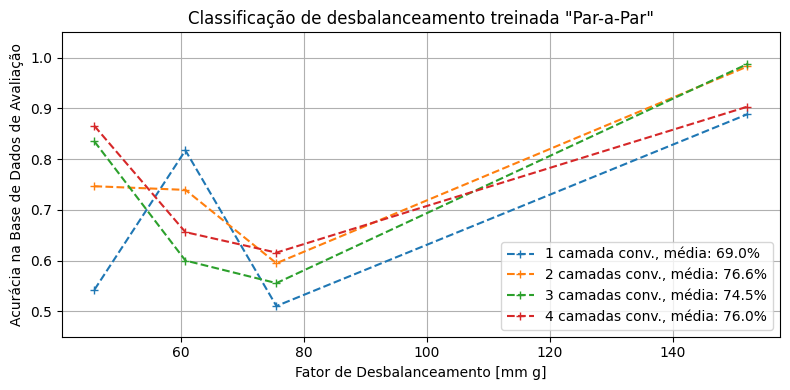

In [ ]:
fig=plt.figure(figsize=(8,4))
ax1=plt.subplot(111, title = 'Classificação de desbalanceamento treinada "Par-a-Par"')
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances[1:], accuracies_single[0,:],
         label=f"1 camada conv., média: {100.0*np.mean(accuracies_single[0,:]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies_single[1,:],
         label=f"2 camadas conv., média: {100.0*np.mean(accuracies_single[1,:]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies_single[2,:],
         label=f"3 camadas conv., média: {100.0*np.mean(accuracies_single[2,:]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies_single[3,:],
         label=f"4 camadas conv., média: {100.0*np.mean(accuracies_single[3,:]):.1f}%", marker="+", ls="--")
plt.ylabel("Acurácia na Base de Dados de Avaliação")
plt.xlabel("Fator de Desbalanceamento [mm g]")
plt.legend(loc="lower right")
plt.ylim([0.45, 1.05])
plt.grid(True)
plt.tight_layout()
plt.show()